# Collect generated text for evaluation data
We need to collect text generated by the model for the following two evaluation tasks:

1. Is reader-aware text (1) more relevant and (2) more likely to elicit interesting information from the author, than non-aware text?
2. Is it just as easy to differentiate different reader groups in the generated text as it is for the real text?

In [1]:
import torch
val_data = torch.load('../../data/reddit_data/combined_data_test_data.pt', map_location='cpu')
# convert to data frame because easier
import pandas as pd
val_data = pd.DataFrame(list(val_data))
data_cols = ['article_id', 'author_has_subreddit_embed', 'author_has_text_embed', 'reader_token_str', 'source_text', 'target_text', 'subreddit_embed', 'text_embed']
val_data = val_data.loc[:, data_cols]
print(val_data.shape)
# get metadata
import pandas as pd
post_metadata = pd.read_csv('../../data/reddit_data/combined_data_question_data.gz', sep='\t', compression='gzip', usecols=['article_id', 'subreddit'])
# add subreddit info
val_data = pd.merge(val_data, post_metadata, on=['article_id'], how='left')

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nlp/utils/py_utils.py:191: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return function(data_struct)


(51302, 8)


## Collect data for no-reader and reader-aware generated questions
After generating text with `test_question_generation.py`, we can filter for questions generated by no-reader and reader-aware models (additional condition: question should have some reader information attached).

In [13]:
import gzip
no_reader_pred_text = list(map(lambda x: x.strip(), gzip.open('../../data/reddit_data/text_only_model/test_data_output_text.gz', 'rt')))
reader_aware_pred_text = list(map(lambda x: x.strip(), gzip.open('../../data/reddit_data/author_text_data/test_data_output_text.gz', 'rt')))

In [17]:
import torch
test_data = torch.load('../../data/reddit_data/combined_data_val_data.pt')
# convert to dataframe
test_data = test_data.data.to_pandas()
test_data = test_data.loc[:, ['article_id', 'reader_token_str', 'source_text']]
# add predicted text
test_data = test_data.assign(**{
    'text_only_model_pred_text' : no_reader_pred_text,
    'reader_model_pred_text' : reader_aware_pred_text,
})
## add subreddit data
import pandas as pd
submission_data = pd.read_csv('../../data/reddit_data/subreddit_submissions_2018-01_2019-12.gz', sep='\t', compression='gzip', usecols=['id', 'subreddit'])
submission_data.rename(columns={'id' : 'article_id'}, inplace=True)
test_data = pd.merge(test_data, submission_data, on='article_id', how='left')
## limit to data where output is different!!
output_diff_test_data = test_data[test_data.loc[:, 'text_only_model_pred_text']!=test_data.loc[:, 'reader_model_pred_text']]
print(f'{output_diff_test_data.shape[0]}/{test_data.shape[0]} output that are different across models')
display(output_diff_test_data.head())

25495/51302 output that are different across models


,article_id,reader_token_str,source_text,text_only_model_pred_text,reader_model_pred_text,subreddit
22989,bc5yeu,<NONUS_AUTHOR>,"My sister is 34 and I'm 40, but since our earl...",Why did you even make this post?,Why would you do that to someone you're overre...,AmItheAsshole
22991,cbjgh5,<RESPONSE_TIME_1_AUTHOR>,Is it considered retaliation on my landlords p...,Do you have a lease or are you month to month?,Whose name is on the lease?,legaladvice
22992,a9wlwo,<EXPERT_PCT_0_AUTHOR>,"Like, I’m talking, age 30, at least 20 yrs of ...",Do you have an adult in your life that you tru...,Do you have an adult in your life that you tru...,Advice
22994,98f4o1,<US_AUTHOR>,I’m hoping someone can give me advice on how t...,What is their income?,Do they have home insurance?,personalfinance
22995,98f4o1,<EXPERT_PCT_0_AUTHOR>,I’m hoping someone can give me advice on how t...,What is their income?,Do they have home insurance?,personalfinance


In [50]:
## get sample from different subreddits
import numpy as np
np.random.seed(123)
sample_output_data = []
samples_per_reader_group = 5
for subreddit_i, data_i in output_diff_test_data.groupby('subreddit'):
    # remove UNK readers
    data_i = data_i[data_i.loc[:, 'reader_token_str']!='UNK']
    for reader_token_j, data_j in data_i.groupby('reader_token_str'):
        article_ids_j = np.random.choice(data_j.loc[:, 'article_id'].unique(), samples_per_reader_group, replace=False)
        sample_data_j = data_j[data_j.loc[:, 'article_id'].isin(article_ids_j)].drop_duplicates('article_id')
        sample_output_data.append(sample_data_j)
sample_output_data = pd.concat(sample_output_data, axis=0)
print(f'{sample_output_data.shape[0]} sample data')
display(sample_output_data.head())
# ## save to file
# sample_output_data.to_csv('../../data/reddit_data/annotation_data/text_quality_ground_truth_data.tsv', sep='\t', index=False)
## shuffle labels, rewrite as annotator data
annotator_sample_data = sample_output_data.copy()
annotator_sample_data.rename(columns={'source_text' : 'post'}, inplace=True)
pred_text_cols = ['text_only_model_pred_text', 'reader_model_pred_text']
N_pred_text = len(pred_text_cols)
sample_pred_shuffled_idx = annotator_sample_data.loc[:, pred_text_cols].apply(lambda x: np.random.choice(list(range(N_pred_text)), N_pred_text, replace=False), axis=1)
sample_pred_shuffled_text_cols = sample_pred_shuffled_idx.apply(lambda x: [pred_text_cols[idx] for idx in x])
for i in range(N_pred_text):
    annotator_sample_data = annotator_sample_data.assign(**{
        f'question_{i+1}' : list(map(lambda x: annotator_sample_data.iloc[x[0], :].loc[x[1][i]], enumerate(sample_pred_shuffled_text_cols.values))),
        f'system_{i+1}' : list(map(lambda x: x[i], sample_pred_shuffled_text_cols))
    })
display(annotator_sample_data.head())
## save ground-truth to file
annotator_sample_data.to_csv('../../data/reddit_data/annotation_data/generated_text_evaluation/text_quality_ground_truth_data.tsv', sep='\t', index=False)
## remove labels lol
system_cols = [f'system_{i+1}' for i in range(N_pred_text)]
unlabeled_sample_data = annotator_sample_data.drop(system_cols + ['reader_token_str'] + pred_text_cols, axis=1)
unlabeled_sample_data = unlabeled_sample_data.assign(**{
    'text_that_makes_more_sense' : -1,
    'text_that_is_more_fluent' : -1,
    'text_that_is_more_likely_helpful' : -1,
})
unlabeled_sample_data.to_csv('../../data/reddit_data/annotation_data/generated_text_evaluation/text_quality_annotation_data.tsv', sep='\t', index=False)

150 sample data


,article_id,reader_token_str,source_text,text_only_model_pred_text,reader_model_pred_text,subreddit
23949,8phwx3,<EXPERT_PCT_0_AUTHOR>,"I’m 30, have a well-paying job in Silicon Vall...",And how would I feel if I did the same?,Do I like the taste of the relationship?,Advice
26453,8lygi5,<EXPERT_PCT_0_AUTHOR>,"I'm on a trip currently, and my boyfriend and ...",Do you have any idea what the issue is?,Do you have any pictures or video of the trip?,Advice
37479,8oxseg,<EXPERT_PCT_0_AUTHOR>,"well there is a female i know, like im not fri...",Did you ever ask her why she dislikes you?,How does she react when you don't invite her?,Advice
38656,b0ycks,<EXPERT_PCT_0_AUTHOR>,So i have recently started writing a book and ...,What book is it?,Does the book give any information about what ...,Advice
42544,d1gl4d,<EXPERT_PCT_0_AUTHOR>,I’m not sure what exactly I’m asking for by po...,How can people say that a rape victim?,Have you tried talking to a counselor about this?,Advice


,article_id,reader_token_str,post,text_only_model_pred_text,reader_model_pred_text,subreddit,text_1,system_1,text_2,system_2
23949,8phwx3,<EXPERT_PCT_0_AUTHOR>,"I’m 30, have a well-paying job in Silicon Vall...",And how would I feel if I did the same?,Do I like the taste of the relationship?,Advice,And how would I feel if I did the same?,text_only_model_pred_text,Do I like the taste of the relationship?,reader_model_pred_text
26453,8lygi5,<EXPERT_PCT_0_AUTHOR>,"I'm on a trip currently, and my boyfriend and ...",Do you have any idea what the issue is?,Do you have any pictures or video of the trip?,Advice,Do you have any pictures or video of the trip?,reader_model_pred_text,Do you have any idea what the issue is?,text_only_model_pred_text
37479,8oxseg,<EXPERT_PCT_0_AUTHOR>,"well there is a female i know, like im not fri...",Did you ever ask her why she dislikes you?,How does she react when you don't invite her?,Advice,Did you ever ask her why she dislikes you?,text_only_model_pred_text,How does she react when you don't invite her?,reader_model_pred_text
38656,b0ycks,<EXPERT_PCT_0_AUTHOR>,So i have recently started writing a book and ...,What book is it?,Does the book give any information about what ...,Advice,Does the book give any information about what ...,reader_model_pred_text,What book is it?,text_only_model_pred_text
42544,d1gl4d,<EXPERT_PCT_0_AUTHOR>,I’m not sure what exactly I’m asking for by po...,How can people say that a rape victim?,Have you tried talking to a counselor about this?,Advice,How can people say that a rape victim?,text_only_model_pred_text,Have you tried talking to a counselor about this?,reader_model_pred_text


## Collect data for real and generated reader-aware questions
Let's get real and generated text for reader-aware questions.

In [11]:
## for each reader group pair: get 2 questions from same article
reader_group_data = [
    ('EXPERT', '<EXPERT_PCT_0_AUTHOR>', '<EXPERT_PCT_1_AUTHOR>'),
    ('TIME', '<RESPONSE_TIME_0_AUTHOR>', '<RESPONSE_TIME_1_AUTHOR>'),
    ('LOC', '<US_AUTHOR>', '<NONUS_AUTHOR>'),
]
# val_data_article_reader_groups = val_data.groupby('article_id').apply(lambda x: set(x.loc[:, 'reader_token_str'].unique()))
# article ID | reader group class | question | reader group type | subreddit
sample_size = 20
for subreddit_i, data_i in val_data.groupby('subreddit'):
    print(subreddit_i)
    article_reader_groups_i = data_i.groupby('article_id').apply(lambda x: set(x.loc[:, 'reader_token_str'].unique()))
    for reader_group_type_j, reader_group_1, reader_group_2 in reader_group_data:
        articles_ids_j = article_reader_groups_i[article_reader_groups_i.apply(lambda x: reader_group_1 in x and reader_group_2 in x)]
        print(len(articles_ids_j))

Advice
15
38
1
AmItheAsshole
86
246
42
legaladvice
6
56
1
pcmasterrace
2
13
1
personalfinance
20
100
1


OK! It looks like `pcmasterrace` and `personalfinance`, which we were planning to use in evaluation, don't have great coverage of reader groups.

Let's pivot to training data to improve coverage.

In [60]:
train_data = torch.load('../../data/reddit_data/combined_data_train_data.pt')
train_data = pd.DataFrame(list(train_data))
data_cols = ['article_id', 'author_has_subreddit_embed', 'author_has_text_embed', 'reader_token_str', 'source_text', 'source_ids_reader_token', 'target_text', 'subreddit_embed', 'text_embed', 'attention_mask']
train_data = train_data.loc[:, data_cols]
# add subreddit info
train_data = pd.merge(train_data, post_metadata, on=['article_id'], how='left')

In [18]:
print(train_data.loc[:, 'reader_token_str'].value_counts())

UNK                         1134850
<EXPERT_PCT_0_AUTHOR>        290931
<RESPONSE_TIME_0_AUTHOR>     223571
<RESPONSE_TIME_1_AUTHOR>      79179
<US_AUTHOR>                   29237
<NONUS_AUTHOR>                21367
<EXPERT_PCT_1_AUTHOR>         11819
Name: reader_token_str, dtype: int64


In [29]:
for subreddit_i, data_i in train_data.groupby('subreddit'):
    print(subreddit_i)
    article_reader_groups_i = data_i.groupby('article_id').apply(lambda x: set(x.loc[:, 'reader_token_str'].unique()))
    for reader_group_type_j, reader_group_1, reader_group_2 in reader_group_data:
        articles_ids_j = article_reader_groups_i[article_reader_groups_i.apply(lambda x: reader_group_1 in x and reader_group_2 in x)]
        print(f'group {reader_group_type_j} has {len(articles_ids_j)} articles')

Advice
group EXPERT has 66 articles
group TIME has 201 articles
group LOC has 8 articles
AmItheAsshole
group EXPERT has 270 articles
group TIME has 946 articles
group LOC has 122 articles
legaladvice
group EXPERT has 40 articles
group TIME has 199 articles
group LOC has 6 articles
pcmasterrace
group EXPERT has 19 articles
group TIME has 59 articles
group LOC has 0 articles
personalfinance
group EXPERT has 75 articles
group TIME has 413 articles
group LOC has 9 articles


This looks better! Now we can sample some data.

In [117]:
import numpy as np
np.random.seed(123)
sample_size = 100
reader_group_sample_question_data = []
for subreddit_i, data_i in train_data.groupby('subreddit'):
    article_reader_groups_i = data_i.groupby('article_id').apply(lambda x: set(x.loc[:, 'reader_token_str'].unique()))
    for reader_group_type_j, reader_group_1, reader_group_2 in reader_group_data:
        article_ids_j = article_reader_groups_i[article_reader_groups_i.apply(lambda x: reader_group_1 in x and reader_group_2 in x)].index.tolist()
        # sample
        if(len(article_ids_j) > sample_size):
            article_ids_j = np.random.choice(article_ids_j, sample_size, replace=False)
        # get paired reader group data for each article
        for article_id_k in article_ids_j:
            data_k = data_i[(data_i.loc[:, 'article_id']==article_id_k)]
            sample_data_k_1 = data_k[data_k.loc[:, 'reader_token_str']==reader_group_1].iloc[0, :]
            sample_data_k_2 = data_k[data_k.loc[:, 'reader_token_str']==reader_group_2].iloc[0, :]
            post_text_k = data_k.loc[:, 'source_text'].iloc[0]
            reader_group_sample_question_data.append([article_id_k, subreddit_i, post_text_k, sample_data_k_1.loc['target_text'], reader_group_1, sample_data_k_2.loc['target_text'], reader_group_2, reader_group_type_j])
reader_group_sample_question_data = pd.DataFrame(reader_group_sample_question_data, 
                                                 columns=['article_id', 'subreddit', 'post', 'question_1', 'group_1', 'question_2', 'group_2', 'group_type'])
display(reader_group_sample_question_data.head())

,article_id,subreddit,post,question_1,group_1,question_2,group_2,group_type
0,8kc90i,Advice,"First off, I have no problem with weed because...",Is she trying to use the marijuana as a shortc...,<EXPERT_PCT_0_AUTHOR>,but is it worth being caught?,<EXPERT_PCT_1_AUTHOR>,EXPERT
1,8l91i1,Advice,I work online and last week my boss called and...,"Now, how's that cold?",<EXPERT_PCT_0_AUTHOR>,Did you thank him for been a good boss and why...,<EXPERT_PCT_1_AUTHOR>,EXPERT
2,8p4uwz,Advice,Was in the midst of a panic attack over some t...,How would you feel if you or your family got a...,<EXPERT_PCT_0_AUTHOR>,Did any one see that you hit the car?,<EXPERT_PCT_1_AUTHOR>,EXPERT
3,8v8mga,Advice,"In other words, I don't know who I am. I suck ...",Have you ever tried keeping a diary or journal?,<EXPERT_PCT_0_AUTHOR>,"Do you doubt yourself, your choices, etc.?",<EXPERT_PCT_1_AUTHOR>,EXPERT
4,8vm0a1,Advice,"Hey, I’m 19 and a half and I’ve been out of hi...",What problem do you wish was solved in the world?,<EXPERT_PCT_0_AUTHOR>,"It was very different from School or College, ...",<EXPERT_PCT_1_AUTHOR>,EXPERT


Now! Let's generate questions for the same data using the reader-aware model, and organize to match the layout.

In [34]:
## load model
from test_question_generation import load_model
model_cache_dir = '../../data/model_cache/'
model_weight_file = '../../data/reddit_data/author_text_data/question_generation_model/checkpoint-114500/pytorch_model.bin'
data_dir = '../../data/reddit_data/author_text_data/'
model_type = 'bart_author'
model, model_tokenizer = load_model(model_cache_dir, model_weight_file, model_type, data_dir)

In [118]:
## subset data to articles and reader groups mentioned in sample data
generation_data = train_data[train_data.loc[:, 'article_id'].isin(reader_group_sample_question_data.loc[:, 'article_id'].unique())].drop_duplicates(['article_id', 'reader_token_str'])
article_id_valid_tokens = reader_group_sample_question_data.groupby('article_id').apply(lambda x: x.iloc[0, :].loc[['group_1', 'group_2']].values.tolist())
generation_data = generation_data[generation_data.apply(lambda x: x.loc['reader_token_str'] in article_id_valid_tokens.loc[x.loc['article_id']], axis=1)]
generation_data.sort_values('article_id', inplace=True)
generation_data = generation_data.loc[:, ['article_id', 'reader_token_str', 'source_ids_reader_token', 'attention_mask']]
generation_data.rename(columns={'source_ids_reader_token' : 'source_ids'}, inplace=True)
generation_data.drop_duplicates(['article_id', 'reader_token_str'], inplace=True)
print(generation_data.shape[0])
# fix tensor vars
generation_data = generation_data.assign(**{
    'source_ids' : generation_data.loc[:, 'source_ids'].apply(lambda x: torch.LongTensor(x)),
    'attention_mask' : generation_data.loc[:, 'attention_mask'].apply(lambda x: torch.LongTensor(x)),
})
# convert to list of dicts
generation_data_iter = generation_data.apply(lambda x: x.to_dict(), axis=1).values.tolist()
display(generation_data.head())

1634


,article_id,reader_token_str,source_ids,attention_mask
1636010,7py853,<NONUS_AUTHOR>,"[tensor(0), tensor(154), tensor(7), tensor(5),...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
1220202,7py853,<US_AUTHOR>,"[tensor(0), tensor(154), tensor(7), tensor(5),...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
1654293,7rkvv3,<US_AUTHOR>,"[tensor(0), tensor(17), tensor(27), tensor(119...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
1199596,7rkvv3,<NONUS_AUTHOR>,"[tensor(0), tensor(17), tensor(27), tensor(119...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
1507009,814t9v,<NONUS_AUTHOR>,"[tensor(0), tensor(1141), tensor(6), tensor(81...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."


In [119]:
## generate text for all source examples
from model_helpers import generate_predictions
generation_method = 'beam_search'
num_beams = 8
pred_text = generate_predictions(model, generation_data_iter, model_tokenizer, generation_method=generation_method, num_beams=num_beams)

100%|██████████| 1634/1634 [07:34<00:00,  3.60it/s]


In [120]:
## re-add to generation data
generation_pred_data = generation_data.assign(**{
    'pred_text' : pred_text
})
## reorganize to match original sampled data
reader_token_groups = {
    'LOC' : ['<US_AUTHOR>', '<NONUS_AUTHOR>'],
    'EXPERT' : ['<EXPERT_PCT_0_AUTHOR>', '<EXPERT_PCT_1_AUTHOR>'],
    'TIME' : ['<RESPONSE_TIME_0_AUTHOR>', '<RESPONSE_TIME_1_AUTHOR>'],
}
reader_token_group_lookup = {v1 : k for k,v in reader_token_groups.items() for v1 in v}
def flatten_pred_data(data, reader_token_group_lookup):
    reader_group_type = reader_token_group_lookup[data.loc[:, 'reader_token_str'].iloc[0]]
    data_1 = data.iloc[0, :]
    data_2 = data.iloc[1, :]
    flat_data = [data_1.loc['pred_text'], data_1.loc['reader_token_str'], 
                 data_2.loc['pred_text'], data_2.loc['reader_token_str'],
                 reader_group_type]
    flat_data_cols = ['question_1', 'group_1', 'question_2', 'group_2', 'group_type']
    flat_data = pd.Series(flat_data, index=flat_data_cols)
    return flat_data
per_article_generation_pred_data = generation_pred_data.groupby('article_id').apply(lambda x: flatten_pred_data(x, reader_token_group_lookup)).reset_index()
# remove duplicates
per_article_generation_pred_data = per_article_generation_pred_data[per_article_generation_pred_data.loc[:, 'question_1']!=per_article_generation_pred_data.loc[:, 'question_2']]
## join with metadata
per_article_generation_pred_data = pd.merge(per_article_generation_pred_data, reader_group_sample_question_data.loc[:, ['article_id', 'subreddit', 'post']].drop_duplicates('article_id'), on='article_id', how='left')
print(f'{per_article_generation_pred_data.shape[0]} generated pairs total')

260 generated pairs total


Now that we have the real and generated data, let's shuffle the groups to prepare for annotation.

In [121]:
def shuffle_questions_by_group(data, num_groups, group_vars=['question', 'group']):
    ordered_group_cols = [[f'{var}_{i}' for var in group_vars] for i in range(1, num_groups+1)]
    group_cols = list(ordered_group_cols)
    np.random.shuffle(group_cols)
    flat_group_cols = [y for x in group_cols for y in x]
    flat_ordered_group_cols = [y for x in ordered_group_cols for y in x]
    group_data = data.loc[flat_group_cols]
    group_data.index = flat_ordered_group_cols
    data.drop(flat_ordered_group_cols, inplace=True)
    data = data.append(group_data)
    return data

In [122]:
num_groups = 2
shuffled_generation_pred_data = per_article_generation_pred_data.apply(lambda x: shuffle_questions_by_group(x, num_groups), axis=1)
shuffled_reader_group_sample_question_data = reader_group_sample_question_data.apply(lambda x: shuffle_questions_by_group(x, num_groups), axis=1)
# align columns lol
shuffled_generation_pred_data = shuffled_generation_pred_data.loc[:, shuffled_reader_group_sample_question_data.columns]
## prepare for annotation
reader_group_type_choices = pd.DataFrame([
    ['EXPERT', 'expert vs. novice'],
    ['TIME', 'fast response vs. slow response'],
    ['LOC', 'US vs. non-US'],
], columns=['group_type', 'group_type_choices'])
def prepare_for_annotation(data, reader_group_type_choices):
    # drop labels
    annotation_data = data.drop(['group_1', 'group_2'], axis=1)
    # add choices
    annotation_data = pd.merge(annotation_data, reader_group_type_choices, on=['group_type'], how='left')
    annotation_data = annotation_data.assign(**{'question_1_group_label' : -1})
    return annotation_data
annotation_generation_pred_data = prepare_for_annotation(shuffled_generation_pred_data, reader_group_type_choices)
annotation_reader_group_sample_question_data = prepare_for_annotation(shuffled_reader_group_sample_question_data, reader_group_type_choices)
display(annotation_generation_pred_data.head())
display(annotation_reader_group_sample_question_data.head())

,article_id,subreddit,post,group_type,question_1,question_2,group_type_choices,label
0,7py853,legaladvice,Turning to the experts at reddit! I'm in a ba...,LOC,Are you sure it's not a scam and not a identit...,Are you sure it's not a scam?,US vs. non-US,-1
1,814t9v,personalfinance,"My wife, over a year ago, thought she submitte...",LOC,Did she file for deferment?,Did you send her a certified letter or just a ...,US vs. non-US,-1
2,89p14v,Advice,Every Tuesday my neighbours garbage goes flyin...,LOC,Are you sure it wasn’t your mom’s personal junk?,How did you get your garbage there?,US vs. non-US,-1
3,8c71q3,Advice,My ex girlfriend is very suicidal. We broke up...,LOC,How long have you been with her?,How long have you been with this person?,US vs. non-US,-1
4,8kc90i,Advice,"First off, I have no problem with weed because...",EXPERT,Is she trying to use the marijuana for feeling...,What is her motivation behind it?,expert vs. novice,-1


,article_id,subreddit,post,group_type,question_1,question_2,group_type_choices,label
0,8kc90i,Advice,"First off, I have no problem with weed because...",EXPERT,Is she trying to use the marijuana as a shortc...,but is it worth being caught?,expert vs. novice,-1
1,8l91i1,Advice,I work online and last week my boss called and...,EXPERT,Did you thank him for been a good boss and why...,"Now, how's that cold?",expert vs. novice,-1
2,8p4uwz,Advice,Was in the midst of a panic attack over some t...,EXPERT,How would you feel if you or your family got a...,Did any one see that you hit the car?,expert vs. novice,-1
3,8v8mga,Advice,"In other words, I don't know who I am. I suck ...",EXPERT,"Do you doubt yourself, your choices, etc.?",Have you ever tried keeping a diary or journal?,expert vs. novice,-1
4,8vm0a1,Advice,"Hey, I’m 19 and a half and I’ve been out of hi...",EXPERT,What problem do you wish was solved in the world?,"It was very different from School or College, ...",expert vs. novice,-1


In [123]:
# check subreddit distribution
display(annotation_reader_group_sample_question_data.loc[:, 'subreddit'].value_counts())
display(annotation_generation_pred_data.loc[:, 'subreddit'].value_counts())

AmItheAsshole      300
personalfinance    184
Advice             174
legaladvice        146
pcmasterrace        78
Name: subreddit, dtype: int64

AmItheAsshole      87
personalfinance    59
Advice             55
legaladvice        41
pcmasterrace       18
Name: subreddit, dtype: int64

In [124]:
## restrict to same posts
annotation_reader_group_sample_question_data = annotation_reader_group_sample_question_data[annotation_reader_group_sample_question_data.loc[:, 'article_id'].isin(annotation_generation_pred_data.loc[:, 'article_id'].unique())]
## sort
annotation_reader_group_sample_question_data.sort_values(['subreddit', 'article_id'], inplace=True)
annotation_generation_pred_data.sort_values(['subreddit', 'article_id'], inplace=True)
print(annotation_reader_group_sample_question_data.shape[0])
print(annotation_generation_pred_data.shape[0])

280
260


<ipython-input-124-c260bb5366e4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annotation_reader_group_sample_question_data.sort_values(['subreddit', 'article_id'], inplace=True)


In [131]:
## add real/generated labels
shuffled_reader_group_sample_question_data = shuffled_reader_group_sample_question_data.assign(**{
    'question_type' : 'real',
})
shuffled_generation_pred_data = shuffled_generation_pred_data.assign(**{
    'question_type' : 'author_token_model',
})
## combine
combined_ground_truth_data = pd.concat([
    shuffled_reader_group_sample_question_data,
    shuffled_generation_pred_data
], axis=0)
combined_annotation_data = pd.concat([
    annotation_reader_group_sample_question_data,
    annotation_generation_pred_data,
])
## sort
combined_annotation_data.sort_values(['article_id', 'subreddit', 'group_type_choices'], inplace=True)

In [132]:
# write ground truth data
combined_ground_truth_data.to_csv('../../data/reddit_data/annotation_data/generated_text_evaluation/reader_group_ground_truth_data.tsv', sep='\t', index=False)
# write annotation data
combined_annotation_data.to_csv('../../data/reddit_data/annotation_data/generated_text_evaluation/reader_group_annotation_data.tsv', sep='\t', index=False)

## Test pilot annotations (round 1)
Let's test the pilot annotations (from `r/PCMasterRace`).

In [1]:
## load ground-truth data
import pandas as pd
text_quality_data = pd.read_csv('../../data/reddit_data/annotation_data/generated_text_evaluation/text_quality_ground_truth_data.tsv', sep='\t', index_col=False)
reader_group_data = pd.read_csv('../../data/reddit_data/annotation_data/generated_text_evaluation/reader_group_ground_truth_data.tsv', sep='\t', index_col=False)
# fix reader group columns
reader_group_type_lookup = {
    '<EXPERT_PCT_0_AUTHOR>' : 'non-expert',
    '<EXPERT_PCT_1_AUTHOR>' : 'expert',
    '<RESPONSE_TIME_0_AUTHOR>' : 'slow',
    '<RESPONSE_TIME_1_AUTHOR>' : 'high',
}
import re
reader_group_cols = list(filter(lambda x: re.match('group_\d', x), reader_group_data.columns))
for reader_group_col in reader_group_cols:
    reader_group_data = reader_group_data.assign(**{
        reader_group_col : reader_group_data.loc[:, reader_group_col].apply(reader_group_type_lookup.get)
    })
print(text_quality_data.columns)
print(reader_group_data.columns)

Index(['article_id', 'reader_token_str', 'post', 'text_only_model_pred_text',
       'reader_model_pred_text', 'subreddit', 'question_1', 'system_1',
       'question_2', 'system_2'],
      dtype='object')
Index(['article_id', 'subreddit', 'post', 'group_type', 'question_1',
       'group_1', 'question_2', 'group_2', 'question_type'],
      dtype='object')


In [34]:
import pandas as pd
import re
import os
def collect_organize_annotation_data(data_files):
    combined_data = []
    data_type = re.search('(.+)(?=_annotation_data)', os.path.basename(data_files[0])).group(0)
    if(data_type == 'text_quality'):
        annotation_cols = ['text_that_is_more_relevant', 'text_that_is_more_fluent', 'text_that_is_more_likely_helpful']
    elif(data_type == 'reader_group'):
        annotation_cols = ['question_1_group_label']
    for data_file in data_files:
        data = pd.read_csv(data_file, sep='\t', index_col=False)
        annotator_id = int(data_file.replace('.tsv', '').split('_')[-1])
        data.rename(columns={
            col : f'{col}_{annotator_id}'
            for col in annotation_cols
        }, inplace=True)
        combined_data.append(data)
    if(data_type == 'text_quality'):
        join_cols = ['article_id', 'subreddit']
    # for reader group annotation, some posts have multiple question tests (e.g. US/non-US and expert/non-expert)
    elif(data_type == 'reader_group'):
        join_cols = ['article_id', 'subreddit', 'question_1', 'question_2']
    # drop dulicate columns
#     for data in combined_data:
#         data.drop_duplicates(join_cols, inplace=True)
    clean_data = combined_data[0].copy()
    label_col_matcher = re.compile('|'.join(list(map(lambda x: f'{x}_\d', annotation_cols))))
    for data in combined_data[1:]:
#         print(f'clean data cols {clean_data.columns}')
#         print(f'data cols {data.columns}')
#         label_cols = list(filter(lambda x: re.match('.+_\d', x), data.columns))
        label_cols = list(filter(lambda x: label_col_matcher.match(x) is not None, data.columns))
        join_label_cols = list(set(join_cols)|set(label_cols))
        clean_data = pd.merge(clean_data, data.loc[:, join_label_cols], on=join_cols, how='outer')
    # remove null labels
    clean_label_cols = list(filter(lambda x: re.match('.+_\d', x), clean_data.columns))
    null_label_val = -1
    clean_data = clean_data[clean_data.loc[:, clean_label_cols].max(axis=1) != null_label_val]
    return clean_data

In [36]:
data_dir = '../../data/reddit_data/annotation_data/generated_text_evaluation'
text_quality_annotation_files = list(filter(lambda x: re.match('text_quality_.*pilot_\d\.tsv', x) is not None, os.listdir('../../data/reddit_data/annotation_data/generated_text_evaluation/')))
reader_group_annotation_files = list(filter(lambda x: re.match('reader_group_.*pilot_\d\.tsv', x) is not None, os.listdir('../../data/reddit_data/annotation_data/generated_text_evaluation/')))
text_quality_annotation_files = list(map(lambda x: os.path.join(data_dir, x), text_quality_annotation_files))
reader_group_annotation_files = list(map(lambda x: os.path.join(data_dir, x), reader_group_annotation_files))
text_quality_annotation_data = collect_organize_annotation_data(text_quality_annotation_files)
reader_group_annotation_data = collect_organize_annotation_data(reader_group_annotation_files)
print(f'{text_quality_annotation_data.shape[0]} data for text quality')
print(f'{reader_group_annotation_data.shape[0]} data for text quality')
display(text_quality_annotation_data.head())
display(reader_group_annotation_data.head())

30 data for text quality
36 data for text quality


,article_id,post,subreddit,question_1,question_2,text_that_is_more_relevant_2,text_that_is_more_fluent_2,text_that_is_more_likely_helpful_2,Comment,text_that_is_more_relevant_1,text_that_is_more_likely_helpful_1,text_that_is_more_fluent_1
0,az4os4,This is my first build and they are all brand ...,pcmasterrace,What are you trying to achieve here?,Do you have a graphics card installed?,2,1,1,NaN,2,1,2
1,czgw6r,"Hi guys, I recently faced a problem on Intel X...",pcmasterrace,Do you have the same problem in another system?,Do you have an Intel CPU?,2,1,2,NaN,2,2,2
2,aorth3,I seem to have a performance issue with Hitman...,pcmasterrace,Is it at 1080p or 1440p?,Does it do it at 1080 or 1440p?,2,2,2,same question,1,1,1
3,agykvp,"Hello Everbody, I want to build a new pc for...",pcmasterrace,What are you going to be doing with the pc?,Are you okay with that?,1,1,1,NaN,1,1,1
4,arenff,"I have one of those Intel Stock coolers, in a ...",pcmasterrace,What's your temps like?,Do you have good airflow in your case?,1,2,2,NaN,2,2,2


,article_id,subreddit,post,group_type,question_1,question_2,group_type_choices,question_1_group_label_2,Unnamed: 8,comments,question_1_group_label_1
0,8mz1o1,pcmasterrace,hey i'm in need of some helpi have a beefy pc ...,TIME,Is that temp changing at all?,"What system is that, what motherboard with whi...",fast response vs. slow response,fast,NaN,NaN,fast
1,8mz1o1,pcmasterrace,hey i'm in need of some helpi have a beefy pc ...,TIME,What model is your cpu?,What temp is your monitor?,fast response vs. slow response,slow,NaN,very hard to say for both,slow
2,8uajem,pcmasterrace,"Hello, I was curious as to what kind of stuff ...",TIME,Have you tried power cycling the monitor?,What do you mean the RAM was in the wrong way?,fast response vs. slow response,slow,NaN,NaN,slow
3,8uajem,pcmasterrace,"Hello, I was curious as to what kind of stuff ...",TIME,Are you sure it's the RAM and not the motherbo...,What do you mean it's in the wrong way?,fast response vs. slow response,slow,NaN,NaN,slow
4,8v9wk1,pcmasterrace,So I see everyone getting like around 60 fps. ...,TIME,Isnt this game a shitty port with 50 different...,are all your drivers up to date?,fast response vs. slow response,fast,NaN,NaN,fast


In [33]:
reader_group_annotation_data.columns

Index(['article_id', 'subreddit', 'post', 'group_type', 'question_1',
       'question_2', 'group_type_choices', 'question_1_group_label_2',
       'Unnamed: 8', 'comments', 'question_1_group_label_1'],
      dtype='object')

In [37]:
## reshape data
text_quality_data_cols = ['article_id', 'subreddit', 'text_only_model_pred_text', 'reader_model_pred_text', 'reader_token_str', 'system_1', 'system_2']
clean_text_quality_data = pd.merge(
    text_quality_data.loc[:, text_quality_data_cols],
    text_quality_annotation_data, on=['article_id', 'subreddit'],
)
reader_group_data_cols = ['article_id', 'subreddit', 'group_1', 'group_2', 'question_type', 'question_1', 'question_2']
clean_reader_group_data = pd.merge(
    reader_group_data.loc[:, reader_group_data_cols],
    reader_group_annotation_data, on=['article_id', 'subreddit', 'question_1', 'question_2'],
)
display(clean_text_quality_data.head())
display(clean_reader_group_data.head())

,article_id,subreddit,text_only_model_pred_text,reader_model_pred_text,reader_token_str,system_1,system_2,post,question_1,question_2,text_that_is_more_relevant_2,text_that_is_more_fluent_2,text_that_is_more_likely_helpful_2,Comment,text_that_is_more_relevant_1,text_that_is_more_likely_helpful_1,text_that_is_more_fluent_1
0,az4os4,pcmasterrace,Do you have a graphics card installed?,What are you trying to achieve here?,<EXPERT_PCT_0_AUTHOR>,reader_model_pred_text,text_only_model_pred_text,This is my first build and they are all brand ...,What are you trying to achieve here?,Do you have a graphics card installed?,2,1,1,NaN,2,1,2
1,czgw6r,pcmasterrace,Do you have the same problem in another system?,Do you have an Intel CPU?,<EXPERT_PCT_0_AUTHOR>,text_only_model_pred_text,reader_model_pred_text,"Hi guys, I recently faced a problem on Intel X...",Do you have the same problem in another system?,Do you have an Intel CPU?,2,1,2,NaN,2,2,2
2,aorth3,pcmasterrace,Is it at 1080p or 1440p?,Does it do it at 1080 or 1440p?,<EXPERT_PCT_0_AUTHOR>,text_only_model_pred_text,reader_model_pred_text,I seem to have a performance issue with Hitman...,Is it at 1080p or 1440p?,Does it do it at 1080 or 1440p?,2,2,2,same question,1,1,1
3,agykvp,pcmasterrace,Are you okay with that?,What are you going to be doing with the pc?,<EXPERT_PCT_0_AUTHOR>,reader_model_pred_text,text_only_model_pred_text,"Hello Everbody, I want to build a new pc for...",What are you going to be doing with the pc?,Are you okay with that?,1,1,1,NaN,1,1,1
4,arenff,pcmasterrace,What's your temps like?,Do you have good airflow in your case?,<EXPERT_PCT_0_AUTHOR>,text_only_model_pred_text,reader_model_pred_text,"I have one of those Intel Stock coolers, in a ...",What's your temps like?,Do you have good airflow in your case?,1,2,2,NaN,2,2,2


,article_id,subreddit,group_1,group_2,question_type,question_1,question_2,post,group_type,group_type_choices,question_1_group_label_2,Unnamed: 8,comments,question_1_group_label_1
0,bg2q51,pcmasterrace,expert,non-expert,real,What storage do you have?,"This is going to sound ridiculous, but have yo...","So first off, I'm running an i5-7500, GTX1070,...",EXPERT,expert vs. novice,expert,NaN,NaN,novice
1,clojsj,pcmasterrace,non-expert,expert,real,Is the graphics card getting enough airflow?,Did you change nvidia driver settings to displ...,I'm running the following and am unhappy with ...,EXPERT,expert vs. novice,non-expert,NaN,NaN,novice
2,d8yjen,pcmasterrace,expert,non-expert,real,That may be an option instead of you paying to...,"Hungarian here, I'm dropping my tuf505 for ser...",Just a few weeks ago I had an ROG STRIX 1070Ti...,EXPERT,expert vs. novice,non-expert,NaN,NaN,expert
3,8mz1o1,pcmasterrace,high,slow,real,Is that temp changing at all?,"What system is that, what motherboard with whi...",hey i'm in need of some helpi have a beefy pc ...,TIME,fast response vs. slow response,fast,NaN,NaN,fast
4,8uajem,pcmasterrace,slow,high,real,Have you tried power cycling the monitor?,What do you mean the RAM was in the wrong way?,"Hello, I was curious as to what kind of stuff ...",TIME,fast response vs. slow response,slow,NaN,NaN,slow


For the text quality data, how well do the two systems compare with one another in terms of fluency, etc.?

In [38]:
from scipy.stats import binom_test
def get_aggregate_label_counts(data, label_cols=[]):
    label_counts = []
    for col_i in label_cols:
        label_cols_i = list(filter(lambda x: col_i in x, data.columns))
        combined_labels_i = []
        for label_col_j in label_cols_i:
            # get name of system that matches question chosen
            labels_j = data.apply(lambda x: x.loc[f'system_{x.loc[label_col_j]}'], axis=1)
            combined_labels_i += labels_j.values.tolist()
        combined_label_counts_i = pd.Series(combined_labels_i).value_counts()
        combined_label_pct_i = combined_label_counts_i / combined_label_counts_i.sum()
        combined_label_pct_i.loc['label_type'] = col_i
        combined_label_pct_i.loc['N'] = len(combined_labels_i)
        # test for significance lol
        p_val = binom_test(combined_label_counts_i.values, n=len(combined_labels_i))
        combined_label_pct_i.loc['binom_test'] = p_val
        label_counts.append(combined_label_pct_i)
    label_counts = pd.concat(label_counts, axis=1).transpose()
    return label_counts

In [39]:
## compute aggregate counts for each system being chosen as "better"
text_quality_label_cols = ['text_that_is_more_relevant', 'text_that_is_more_fluent', 'text_that_is_more_likely_helpful']
text_quality_label_counts = get_aggregate_label_counts(clean_text_quality_data, label_cols=text_quality_label_cols)
# get total stats
model_cols = ['reader_model_pred_text', 'text_only_model_pred_text']
N_total = text_quality_label_counts.loc[:, 'N'].sum()
mean_choice_counts = text_quality_label_counts.apply(lambda x: x.loc[model_cols] * x.loc['N'], axis=1).sum(axis=0)
mean_choice_pct = mean_choice_counts / N_total
mean_choice_pct.loc['label_type'] = 'combined'
mean_choice_pct.loc['N'] = N_total
mean_choice_pct.loc['binom_test'] = binom_test(mean_choice_counts, N_total)
text_quality_label_counts = text_quality_label_counts.append(pd.DataFrame(mean_choice_pct).transpose())
display(text_quality_label_counts.head())

,reader_model_pred_text,text_only_model_pred_text,label_type,N,binom_test
0,0.533333,0.466667,text_that_is_more_relevant,60,0.698883
1,0.583333,0.416667,text_that_is_more_fluent,60,0.245061
2,0.65,0.35,text_that_is_more_likely_helpful,60,0.0273401
0,0.588889,0.411111,combined,180,0.020597


OK! We see a slight preference for the reader-aware model overall, but no significant preference for `relevant` and `fluent` labels.

Let's test the reader group guessing accuracy.

In [40]:
clean_reader_group_data.head()

,article_id,subreddit,group_1,group_2,question_type,question_1,question_2,post,group_type,group_type_choices,question_1_group_label_2,Unnamed: 8,comments,question_1_group_label_1
0,bg2q51,pcmasterrace,expert,non-expert,real,What storage do you have?,"This is going to sound ridiculous, but have yo...","So first off, I'm running an i5-7500, GTX1070,...",EXPERT,expert vs. novice,expert,NaN,NaN,novice
1,clojsj,pcmasterrace,non-expert,expert,real,Is the graphics card getting enough airflow?,Did you change nvidia driver settings to displ...,I'm running the following and am unhappy with ...,EXPERT,expert vs. novice,non-expert,NaN,NaN,novice
2,d8yjen,pcmasterrace,expert,non-expert,real,That may be an option instead of you paying to...,"Hungarian here, I'm dropping my tuf505 for ser...",Just a few weeks ago I had an ROG STRIX 1070Ti...,EXPERT,expert vs. novice,non-expert,NaN,NaN,expert
3,8mz1o1,pcmasterrace,high,slow,real,Is that temp changing at all?,"What system is that, what motherboard with whi...",hey i'm in need of some helpi have a beefy pc ...,TIME,fast response vs. slow response,fast,NaN,NaN,fast
4,8uajem,pcmasterrace,slow,high,real,Have you tried power cycling the monitor?,What do you mean the RAM was in the wrong way?,"Hello, I was curious as to what kind of stuff ...",TIME,fast response vs. slow response,slow,NaN,NaN,slow


In [41]:
# group type | # correct | # incorrect | text type (real/generated)
from scipy.stats import binom_test
def get_guess_pct_data(data, label_cols):
    combined_label_guesses = []
    for label_col_i in label_cols:
        label_guesses_i = (data.loc[:, 'group_1']==data.loc[:, label_col_i]).astype(int)
        combined_label_guesses += label_guesses_i.values.tolist()
    ## get aggregate T/F guess counts
    combined_label_guess_counts = pd.Series(combined_label_guesses).value_counts()
    combined_label_guess_pct = combined_label_guess_counts / combined_label_guess_counts.sum()
    combined_label_guess_pct.loc['N'] = len(combined_label_guesses)
    # binom test
    p_val = binom_test(combined_label_guess_counts.values, n=len(combined_label_guess_counts))
    combined_label_guess_pct.loc['p_val'] = p_val
    return combined_label_guess_pct
def get_guess_counts_per_type(data, label_cols, type_var):
    combined_label_guess_data = []
    for group_i, data_i in data.groupby(type_var):
        combined_label_guess_pct = get_guess_pct_data(data_i, label_cols)
        combined_label_guess_pct.loc['type_val'] = group_i
        combined_label_guess_pct.loc['type'] = type_var
        combined_label_guess_data.append(combined_label_guess_pct)
    combined_label_guess_data = pd.concat(combined_label_guess_data, axis=1).transpose().rename(columns={0:'wrong', 1:'right'})
    return combined_label_guess_data
def get_aggregate_guess_counts(data, label_col='question_1_group_label'):
    label_cols = list(filter(lambda x: re.match(f'{label_col}_\d', x), data.columns))
    combined_label_guess_data = []
    ## overall guesses
    combined_label_guess_pct = get_guess_pct_data(data, label_cols)
    # clean up
    combined_label_guess_pct.loc['type'] = 'combined'
    combined_label_guess_pct.loc['type_val'] = 'combined'
    combined_label_guess_pct = pd.DataFrame(combined_label_guess_pct).transpose()
    combined_label_guess_pct.rename(columns={0:'wrong', 1:'right'}, inplace=True)
    ## guesses by reader group
    reader_group_guess_count_data = get_guess_counts_per_type(data, label_cols, 'group_type')
    ## guesses by question type
    question_type_guess_count_data = get_guess_counts_per_type(data, label_cols, 'question_type')
    combined_label_guess_data = [
        combined_label_guess_pct,
        reader_group_guess_count_data,
        question_type_guess_count_data
    ]
    combined_label_guess_data = pd.concat(combined_label_guess_data, axis=0)
    # sort columns
    ordered_guess_cols = ['type', 'type_val', 'N', 'right', 'wrong', 'p_val']
    combined_label_guess_data = combined_label_guess_data.loc[:, ordered_guess_cols]
    return combined_label_guess_data

In [42]:
label_col = 'question_1_group_label'
reader_group_guess_counts = get_aggregate_guess_counts(clean_reader_group_data, label_col=label_col)
print(reader_group_guess_counts)

            type            type_val   N     right     wrong      p_val
0       combined            combined  72  0.347222  0.652778  0.0127746
0     group_type              EXPERT  12       0.5       0.5          1
1     group_type                TIME  60  0.316667  0.683333  0.0062176
0  question_type  author_token_model  36  0.388889  0.611111   0.242985
1  question_type                real  36  0.305556  0.694444  0.0288167


<ipython-input-41-14478c8070d6>:23: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  combined_label_guess_data = pd.concat(combined_label_guess_data, axis=1).transpose().rename(columns={0:'wrong', 1:'right'})
<ipython-input-41-14478c8070d6>:44: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  combined_label_guess_data = pd.concat(combined_label_guess_data, axis=0)


OK! So overall the annotators did not do well on the task except for the `EXPERT` data and for the `author_token_model` data (less bad than `real` data).

In [55]:
## tmp
import torch
input_dim = 1024
embed_dim = 300
fake_text_data = torch.Tensor(input_dim, embed_dim).unsqueeze(1)
fake_author_data = torch.Tensor(1, embed_dim).unsqueeze(1)
print(fake_text_data.shape)
combine_network = torch.nn.Linear(input_dim+1, input_dim)
fake_text_author_data = torch.cat([fake_text_data, fake_author_data])
print(fake_text_author_data.shape)
fake_output = combine_network(fake_text_author_data.squeeze(1).T).unsqueeze(1)
print(fake_output.shape)

torch.Size([1024, 1, 300])
torch.Size([1025, 1, 300])
torch.Size([300, 1, 1024])


### Qualtrics test: expert vs non-expert
For a pilot test on Qualtrics, let's collect examples of questions from expert and non-expert authors to rate for fluency/coherence/utility.

In [1]:
import sys
if('..' not in sys.path):
    sys.path.append('..')
from data_processing.data_helpers import load_sample_data
sample_question_data = load_sample_data(sample_type='paired')
print(sample_question_data.shape)

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (1,2,8,9,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
100%|██████████| 127373/127373 [01:36<00:00, 1320.57it/s]


after paired sampling: question data has label distribution = 0.0      100636
1.0      100636
US         4306
NONUS      4306
Name: author_group, dtype: int64
after paired sampling: question data has subreddit distribution = AmItheAsshole      160736
personalfinance     20056
Advice              12546
legaladvice         11080
pcmasterrace         5466
Name: subreddit, dtype: int64
(209884, 10)


In [2]:
## load generated data
import gzip
import torch
test_data = torch.load('../../data/reddit_data/combined_data_test_data.pt')
test_data_df = test_data.data.to_pandas()
test_data_df = test_data_df.loc[:, ['article_id', 'question_id', 'author', 'id']]
text_only_model_data = list(map(lambda x: x.strip(), gzip.open('../../data/reddit_data/text_only_model/test_data_output_text.gz', 'rt')))
reader_model_data = list(map(lambda x: x.strip(), gzip.open('../../data/reddit_data/author_text_data/author_attention_data/test_data_output_text.gz', 'rt')))
test_data_df = test_data_df.assign(**{
    'text_model' : text_only_model_data,
    'reader_model' : reader_model_data,
})
test_data_df.rename(columns={'article_id' : 'parent_id'}, inplace=True)
# combine with sample data
import pandas as pd
sample_data = pd.merge(sample_question_data, test_data_df, on=['question_id', 'parent_id', 'author'], how='inner')

In [3]:
# post | subreddit | expert Q (real) | expert Q (reader-attention model) | novice Q (reader-attention model) | Q (text-only model)
import random
random.seed(123)
paired_group_data = []
author_group_category_vals = {
    'relative_time_bin' : [0, 1],
    'expert_pct_bin' : [0, 1],
    'location_region' : ['US', 'NONUS'],
}
num_group_vals = 2
for (parent_id_i, group_category_i), data_i in sample_data.groupby(['parent_id', 'group_category']):
    if(len(set(data_i.loc[:, 'author_group'].unique()) & set(author_group_category_vals[group_category_i]))==num_group_vals):
        group_vals_i = author_group_category_vals[group_category_i]
        random.shuffle(group_vals_i)
        # randomly swap values for annotation!!
        post_i = data_i.loc[:, 'post'].iloc[0]
        text_output_i = data_i.loc[:, 'text_model'].iloc[0]
        subreddit_i = data_i.loc[:, 'subreddit'].iloc[0]
        paired_group_data_i = []
        for j, group_val_j in enumerate(group_vals_i):
            data_j = data_i[data_i.loc[:, 'author_group']==group_val_j].iloc[0, :]
            # get real text, reader-aware text
            paired_group_data_i.append(pd.Series([group_val_j, data_j.loc['reader_model'], data_j.loc['question'], data_j.loc['id']], 
                                                 index=[f'reader_group_{j+1}', f'reader_model_output_group_{j+1}', f'question_group_{j+1}', f'question_id_{j+1}']))
        paired_group_data_i = pd.concat(paired_group_data_i, axis=0)
        paired_group_data_i = paired_group_data_i.append(pd.Series([parent_id_i, post_i, subreddit_i, text_output_i, group_category_i], 
                                                                   index=['post_id', 'post_text', 'subreddit', 'text_model_output', 'reader_group_category']))
#         paired_group_data_i = paired_group_data_i.append(pd.Series(group_vals_i, index=[f'group_{x+1}' for x in range(len(group_vals_i))]))
        paired_group_data.append(paired_group_data_i)
paired_group_data = pd.concat(paired_group_data, axis=1).transpose()
# remove duplicate questions
paired_group_data = paired_group_data[paired_group_data.loc[:, 'question_group_1']!=paired_group_data.loc[:, 'question_group_2']]
paired_group_data = paired_group_data[paired_group_data.loc[:, 'reader_model_output_group_1']!=paired_group_data.loc[:, 'reader_model_output_group_2']]
# add per-pair ID
paired_group_data = paired_group_data.assign(**{
    'pair_id' : paired_group_data.apply(lambda x: hash(x.loc['question_group_1']+x.loc['question_group_2']), axis=1)
})
# filter long posts
from nltk.tokenize import WordPunctTokenizer
tokenizer = WordPunctTokenizer()
max_post_word_count = 300
paired_group_data = paired_group_data.assign(**{
    'post_len' : paired_group_data.loc[:, 'post_text'].apply(lambda x: len(tokenizer.tokenize(x)))
})
paired_group_data = paired_group_data[paired_group_data.loc[:, 'post_len']<=max_post_word_count]

In [4]:
print(paired_group_data.loc[:, 'subreddit'].value_counts())

AmItheAsshole      219
personalfinance     68
Advice              51
legaladvice         36
pcmasterrace        22
Name: subreddit, dtype: int64


Now let's organize this into annotation-friendly format for Qualtrics:

- post

`{post text}`

- question quality annotation

```
[[Question:Matrix]]
1. {question text}

[[Choices]]
ma Coherent
mb Fluent
mc Answerable

[[Answers]]
m1 Very
m2 Somewhat
m3 Neutral
m4 Not very
m5 Not at all
```

- question reader group comparison

```
[[Question:MC]]
2. 
Q1: {question1 text}
Q2: {question2 text}
Which question was more likely written by a {group1} reader?

[[Choices]]
a Q1
b Q2
```

In [5]:
import re
DEFAULT_GROUP_VAL_LOOKUP = {
    'location_region' : 'US',
    'expert_pct_bin' : 1,
    'relative_time_bin' : 1,
}
DEFAULT_GROUP_VAL_NAME_LOOKUP = {
    'location_region' : 'US',
    'expert_pct_bin' : 'expert',
    'relative_time_bin' : 'slow-response',
}
GROUP_VAL_ALL_NAME_LOOKUP = {
    'location_region' : ['NONUS', 'US'],
    'expert_pct_bin' : ['novice', 'expert'],
    'relative_time_bin' : ['fast-response', 'slow-response']
    
}
GROUP_EXPLANATION_LOOKUP = {
    'location_region' : 'A NONUS reader is someone who does not live in the United States, and a US reader is someone who currently lives in the US.',
    'expert_pct_bin' : 'A novice reader is someone who does not spend very much time discussing topics like this, and a expert reader is someone who spends a lot of time discussing topics like this.',
    'relative_time_bin' : 'A fast-response reader is someone who responds to posts quickly, and a slow-response reader is someone who typically responds to posts after a long time.',
    
}
def convert_question_data_to_txt(data, question_vals=['question_group', 'reader_model_output_group'], question_num=1):
    # header text
    subreddit = f"r/{data.loc['subreddit']}"
    text = [f"""
    [[Question:DB]]
    Subreddit: <b>{subreddit}</b> </br>
    Please read the following post.</br></br>
    
    Post:\n\n{data.loc['post_text']}</br></br>
    """]
    all_question_vals = ['text_model_output'] + [f'{q}_{question_num}' for q in question_vals]
    combined_question_id = ','.join(data.loc[['question_id_1', 'question_id_2']].values)
    reader_group_category = data.loc['reader_group_category']
    question_id_base = f'post={data.loc["post_id"]}_question={combined_question_id}_group={reader_group_category}_'
    # question quality
    question_quality_txt = """
    First, <b>rate the following questions</b> according to the following factors: (1) if the question is <b>relevant</b> to the post, (2) if the question is <b>understandable</b> (if it makes sense to you), and (3) if the question is <b>answerable</b> (if the post author could answer the question).
    """
    text.append(question_quality_txt)
    q_ctr = 1
    for i, question_val_i in enumerate(all_question_vals):
        question_txt_i = f"""
        [[Question:Matrix]]
        [[ID:{question_id_base+'question='+question_val_i+'_quality_'+str(i+1)}]]
        {q_ctr}. {data.loc[question_val_i]}
        
        [[Choices]]
        Relevant
        Understandable
        Answerable
        
        [[Answers]]
        Very
        Somewhat
        Neutral
        Not very
        Not at all
        """
        text.append(question_txt_i)
        q_ctr += 1
    # reader groups
    num_reader_groups = 2
    default_group_val = DEFAULT_GROUP_VAL_LOOKUP[reader_group_category]
    default_group_val_name = DEFAULT_GROUP_VAL_NAME_LOOKUP[reader_group_category]
    group_val_names = GROUP_VAL_ALL_NAME_LOOKUP[reader_group_category]
    group_explanation = GROUP_EXPLANATION_LOOKUP[reader_group_category]
    reader_group_question_txt = f"""
    [[Question:MC]]
    [[ID:{question_id_base+'group'}]]
    
    Next, please read the following two questions that were asked about the post.</br>
    One of the following questions was written by a <b>{group_val_names[0]}</b> reader and the other question was written by a <b>{group_val_names[1]}</b> reader.
    {group_explanation}</br></br>
    Which question do you think was written by a <b>{default_group_val_name}</b>?
    
    [[Choices]]
    """
    for i in range(1, num_reader_groups+1):
        reader_group_question_txt += f"""
        Q{i}: {data.loc['reader_model_output_group_'+str(i)]}"""
    text.append(reader_group_question_txt)
    text = ''.join(text)
    text = re.sub('(?<=\n)( ){3,}', '', text)
    return text

In [6]:
print(convert_question_data_to_txt(paired_group_data.iloc[0, :]))


[[Question:DB]]
Subreddit: <b>r/personalfinance</b> </br>
Please read the following post.</br></br>

Post:

We're considering paying off our loans as early as tonight or tomorrow night.  The only thing we're worried about is dropping our emergency fund down to $10k.  Are we being irrational?  

Wife's loans: $7k @ 6.8%

My loans: $15k @ 5% (Variable)

We both have pretty secure jobs, so I imagine we would be able to build the fund back up by the end of the year.  It's just tough to lose that large cushion.

We're also planning to move to a new apartment by the end of May and we'll incur some expenses there.</br></br>

First, <b>rate the following questions</b> according to the following factors: (1) if the question is <b>relevant</b> to the post, (2) if the question is <b>understandable</b> (if it makes sense to you), and (3) if the question is <b>answerable</b> (if the post author could answer the question).

[[Question:Matrix]]
[[ID:post=86gyim_question=dw6l7fr,dw5pl8p_group=locatio

Now let's organize these into blocks according to subreddit.

In [7]:
def group_question_txt_by_subreddit(data):
    subreddit_txt = []
    for subreddit_i, data_i in data.groupby('subreddit'):
        subreddit_question_data_i = data_i.apply(lambda x: convert_question_data_to_txt(x), axis=1).values
        subreddit_question_data_txt_i = '[[AdvancedFormat]]'
        subreddit_question_data_txt_i = '\n'.join([
            subreddit_question_data_txt_i,
            '\n\n[[PageBreak]]\n\n'.join(subreddit_question_data_i),
        ])
        subreddit_question_data_txt_i = '\n'.join([
            f'[[Block:subreddit={subreddit_i}]]', 
            subreddit_question_data_txt_i],
        )
        subreddit_txt.append([subreddit_i, subreddit_question_data_txt_i])
    subreddits, subreddit_question_data_txt = zip(*subreddit_txt)
    return subreddits, subreddit_question_data_txt

In [8]:
# limit to expert data for simplicity
reader_group_category = 'expert_pct_bin'
expert_paired_group_data = paired_group_data[paired_group_data.loc[:, 'reader_group_category']==reader_group_category]
## sample data per subreddit
import numpy as np
np.random.seed(123)
sample_size = 10
annotation_data = []
for subreddit_i, data_i in expert_paired_group_data.groupby('subreddit'):
    data_i = data_i.loc[np.random.choice(data_i.index, sample_size, replace=(data_i.shape[0] < sample_size))]
    annotation_data.append(data_i)
annotation_data = pd.concat(annotation_data, axis=0)
data_subreddits, data_subreddit_txt = group_question_txt_by_subreddit(annotation_data)
## write everything
import os
out_dir = '../../data/reddit_data/annotation_data/generated_text_evaluation/compare_model_output/'
annotation_data_out_file = os.path.join(out_dir, f'reader_group={reader_group_category}_annotation_data.tsv')
annotation_data.to_csv(annotation_data_out_file, sep='\t', index=False)
for subreddit_i, data_txt_i in zip(data_subreddits, data_subreddit_txt):
    txt_out_file_i = os.path.join(out_dir, f'subreddit={subreddit_i}_reader_group={reader_group_category}_qualtrics_survey.txt')
    with open(txt_out_file_i, 'w') as txt_out_i:
        txt_out_i.write(data_txt_i)

### Qualtrics test: annotation check

Let's check the validity of the annotations that we collected.

In [4]:
import pandas as pd
annotated_data = pd.read_csv('../../data/reddit_data/annotation_data/generated_text_evaluation/compare_model_output/reader_question_generation_pilot_results.tsv', sep='\t', index_col=False)
annotated_data.rename(columns={'Q27' : 'subreddit'}, inplace=True)
import re
annotation_col_matcher = re.compile('^post=')
question_annotation_cols = list(filter(lambda x: annotation_col_matcher.search(x) is not None, annotated_data.columns))
flat_annotated_data = pd.melt(annotated_data, id_vars=['ResponseId', 'subreddit'], value_vars=question_annotation_cols, value_name='annotation_question_label', var_name='annotation_question')
flat_annotated_data.dropna(subset=['annotation_question_label'], inplace=True)
# reorganize question IDs etc.
flat_annotated_data = flat_annotated_data.assign(**{
    'post_id' : flat_annotated_data.loc[:, 'annotation_question'].apply(lambda x: re.search('(?<=^post\=)[a-z0-9]+', x)),
    'question_id' : flat_annotated_data.loc[:, 'annotation_question'].apply(lambda x: re.search('(?<=question\=)[a-z0-9,]+', x)),
    'group' : flat_annotated_data.loc[:, 'annotation_question'].apply(lambda x: re.search('(?<=group\=)[a-z_]+(?=_question)', x)),
    'question_type' : flat_annotated_data.loc[:, 'annotation_question'].apply(lambda x: re.search('(?<=question\=)[a-z0-9_]+(?=_quality)', x)),
    'question_num' : flat_annotated_data.loc[:, 'annotation_question'].apply(lambda x: re.search('(?<=quality_)[0-9]', x)),
    'question_label_num' : flat_annotated_data.loc[:, 'annotation_question'].apply(lambda x: re.search('(?<=quality_[0-9]_)[0-9]$', x)),
})
# fix question data cols
question_label_data_cols = ['post_id', 'question_id', 'group', 'question_type', 'question_num', 'question_label_num']
flat_annotated_data = flat_annotated_data.assign(**{x : flat_annotated_data.loc[:, x].apply(lambda x: '' if x is None else x.group(0)) for x in question_label_data_cols})
# normalize labels for Q1 vs. Q2 (reader group questions)
reader_group_question_matcher = re.compile('^Q\d:')
flat_annotated_data = flat_annotated_data.assign(**{
    'question_num' : flat_annotated_data.apply(lambda x: x.loc['annotation_question_label'].split(':')[0] if reader_group_question_matcher.search(str(x.loc['annotation_question_label'])) is not None else x.loc['question_num'], axis=1),
#     'annotation_question_label' : flat_annotated_data.loc[:, 'annotation_question_label'].apply(lambda x: x.split(':')[0] if reader_group_question_matcher.search(x) is not None else x),
})
# fix questions
flat_annotated_data = flat_annotated_data.assign(**{
    'question_id_1' : flat_annotated_data.loc[:, 'question_id'].apply(lambda x: x.split(',')[0] if ',' in x else ''),
    'question_id_2' : flat_annotated_data.loc[:, 'question_id'].apply(lambda x: x.split(',')[1] if ',' in x else ''),
})
# fix label names
question_label_num_lookup = {
    '1' : 'Relevant',
    '2' : 'Understandable',
    '3' : 'Answerable',
}
flat_annotated_data = flat_annotated_data.assign(**{
    'quality_label' : flat_annotated_data.loc[:, 'question_label_num'].apply(question_label_num_lookup.get)
})
# add task info
flat_annotated_data = flat_annotated_data.assign(**{
    'label_task' : flat_annotated_data.loc[:, 'quality_label'].apply(lambda x: 'quality' if x is not None else 'reader_group')
})
annotation_label_num_lookup = {
    'Not at all' : 0,
    'Not very' : 1,
    'Neutral' : 2,
    'Somewhat' : 3,
    'Very' : 4,
    'Q1' : 1,
    'Q2' : 2,
}
flat_annotated_data = flat_annotated_data.assign(**{
#     'annotation_question_label_num' : flat_annotated_data.loc[:, 'question_num'].apply(annotation_label_num_lookup.get)
    'annotation_question_label_num' : flat_annotated_data.apply(lambda x: annotation_label_num_lookup[x.loc['annotation_question_label']] if (x.loc['label_task']=='quality') else annotation_label_num_lookup[x.loc['question_num']], axis=1)
})
# fix question number => text type
# 'text_model_output', 'question_group', 'reader_model_output_group'
question_num_text_type_lookup = {
    '1' : 'text_model_output',
    '2' : 'question_group_1',
    '3' : 'reader_model_output_group_1',
    'Q1' : 'reader_model_output_group_1',
    'Q2' : 'reader_model_output_group_2',
}
flat_annotated_data = flat_annotated_data.assign(**{
    'question_text_type' : flat_annotated_data.loc[:, 'question_num'].apply(question_num_text_type_lookup.get)
})
display(flat_annotated_data.head())
# get subreddit/participant counts
subreddit_counts = flat_annotated_data.groupby('subreddit').apply(lambda x: x.loc[:, 'ResponseId'].nunique())
print(subreddit_counts)
## remove subreddits with low data
min_subreddit_count = 3
valid_subreddits = set(subreddit_counts[subreddit_counts>=min_subreddit_count].index)
flat_annotated_data = flat_annotated_data[flat_annotated_data.loc[:, 'subreddit'].isin(valid_subreddits)]
## remove annotators with low data
print(flat_annotated_data.loc[:, 'ResponseId'].value_counts())
tasks_per_annotator = 10
questions_per_task = 10
min_annotator_count = tasks_per_annotator * questions_per_task
annotator_counts = flat_annotated_data.loc[:, 'ResponseId'].value_counts()
valid_annotators = set(annotator_counts[annotator_counts == min_annotator_count].index)
flat_annotated_data = flat_annotated_data[flat_annotated_data.loc[:, 'ResponseId'].isin(valid_annotators)]
# get question type counts
print(flat_annotated_data.loc[:, 'question_text_type'].value_counts())
print(flat_annotated_data.loc[:, 'label_task'].value_counts())

,ResponseId,subreddit,annotation_question,annotation_question_label,post_id,question_id,group,question_type,question_num,question_label_num,question_id_1,question_id_2,quality_label,label_task,annotation_question_label_num,question_text_type
4014,R_3oL3epAPgCpZ3Pv,r/AmITheAsshole,"post=aj5umj_question=eeu19of,eeubr5z_group=exp...",Not very,aj5umj,"eeu19of,eeubr5z",expert_pct_bin,text_model_output,1,1,eeu19of,eeubr5z,Relevant,quality,1,text_model_output
4018,R_2DSkWaQ4e9WgAGA,r/AmITheAsshole,"post=aj5umj_question=eeu19of,eeubr5z_group=exp...",Neutral,aj5umj,"eeu19of,eeubr5z",expert_pct_bin,text_model_output,1,1,eeu19of,eeubr5z,Relevant,quality,2,text_model_output
4022,R_yrpPCUi5DTJyLLP,r/AmITheAsshole,"post=aj5umj_question=eeu19of,eeubr5z_group=exp...",Not at all,aj5umj,"eeu19of,eeubr5z",expert_pct_bin,text_model_output,1,1,eeu19of,eeubr5z,Relevant,quality,0,text_model_output
4023,R_3EYn1o9YqUuVIwm,r/AmITheAsshole,"post=aj5umj_question=eeu19of,eeubr5z_group=exp...",Not very,aj5umj,"eeu19of,eeubr5z",expert_pct_bin,text_model_output,1,1,eeu19of,eeubr5z,Relevant,quality,1,text_model_output
4027,R_2cj4KxI4AwETFLe,r/AmITheAsshole,"post=aj5umj_question=eeu19of,eeubr5z_group=exp...",Not very,aj5umj,"eeu19of,eeubr5z",expert_pct_bin,text_model_output,1,1,eeu19of,eeubr5z,Relevant,quality,1,text_model_output


subreddit
r/AmITheAsshole    7
r/PCMasterRace     1
dtype: int64
R_3oL3epAPgCpZ3Pv    100
R_2DSkWaQ4e9WgAGA    100
R_yrpPCUi5DTJyLLP    100
R_3EYn1o9YqUuVIwm    100
R_2cj4KxI4AwETFLe    100
R_3a4YrvHuM2qVmz7     30
R_2SrAxGzTlm7337F     10
Name: ResponseId, dtype: int64
reader_model_output_group_1    172
text_model_output              150
question_group_1               150
reader_model_output_group_2     28
Name: question_text_type, dtype: int64
quality         450
reader_group     50
Name: label_task, dtype: int64


Now let's combine with the original annotated data.

In [5]:
pre_annotated_data = pd.read_csv('../../data/reddit_data/annotation_data/generated_text_evaluation/compare_model_output/reader_group=expert_pct_bin_annotation_data.tsv', sep='\t', index_col=False)
## flatten etc.
flat_pre_annotated_data = pd.melt(pre_annotated_data, id_vars=['post_id', 'question_id_1', 'question_id_2', 'post_text', 'reader_group_category', 'reader_group_1', 'reader_group_2'], 
                                  value_vars=['reader_model_output_group_1', 'reader_model_output_group_2', 'question_group_1', 'text_model_output'],
                                  var_name='question_text_type', value_name='question_text')

In [6]:
# display(pre_annotated_data.head())
display(flat_pre_annotated_data.head())

,post_id,question_id_1,question_id_2,post_text,reader_group_category,reader_group_1,reader_group_2,question_text_type,question_text
0,cvqfqk,ey5wkzs,ey5qfvd,"Hello all! So I'm a musician, I just graduated...",expert_pct_bin,1,0,reader_model_output_group_1,What are some of your interests?
1,9k350s,e6w4867,e6wixl8,So I'm reposting a short version since my last...,expert_pct_bin,1,0,reader_model_output_group_1,Do you use software for it?
2,9oo7v2,e7vnhac,e7vegrf,I’m not sure if this is the right place to ask...,expert_pct_bin,1,0,reader_model_output_group_1,Are you getting enough sleep?
3,aj90sw,eeto4wm,eetnvqm,A while back i worked with a woman who swears ...,expert_pct_bin,1,0,reader_model_output_group_1,Do you know how hard it is to tell a kid they'...
4,d434as,f09gzza,f07ix0v,"Hello everyone, for context I'm m16 and live i...",expert_pct_bin,0,1,reader_model_output_group_1,What exactly did you sign with them?


In [7]:
complete_annotated_data = pd.merge(flat_annotated_data, flat_pre_annotated_data, on=['post_id', 'question_id_1', 'question_id_2', 'question_text_type'], how='inner')
complete_annotated_data.sort_values(['ResponseId', 'post_id', 'question_num'], inplace=True)
print(flat_annotated_data.shape)
print(complete_annotated_data.shape)
# display(complete_annotated_data.head(20))
quality_annotated_data = complete_annotated_data[complete_annotated_data.loc[:, 'label_task']=='quality']
reader_group_annotated_data = complete_annotated_data[complete_annotated_data.loc[:, 'label_task']=='reader_group']
## add info for reader group guess
DEFAULT_READER_GROUP_VAL = {
    'expert_pct_bin' : 1,
    'relative_time_bin' : 1,
    'location_region' : 'US',
}
reader_group_annotated_data = reader_group_annotated_data.assign(**{
    'correct_reader_group' : reader_group_annotated_data.apply(lambda x: x.loc['annotation_question_label_num']==(x.loc[['reader_group_1', 'reader_group_2']]==DEFAULT_READER_GROUP_VAL[x.loc['reader_group_category']]).argmax()+1, axis=1)
})

(500, 16)
(500, 21)


In [8]:
reader_group_annotated_data.loc[:, 'correct_reader_group'].value_counts()

True     30
False    20
Name: correct_reader_group, dtype: int64

In aggregate, what are the label distributions for quality?

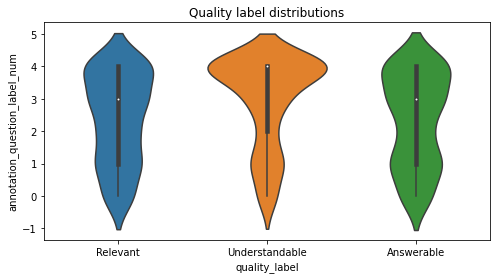

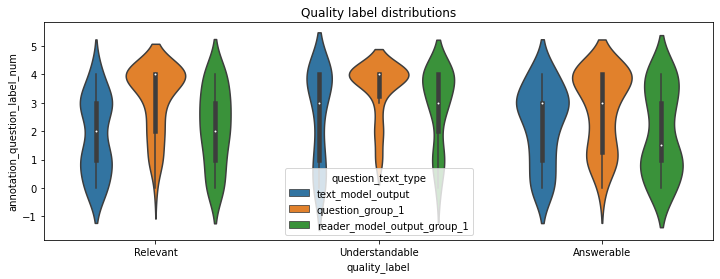

**** testing score = Answerable ****
question type 1 = text_model_output mean=2.260; question type 2 = question_group_1 mean=2.780
question type 1 = text_model_output mean=2.260; question type 2 = reader_model_output_group_1 mean=1.960
question type 1 = question_group_1 mean=2.780; question type 2 = reader_model_output_group_1 mean=1.960
median diff = 1.500 (test stat = 356.5, p = 1.648E-02)
**** testing score = Relevant ****
question type 1 = text_model_output mean=1.840; question type 2 = question_group_1 mean=3.140
median diff = -2.000 (test stat = 40.0, p = 1.711E-06)
question type 1 = text_model_output mean=1.840; question type 2 = reader_model_output_group_1 mean=2.160
question type 1 = question_group_1 mean=3.140; question type 2 = reader_model_output_group_1 mean=2.160
median diff = 2.000 (test stat = 110.5, p = 2.236E-04)
**** testing score = Understandable ****
question type 1 = text_model_output mean=2.540; question type 2 = question_group_1 mean=3.480
median diff = -1.000 (

In [9]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# overall distributions
plt.figure(figsize=(8, 4))
sns.violinplot(data=quality_annotated_data, x='quality_label', y='annotation_question_label_num')
plt.title('Quality label distributions')
plt.show()
# distributions by text type
plt.figure(figsize=(12, 4))
sns.violinplot(data=quality_annotated_data, x='quality_label', y='annotation_question_label_num', hue='question_text_type')
plt.title('Quality label distributions')
plt.show()
## TODO: significance by text type
from scipy.stats import wilcoxon, ttest_rel
question_text_types = quality_annotated_data.loc[:, 'question_text_type'].unique()
p_val_cutoff = 0.05
for score_i, data_i in quality_annotated_data.groupby('quality_label'):
    print(f'**** testing score = {score_i} ****')
    for j, question_text_type_j in enumerate(question_text_types):
        data_j = data_i[data_i.loc[:, 'question_text_type']==question_text_type_j].sort_values(['post_id', 'question_id_1', 'question_id_2'])
        scores_j = data_j[data_j.loc[:, 'quality_label']==score_i].loc[:, 'annotation_question_label_num']
        for question_text_type_k in question_text_types[(j+1):]:
            data_k = data_i[data_i.loc[:, 'question_text_type']==question_text_type_k].sort_values(['post_id', 'question_id_1', 'question_id_2'])
            scores_k = data_k[data_k.loc[:, 'quality_label']==score_i].loc[:, 'annotation_question_label_num']
            median_diff_j_k = scores_j.median() - scores_k.median()
            test_stat, p_val = wilcoxon(scores_j, scores_k)
            print(f'question type 1 = {question_text_type_j} mean={"{:.3f}".format(scores_j.mean())}; question type 2 = {question_text_type_k} mean={"{:.3f}".format(scores_k.mean())}')
            if(p_val < p_val_cutoff):
                print(f'median diff = {"{:.3f}".format(median_diff_j_k)} (test stat = {"{:.1f}".format(test_stat)}, p = {"{:.3E}".format(p_val)})')

- `Relevant`: human > reader-model ~ text-model (mean(reader-model) > mean(text-model))
- `Understandable`: human > reader-model ~ text-model (mean(reader-model) > mean(text-model))
- `Answerable`: human > text-model > reader-model (mean(text-model) > mean(reader-model))

How often did annotators guess the reader group correctly?

ResponseId
R_2DSkWaQ4e9WgAGA    0.5
R_2cj4KxI4AwETFLe    0.6
R_3EYn1o9YqUuVIwm    0.6
R_3oL3epAPgCpZ3Pv    0.7
R_yrpPCUi5DTJyLLP    0.6
dtype: float64


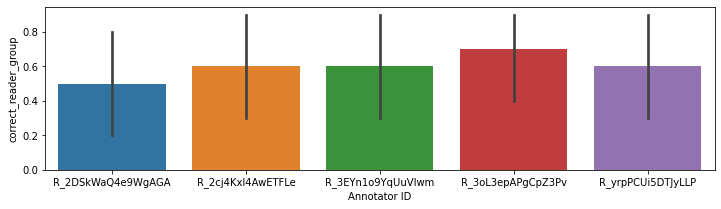

In [10]:
annotator_reader_group_guess_correct_pct = reader_group_annotated_data.groupby('ResponseId').apply(lambda x: x.loc[:, 'correct_reader_group'].mean())
print(annotator_reader_group_guess_correct_pct)
plt.figure(figsize=(12,3))
sns.barplot(data=reader_group_annotated_data, x='ResponseId', y='correct_reader_group')
plt.xlabel('Annotator ID')
plt.show()

Annotators guessed the correct reader group category slightly better than 50% of the time.

How long did each annotator take to finish the task?

In [15]:
import numpy as np
annotator_completion_times = annotated_data[annotated_data.loc[:, 'ResponseId'].isin(reader_group_annotated_data.loc[:, 'ResponseId'].unique())].loc[:, 'Duration (in seconds)']
print(annotator_completion_times)
print(np.mean(annotator_completion_times))

14     787
18     498
22     873
23    6067
27    1114
Name: Duration (in seconds), dtype: int64
1867.8


### Prolific test: domain expertise
Next, we ran a test on Prolific to have domain experts annotate questions from the following subreddits:
- `r/LegalAdvice`
- `r/PCMasterRace`
- `r/PersonalFinance`

Let's check the annotation quality.

In [168]:
import pandas as pd
annotation_data = pd.read_csv('../../data/reddit_data/annotation_data/generated_text_evaluation/compare_model_output/reader_question_generation_prolific_domain_pilot.tsv', sep='\t', index_col=False)
# get rid of leading 1s
import re
Q_col_matcher = re.compile('^1\.')
Q_cols = list(filter(lambda x: Q_col_matcher.match(x) is not None, annotation_data.columns))
annotation_data.rename(columns={x : Q_col_matcher.sub('', x) for x in Q_cols}, inplace=True)
# get clean Q cols
clean_Q_col_matcher = re.compile('^(\d)')
clean_Q_cols = list(filter(lambda x: clean_Q_col_matcher.search(x) is not None, annotation_data.columns))
# print(clean_Q_cols)
# flatten data
flat_annotation_data = pd.melt(annotation_data, id_vars=['ResponseId'], value_vars=clean_Q_cols, value_name='annotation_val', var_name='Q_name')
flat_annotation_data.dropna(subset=['annotation_val'], inplace=True, axis=0)
# clean up column names
# remove final decimals
decimal_ending_matcher = re.compile('\.\d$')
flat_annotation_data = flat_annotation_data.assign(**{
    'Q_name' : flat_annotation_data.loc[:, 'Q_name'].apply(lambda x: decimal_ending_matcher.sub('', x))
})
# add -0 for bare columns
bare_number_matcher = re.compile('^(\d)((?=[\._]\d$)|(?=$))')
flat_annotation_data = flat_annotation_data.assign(**{
    'Q_name' : flat_annotation_data.loc[:, 'Q_name'].apply(lambda x: bare_number_matcher.sub('\\1-0', x))
})
# get rating type
rating_type_lookup = {
    '1' : 'Relevant',
    '2' : 'Understandable',
    '3' : 'Answerable',
}
flat_annotation_data = flat_annotation_data.assign(**{
    'Q_rating_type' : flat_annotation_data.loc[:, 'Q_name'].apply(lambda x: rating_type_lookup.get(x.split('_')[-1]))
})
flat_annotation_data = flat_annotation_data.assign(**{
    'Q_name' : flat_annotation_data.loc[:, 'Q_name'].apply(lambda x: x.split('_')[0])
})
# fix annotation vals for reader group questions
flat_annotation_data = flat_annotation_data.assign(**{
    'annotation_val' : flat_annotation_data.loc[:, 'annotation_val'].apply(lambda x: x.split(':')[0])
})
response_id_subreddit_lookup = {
    'R_3lMsb2DuXC0p5QG' : 'legaladvice',
    'R_1Ojh5qRT5OXmKDO' : 'pcmasterrace',
    'R_33jz6riXVbr3A4H' : 'personalfinance'
}
flat_annotation_data = flat_annotation_data.assign(**{
    'subreddit' : flat_annotation_data.loc[:, 'ResponseId'].apply(response_id_subreddit_lookup.get)
})
display(flat_annotation_data.head(20))

,ResponseId,Q_name,annotation_val,Q_rating_type,subreddit
16,R_3lMsb2DuXC0p5QG,1-0,Very,Relevant,legaladvice
34,R_3lMsb2DuXC0p5QG,1-0,Very,Understandable,legaladvice
52,R_3lMsb2DuXC0p5QG,1-0,Somewhat,Answerable,legaladvice
70,R_3lMsb2DuXC0p5QG,2-0,Not very,Relevant,legaladvice
88,R_3lMsb2DuXC0p5QG,2-0,Very,Understandable,legaladvice
106,R_3lMsb2DuXC0p5QG,2-0,Neutral,Answerable,legaladvice
124,R_3lMsb2DuXC0p5QG,3-0,Neutral,Relevant,legaladvice
142,R_3lMsb2DuXC0p5QG,3-0,Very,Understandable,legaladvice
160,R_3lMsb2DuXC0p5QG,3-0,Somewhat,Answerable,legaladvice
178,R_3lMsb2DuXC0p5QG,4-0,Q2,None,legaladvice


In [150]:
## join with original data
import os
reader_group = 'expert'
annotation_data_dir = '../../data/reddit_data/annotation_data/generated_text_evaluation/compare_model_output/'
annotation_subreddits = list(response_id_subreddit_lookup.values())
annotation_data_files = list(map(lambda x: os.path.join(annotation_data_dir, f'subreddit={x}_group={reader_group}_annotation_data.tsv'), annotation_subreddits))
annotation_true_data = list(map(lambda x: pd.read_csv(x, sep='\t', index_col=False), annotation_data_files))
annotation_true_data = list(map(lambda x: x[0].assign(**{'subreddit' : x[1], 'index' : list(range(x[0].shape[0]))}), zip(annotation_true_data, annotation_subreddits)))
annotation_true_data = pd.concat(annotation_true_data, axis=0)
display(annotation_true_data.head())

,parent_id,post_text,subreddit,group_category,reader_group,Q1.1,Q1.2,Q1.3,Q1.1.type,Q1.2.type,Q1.3.type,Q2.1,Q2.2,Q2.1.type,Q2.2.type,index
0,atd567,"December —my mom was in an accident, and the o...",legaladvice,expert,<EXPERT_PCT_0_AUTHOR>,Was the repair shop one that insurance chose f...,What is your location?,How do you know the shop is closed and it is n...,target_text,reader_model,text_model,What is your location?,Do you have collision coverage on your car?,<EXPERT_PCT_0_AUTHOR>,<EXPERT_PCT_1_AUTHOR>,0
1,9aj6ql,I'm freaking out because School starts for my ...,legaladvice,expert,<EXPERT_PCT_1_AUTHOR>,The kids will be in the same school for the ne...,Did you take the proper steps to enroll them?,Is the child eligible for a public defender?,text_model,target_text,reader_model,Is the child eligible for adoption at this point?,Is the child eligible for a public defender?,<EXPERT_PCT_0_AUTHOR>,<EXPERT_PCT_1_AUTHOR>,1
2,99448p,"Hi all,A few days ago, I was driving to work i...",legaladvice,expert,<EXPERT_PCT_1_AUTHOR>,Did you ever get a police report?,Did you get the ticket in person?,What statute or ordinance were you charged wit...,text_model,reader_model,target_text,Did you get the ticket in person?,Did you pay a fine or not?,<EXPERT_PCT_1_AUTHOR>,<EXPERT_PCT_0_AUTHOR>,2
3,d7bksp,"(Long-winded. Sorry)About two months ago, I re...",legaladvice,expert,<EXPERT_PCT_0_AUTHOR>,Did you ever pay the bill?,Has the debt been sent to collections?,What are the damages you incurred besides bein...,reader_model,text_model,target_text,Did you pay with a credit card?,Did you ever pay the bill?,<EXPERT_PCT_1_AUTHOR>,<EXPERT_PCT_0_AUTHOR>,3
4,b5bady,I work in the hotel industry. Our breakfast ho...,legaladvice,expert,<EXPERT_PCT_0_AUTHOR>,Did you go into your manager’s room and get th...,Do you have any medical bills related to this?,Might be something that changes between counties?,text_model,reader_model,target_text,Do you have any damages?,Do you have any medical bills related to this?,<EXPERT_PCT_1_AUTHOR>,<EXPERT_PCT_0_AUTHOR>,4


In [194]:
## flatten data
# question text
flat_annotation_true_data = pd.melt(annotation_true_data, id_vars=['subreddit', 'post_text', 'parent_id', 'index', 'reader_group'], value_vars=['Q1.1', 'Q1.2', 'Q1.3', 'Q2.1', 'Q2.2'], value_name='question_text', var_name='Q_name')
# question text type
question_text_type_true_data = pd.melt(annotation_true_data, id_vars=['subreddit', 'post_text', 'parent_id', 'index', 'reader_group'], value_vars=['Q1.1.type', 'Q1.2.type', 'Q1.3.type', 'Q2.1.type', 'Q2.2.type'], value_name='question_text_type', var_name='Q_name')
question_text_type_true_data = question_text_type_true_data.assign(**{
    'Q_name' : question_text_type_true_data.loc[:, 'Q_name'].apply(lambda x: x.replace('.type', ''))
})
flat_annotation_true_data = pd.merge(flat_annotation_true_data, question_text_type_true_data,
                                     on=['subreddit', 'post_text', 'parent_id', 'index', 'Q_name', 'reader_group'],
                                     how='left')
# add labels for reader group questions
flat_annotation_true_data = flat_annotation_true_data.assign(**{
    'Q_reader_group' : flat_annotation_true_data.loc[:, 'Q_name'].apply(lambda x: f'Q{x.split(".")[-1]}' if x.startswith('Q2') else None)
})
# fix Q name
# Q_num-idx
Q_name_lookup = {
    '1.1' : '1',
    '1.2' : '2',
    '1.3' : '3',
    '2.1' : '4',
    '2.2' : '4',
}
flat_annotation_true_data = flat_annotation_true_data.assign(**{
    'Q_name' : flat_annotation_true_data.apply(lambda x: f'{Q_name_lookup[x.loc["Q_name"].replace("Q", "")]}-{x.loc["index"]}', axis=1)
})
# for reader-group question: remove questions that aren't associated w/ default values (i.e. incorrect answers)
default_reader_group_vals = ['<EXPERT_PCT_1_AUTHOR>']
question_text_types = ['target_text', 'reader_model', 'text_model']
valid_question_text_types = question_text_types + default_reader_group_vals
flat_annotation_true_data = flat_annotation_true_data[flat_annotation_true_data.loc[:, 'question_text_type'].isin(valid_question_text_types)]
display(flat_annotation_true_data.sort_values(['subreddit', 'index'], inplace=False).head())

,subreddit,post_text,parent_id,index,reader_group,Q_name,question_text,question_text_type,Q_reader_group
0,legaladvice,"December —my mom was in an accident, and the o...",atd567,0,<EXPERT_PCT_0_AUTHOR>,1-0,Was the repair shop one that insurance chose f...,target_text,None
30,legaladvice,"December —my mom was in an accident, and the o...",atd567,0,<EXPERT_PCT_0_AUTHOR>,2-0,What is your location?,reader_model,None
60,legaladvice,"December —my mom was in an accident, and the o...",atd567,0,<EXPERT_PCT_0_AUTHOR>,3-0,How do you know the shop is closed and it is n...,text_model,None
120,legaladvice,"December —my mom was in an accident, and the o...",atd567,0,<EXPERT_PCT_0_AUTHOR>,4-0,Do you have collision coverage on your car?,<EXPERT_PCT_1_AUTHOR>,Q2
1,legaladvice,I'm freaking out because School starts for my ...,9aj6ql,1,<EXPERT_PCT_1_AUTHOR>,1-1,The kids will be in the same school for the ne...,text_model,None


In [190]:
## combine annotation data
combined_annotation_data = pd.merge(flat_annotation_data, flat_annotation_true_data,
                                    on=['subreddit', 'Q_name'], how='left')
# get annotation type
combined_annotation_data = combined_annotation_data.assign(**{
    'annotation_type' : combined_annotation_data.apply(lambda x: 'reader_group' if x.loc['Q_reader_group'] is not None else 'quality', axis=1)
})
display(combined_annotation_data.head())
# split data by type, get numbers!!
combined_quality_annotation_data = combined_annotation_data[combined_annotation_data.loc[:, 'annotation_type']=='quality']
combined_group_annotation_data = combined_annotation_data[combined_annotation_data.loc[:, 'annotation_type']=='reader_group']
quality_num_lookup = {
    'Very' : 5,
    'Somewhat' : 4,
    'Neutral' : 3,
    'Not very' : 2,
    'Not at all' : 1,
}
combined_quality_annotation_data = combined_quality_annotation_data.assign(**{
    'annotation_num' : combined_quality_annotation_data.loc[:, 'annotation_val'].apply(quality_num_lookup.get)
})
combined_group_annotation_data = combined_group_annotation_data.assign(**{
    'annotation_correct' : (combined_group_annotation_data.loc[:, 'annotation_val']==combined_group_annotation_data.loc[:, 'Q_reader_group']).astype(int)
})

,ResponseId,Q_name,annotation_val,Q_rating_type,subreddit,post_text,parent_id,index,reader_group,question_text,question_text_type,Q_reader_group,annotation_type
0,R_3lMsb2DuXC0p5QG,1-0,Very,Relevant,legaladvice,"December —my mom was in an accident, and the o...",atd567,0,<EXPERT_PCT_0_AUTHOR>,Was the repair shop one that insurance chose f...,target_text,None,quality
1,R_3lMsb2DuXC0p5QG,1-0,Very,Understandable,legaladvice,"December —my mom was in an accident, and the o...",atd567,0,<EXPERT_PCT_0_AUTHOR>,Was the repair shop one that insurance chose f...,target_text,None,quality
2,R_3lMsb2DuXC0p5QG,1-0,Somewhat,Answerable,legaladvice,"December —my mom was in an accident, and the o...",atd567,0,<EXPERT_PCT_0_AUTHOR>,Was the repair shop one that insurance chose f...,target_text,None,quality
3,R_3lMsb2DuXC0p5QG,2-0,Not very,Relevant,legaladvice,"December —my mom was in an accident, and the o...",atd567,0,<EXPERT_PCT_0_AUTHOR>,What is your location?,reader_model,None,quality
4,R_3lMsb2DuXC0p5QG,2-0,Very,Understandable,legaladvice,"December —my mom was in an accident, and the o...",atd567,0,<EXPERT_PCT_0_AUTHOR>,What is your location?,reader_model,None,quality


Let's check question quality first:

1. per-subreddit
2. per-model
3. per-subreddit, per-model

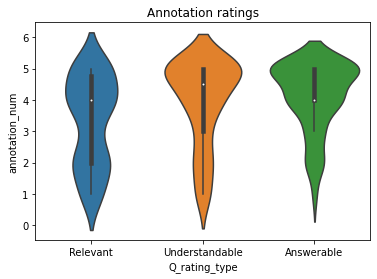

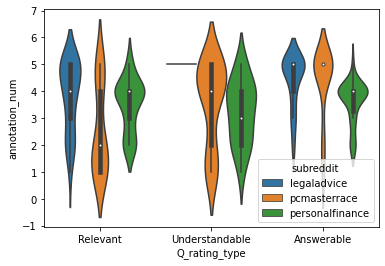

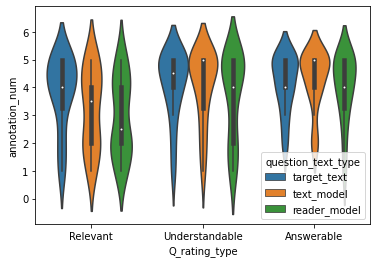

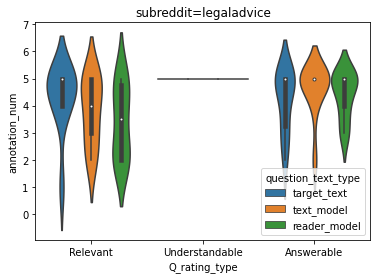

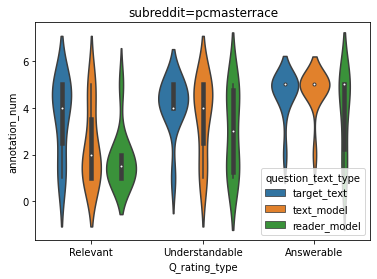

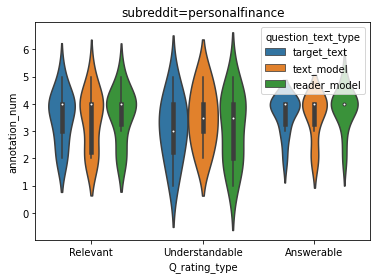

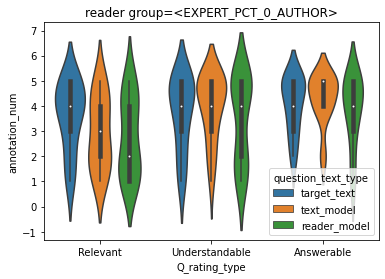

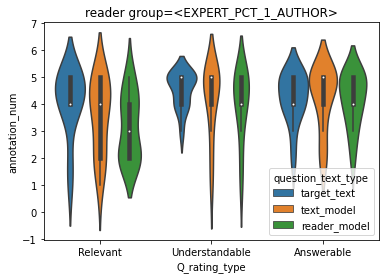

In [191]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
## overall
sns.violinplot(data=combined_quality_annotation_data, x='Q_rating_type', y='annotation_num')
plt.title('Annotation ratings')
plt.show()
## per subreddit
sns.violinplot(data=combined_quality_annotation_data, x='Q_rating_type', y='annotation_num', hue='subreddit')
plt.show()
## per text type
text_type_order = ['target_text', 'text_model', 'reader_model']
sns.violinplot(data=combined_quality_annotation_data, x='Q_rating_type', y='annotation_num', hue='question_text_type', hue_order=text_type_order)
plt.show()
## per subreddit, per model
for subreddit_i, data_i in combined_quality_annotation_data.groupby('subreddit'):
    sns.violinplot(data=data_i, x='Q_rating_type', y='annotation_num', hue='question_text_type', hue_order=text_type_order)
    plt.title(f'subreddit={subreddit_i}')
    plt.show()
## per reader group
for reader_group_i, data_i in combined_quality_annotation_data.groupby('reader_group'):
    sns.violinplot(data=data_i, x='Q_rating_type', y='annotation_num', hue='question_text_type', hue_order=text_type_order)
    plt.title(f'reader group={reader_group_i}')
    plt.show()

Not great! 

For text type, the quality goes:

- `target_text` > `text_model` > `reader_model`

Except in `PersonalFinance` where `target_text` ~ `text_model` ~ `reader_model`.

For subreddits:

- `LegalAdvice` > `PCMasterRace` > `PersonalFinance`

For reader groups, the quality is roughly the same (`novice` ~ `expert`).

What are some example questions from each text type that scored high on a particular dimension?

In [221]:
pd.set_option('display.max_colwidth', 200)
target_text_types = combined_quality_annotation_data.loc[:, 'question_text_type'].unique()
sample_size = 5
for score_type_i, data_i in combined_quality_annotation_data.groupby('Q_rating_type'):
    print(f'**** score = {score_type_i} ****')
    # find example Qs with high scores for target text
    scores_i = data_i.groupby(['parent_id', 'question_text_type']).apply(lambda x: x.loc[:, 'annotation_num'].mean()).reset_index(name='annotation_num')
#     print(scores_i)
    for target_text_j in target_text_types:
        print(f'\t** target text = {target_text_j} **')
        high_score_ids_j = scores_i.groupby('parent_id').apply(lambda x: x[x.loc[:, 'question_text_type']==target_text_j].loc[:, 'annotation_num'].iloc[0]>x.loc[:, 'annotation_num'].min())
        high_score_ids_j = high_score_ids_j[high_score_ids_j].index.tolist()[:sample_size]
        # show all text types and scores for selected IDs
        high_score_data_j = data_i[data_i.loc[:, 'parent_id'].isin(high_score_ids_j)]
        for id_k, data_k in high_score_data_j.groupby('parent_id'):
            data_k.sort_values('annotation_num', inplace=True, ascending=False)
            print(f'\tsubreddit = {data_k.loc[:, "subreddit"].iloc[0]}; post = {data_k.loc[:, "post_text"].iloc[0]}')
            display(data_k.loc[:, ['question_text_type', 'question_text', 'annotation_num']])

**** score = Answerable ****
	** target text = target_text **
	subreddit = personalfinance; post = Hello r/personalfinance,Backstory on me, currently make 65k a year (just started this job 4 months ago was making 35k prior to that) and my wife makes 30k a year before taxes. Our finances aren't in the best shape but we do have a credit rating in the mid 700, for me 739 last I checked. We've been a little reckless but have straightened out having about 20k in savings. We currently live in one of the houses my parents own with my wife. Rent free life has been nice the past 15 months but we are ready to make the next move.I am looking at buying a vacant lot that I came across the other day, it's in an area that is being revitalized in Houston and the piece of land is fairly cheap compared to surrounding areas. Houston is known for it's flooding so i checked flood maps and it is not in a flood plain and didn't flood during Hurricane Harvey though crime is a bit high but on a downward trend.

,question_text_type,question_text,annotation_num
272,target_text,How much do you two have saved in retirement accounts?,4
275,reader_model,Do you have any other assets you can sell to help reduce the cost of the equity?,4
278,text_model,"If you can't afford to buy a house, is there someone who can loan you the money to help you?",3


	subreddit = personalfinance; post = Hi guys, I’ve been having a lot of trouble with this over the past few days so I really need your help.I used to live in a different city and go to a gym. I quit the gym over a year and half ago, but as i notice in June that they started charging my card. I talked to the gym and they said they would refund the money but they didn’t and instead I got charged again in July and in August. I’ve called and had the same conversation with them many times; nothings happened. So I called my credit card company and filed a chargeback claim against the gym for the past few months; however they keep charging my card. I want to dance this card so that they can’t charge me or is there another way of doing this? I can’t go talk to the people at the gym in person because it is on the side of the country. Thanks for your help in advance.


,question_text_type,question_text,annotation_num
242,target_text,Did you get your card through a bank/credit union?,4
245,text_model,Did you provide them your account information at some point?,4
248,reader_model,Did you sign up for new or new service?,3


	subreddit = legaladvice; post = I'm freaking out because School starts for my twins tomorrow in PA in My district. Their mother said that she is not taking them because the school said there were not registered. I have a Interim stipulation that states the Girls WILL go to the same school they have for the last 3-4 Years. This is a B+ school and the school she is trying to sign them into is a C- via [niche.com](https://neich.com) . we have 50/50 Legal custody and the girls want to stay here with me. I have them ATM Friday, Sat and Sunday. I have no idea how to go about   "Fixing this" My lawyer has been MIA for a week Out of the OFFICE after I payed him.&amp;#x200B;I have looked at the PA Code and Obviously I of no legal mind but if common judgement is corrected the [this ](https://www.pacode.com/secure/data/022/chapter11/s11.11.html)section of the legal code states that the school must follow my Custody arrangement. &amp;#x200B;Also if she does not take them to the school tomorrow is

,question_text_type,question_text,annotation_num
12,text_model,The kids will be in the same school for the next 3-4 years?,5
15,target_text,Did you take the proper steps to enroll them?,5
18,reader_model,Is the child eligible for a public defender?,3


	subreddit = legaladvice; post = Long story shortMy SO and I are married and work at different municipalities. Both require us to be a resident of that said municipality. Are there any precedents or preferable statues that apply to this situation when it comes to married couples and residency?Surely it would be some sort of marriage discrimination to expect a residency for two places?


,question_text_type,question_text,annotation_num
85,text_model,Is one of you a long-term resident of the United States?,5
88,target_text,They were either in place when you got married or when one/both of you accepted your positions?,5
82,reader_model,Is there a reason why you don’t want to?,4


	subreddit = personalfinance; post = first time poster here. So i have a ROTH IRA account with etrade, about $700. It is just sitting there.  do you think its a good idea to concurrently transfer over a few hundred dollars a month to this account from my bank checking and then buy funds/stock and start investing? Any thoughts on how to utilize this ROTH IRA?&amp;#x200B;&amp;#x200B;


,question_text_type,question_text,annotation_num
258,target_text,How much is your job income?,4
252,text_model,What is the time frame?,2
255,reader_model,Do you have a 401k at work?,2


	** target text = reader_model **
	subreddit = personalfinance; post = Hello r/personalfinance,Backstory on me, currently make 65k a year (just started this job 4 months ago was making 35k prior to that) and my wife makes 30k a year before taxes. Our finances aren't in the best shape but we do have a credit rating in the mid 700, for me 739 last I checked. We've been a little reckless but have straightened out having about 20k in savings. We currently live in one of the houses my parents own with my wife. Rent free life has been nice the past 15 months but we are ready to make the next move.I am looking at buying a vacant lot that I came across the other day, it's in an area that is being revitalized in Houston and the piece of land is fairly cheap compared to surrounding areas. Houston is known for it's flooding so i checked flood maps and it is not in a flood plain and didn't flood during Hurricane Harvey though crime is a bit high but on a downward trend. I don't know the first thin

,question_text_type,question_text,annotation_num
272,target_text,How much do you two have saved in retirement accounts?,4
275,reader_model,Do you have any other assets you can sell to help reduce the cost of the equity?,4
278,text_model,"If you can't afford to buy a house, is there someone who can loan you the money to help you?",3


	subreddit = pcmasterrace; post = I have a new pc, ryzen 7 2700x, rtx 2080 noctua nhd15s air cooling. I feel hot and checked temperature... I hit cpu max 88°c and gpu max 85°c. Case is phantek p300


,question_text_type,question_text,annotation_num
132,text_model,What case do you have?,5
138,reader_model,Are you sure that your CPU is indeed at 3.9GHz?,5
135,target_text,Ramping in speed with the temperature ?,4


	subreddit = personalfinance; post = Does anybody have experience with using this method to pay off their house? Would like to hear your experience with it. I'm a numbers guy who loves to look at graphs and compare ROIs. Videos or articles I've read only approximate and don't fully explain the concept. Im in the process of making my own excel sheet for it but i don't quite understand how to calculate credit interest payments as well as I should. Does anybody have any tools or resources they'd recommend?


,question_text_type,question_text,annotation_num
292,text_model,Is there a reason you need to do this?,4
295,reader_model,What is your credit score?,4
298,target_text,[Is this what you mean?,3


	subreddit = personalfinance; post = I'm a web developer (age 32) making $65,000 / year. I have about $20k in savings and completely own an apt in a co-op (mortgage is paid off -- but I do pay $700 / month in maintenance fees). &amp;#x200B;My place is currently valued at $140k, but I have no money saved in a retirement fund / 401k. &amp;#x200B;I'm now looking to move in with my fiance -- here's what my plans are -- and I was hoping to get your opinion. &amp;#x200B;I did the math, and if we were to move in together and put down $130 - $140k on a place, we can do a 30-year mortgage and only have to pay about $500 / month each (remember I'm currently paying $700 / month for maintenance fees). &amp;#x200B;We can both afford $1,000 / month each easily, so I figured we can both put in $500 / month for the mortgage, while taking the other $500 each and saving that toward buying another place (1k / month). After 6 - 7 years, we'd be able to put a decent down payment on another apt and rent tha

,question_text_type,question_text,annotation_num
202,target_text,Or is it going to be a rental property?,4
205,reader_model,What's the interest rate on the student loans?,4
208,text_model,Are you planning on living in the same place for 5-10 years?,2


	subreddit = pcmasterrace; post = I see Nvidia selling it as some revolutionizing technology for the gaming industry, and i'm not saying that it isn't, but is it really that important? It just seems that they are blowing it out of proportion and it doesn't really make that much of a difference. I might get downvoted for this, but I want to hear other peoples opinions on the matter. 


,question_text_type,question_text,annotation_num
192,reader_model,What sort of advice are you looking for?,3
195,target_text,"Anything new and fancy is going to be expensive, guess how much the first consumer computers were?",2
198,text_model,"I mean, is nvidia going to do this all out of proportion?",2


	** target text = text_model **
	subreddit = personalfinance; post = Hi guys, I’ve been having a lot of trouble with this over the past few days so I really need your help.I used to live in a different city and go to a gym. I quit the gym over a year and half ago, but as i notice in June that they started charging my card. I talked to the gym and they said they would refund the money but they didn’t and instead I got charged again in July and in August. I’ve called and had the same conversation with them many times; nothings happened. So I called my credit card company and filed a chargeback claim against the gym for the past few months; however they keep charging my card. I want to dance this card so that they can’t charge me or is there another way of doing this? I can’t go talk to the people at the gym in person because it is on the side of the country. Thanks for your help in advance.


,question_text_type,question_text,annotation_num
242,target_text,Did you get your card through a bank/credit union?,4
245,text_model,Did you provide them your account information at some point?,4
248,reader_model,Did you sign up for new or new service?,3


	subreddit = legaladvice; post = I'm freaking out because School starts for my twins tomorrow in PA in My district. Their mother said that she is not taking them because the school said there were not registered. I have a Interim stipulation that states the Girls WILL go to the same school they have for the last 3-4 Years. This is a B+ school and the school she is trying to sign them into is a C- via [niche.com](https://neich.com) . we have 50/50 Legal custody and the girls want to stay here with me. I have them ATM Friday, Sat and Sunday. I have no idea how to go about   "Fixing this" My lawyer has been MIA for a week Out of the OFFICE after I payed him.&amp;#x200B;I have looked at the PA Code and Obviously I of no legal mind but if common judgement is corrected the [this ](https://www.pacode.com/secure/data/022/chapter11/s11.11.html)section of the legal code states that the school must follow my Custody arrangement. &amp;#x200B;Also if she does not take them to the school tomorrow is

,question_text_type,question_text,annotation_num
12,text_model,The kids will be in the same school for the next 3-4 years?,5
15,target_text,Did you take the proper steps to enroll them?,5
18,reader_model,Is the child eligible for a public defender?,3


	subreddit = legaladvice; post = Long story shortMy SO and I are married and work at different municipalities. Both require us to be a resident of that said municipality. Are there any precedents or preferable statues that apply to this situation when it comes to married couples and residency?Surely it would be some sort of marriage discrimination to expect a residency for two places?


,question_text_type,question_text,annotation_num
85,text_model,Is one of you a long-term resident of the United States?,5
88,target_text,They were either in place when you got married or when one/both of you accepted your positions?,5
82,reader_model,Is there a reason why you don’t want to?,4


	subreddit = pcmasterrace; post = I have a new pc, ryzen 7 2700x, rtx 2080 noctua nhd15s air cooling. I feel hot and checked temperature... I hit cpu max 88°c and gpu max 85°c. Case is phantek p300


,question_text_type,question_text,annotation_num
132,text_model,What case do you have?,5
138,reader_model,Are you sure that your CPU is indeed at 3.9GHz?,5
135,target_text,Ramping in speed with the temperature ?,4


	subreddit = personalfinance; post = Does anybody have experience with using this method to pay off their house? Would like to hear your experience with it. I'm a numbers guy who loves to look at graphs and compare ROIs. Videos or articles I've read only approximate and don't fully explain the concept. Im in the process of making my own excel sheet for it but i don't quite understand how to calculate credit interest payments as well as I should. Does anybody have any tools or resources they'd recommend?


,question_text_type,question_text,annotation_num
292,text_model,Is there a reason you need to do this?,4
295,reader_model,What is your credit score?,4
298,target_text,[Is this what you mean?,3


**** score = Relevant ****
	** target text = target_text **
	subreddit = personalfinance; post = Hello r/personalfinance,Backstory on me, currently make 65k a year (just started this job 4 months ago was making 35k prior to that) and my wife makes 30k a year before taxes. Our finances aren't in the best shape but we do have a credit rating in the mid 700, for me 739 last I checked. We've been a little reckless but have straightened out having about 20k in savings. We currently live in one of the houses my parents own with my wife. Rent free life has been nice the past 15 months but we are ready to make the next move.I am looking at buying a vacant lot that I came across the other day, it's in an area that is being revitalized in Houston and the piece of land is fairly cheap compared to surrounding areas. Houston is known for it's flooding so i checked flood maps and it is not in a flood plain and didn't flood during Hurricane Harvey though crime is a bit high but on a downward trend. I

,question_text_type,question_text,annotation_num
270,target_text,How much do you two have saved in retirement accounts?,4
273,reader_model,Do you have any other assets you can sell to help reduce the cost of the equity?,4
276,text_model,"If you can't afford to buy a house, is there someone who can loan you the money to help you?",2


	subreddit = pcmasterrace; post = HI guys I recently bought a mining gpu off of eBay for gaming and was hoping to get some information on how to convert it back to its original bios. When I Google it all I get is how to put mining bios on cards. My card is an Asus Strix Rx 480 8gb model. I've tried installing the bios update from the main site, but that doesn't remove the mining one.


,question_text_type,question_text,annotation_num
113,target_text,"I'm curious, why did you buy a mining GPU for gaming?",5
116,text_model,What does it say in device manager?,5
110,reader_model,Did you buy the power supply new?,1


	subreddit = legaladvice; post = Hi all,A few days ago, I was driving to work in the morning and an SUV cut in front of me at an excessive speed where there was barely enough space between myself and the other car.I honked my horn (admittedly a bit long and out of frustration) and then noticed police were standing at the corner lasering cars for speed. I honked my horn again, because it didn't look like the police was going to stop the car in front of me, and to my surprise they pulled both of us aside.I believe the other car got written up for their speed and the fact that he cut me off and put me in a dangerous situation, but I was baffled when the officer said I was also getting a $136 fine for "improper horn use".I explained that yes, I honked longer than necessary out of frustration, but that didn't seem to matter much.What's the best course of action now? I got the infraction ticket at home, with an option for a Mitigation Hearing, but I don't know what my chances of success are 

,question_text_type,question_text,annotation_num
20,text_model,Did you ever get a police report?,5
26,target_text,What statute or ordinance were you charged with violating?,5
23,reader_model,Did you get the ticket in person?,4


	subreddit = legaladvice; post = I'm freaking out because School starts for my twins tomorrow in PA in My district. Their mother said that she is not taking them because the school said there were not registered. I have a Interim stipulation that states the Girls WILL go to the same school they have for the last 3-4 Years. This is a B+ school and the school she is trying to sign them into is a C- via [niche.com](https://neich.com) . we have 50/50 Legal custody and the girls want to stay here with me. I have them ATM Friday, Sat and Sunday. I have no idea how to go about   "Fixing this" My lawyer has been MIA for a week Out of the OFFICE after I payed him.&amp;#x200B;I have looked at the PA Code and Obviously I of no legal mind but if common judgement is corrected the [this ](https://www.pacode.com/secure/data/022/chapter11/s11.11.html)section of the legal code states that the school must follow my Custody arrangement. &amp;#x200B;Also if she does not take them to the school tomorrow is

,question_text_type,question_text,annotation_num
13,target_text,Did you take the proper steps to enroll them?,5
10,text_model,The kids will be in the same school for the next 3-4 years?,4
16,reader_model,Is the child eligible for a public defender?,4


	subreddit = legaladvice; post = Long story shortMy SO and I are married and work at different municipalities. Both require us to be a resident of that said municipality. Are there any precedents or preferable statues that apply to this situation when it comes to married couples and residency?Surely it would be some sort of marriage discrimination to expect a residency for two places?


,question_text_type,question_text,annotation_num
86,target_text,They were either in place when you got married or when one/both of you accepted your positions?,5
83,text_model,Is one of you a long-term resident of the United States?,4
80,reader_model,Is there a reason why you don’t want to?,2


	** target text = reader_model **
	subreddit = personalfinance; post = Hello r/personalfinance,Backstory on me, currently make 65k a year (just started this job 4 months ago was making 35k prior to that) and my wife makes 30k a year before taxes. Our finances aren't in the best shape but we do have a credit rating in the mid 700, for me 739 last I checked. We've been a little reckless but have straightened out having about 20k in savings. We currently live in one of the houses my parents own with my wife. Rent free life has been nice the past 15 months but we are ready to make the next move.I am looking at buying a vacant lot that I came across the other day, it's in an area that is being revitalized in Houston and the piece of land is fairly cheap compared to surrounding areas. Houston is known for it's flooding so i checked flood maps and it is not in a flood plain and didn't flood during Hurricane Harvey though crime is a bit high but on a downward trend. I don't know the first thin

,question_text_type,question_text,annotation_num
270,target_text,How much do you two have saved in retirement accounts?,4
273,reader_model,Do you have any other assets you can sell to help reduce the cost of the equity?,4
276,text_model,"If you can't afford to buy a house, is there someone who can loan you the money to help you?",2


	subreddit = pcmasterrace; post = I have a new pc, ryzen 7 2700x, rtx 2080 noctua nhd15s air cooling. I feel hot and checked temperature... I hit cpu max 88°c and gpu max 85°c. Case is phantek p300


,question_text_type,question_text,annotation_num
133,target_text,Ramping in speed with the temperature ?,4
136,reader_model,Are you sure that your CPU is indeed at 3.9GHz?,2
130,text_model,What case do you have?,1


	subreddit = personalfinance; post = Does anybody have experience with using this method to pay off their house? Would like to hear your experience with it. I'm a numbers guy who loves to look at graphs and compare ROIs. Videos or articles I've read only approximate and don't fully explain the concept. Im in the process of making my own excel sheet for it but i don't quite understand how to calculate credit interest payments as well as I should. Does anybody have any tools or resources they'd recommend?


,question_text_type,question_text,annotation_num
290,text_model,Is there a reason you need to do this?,4
293,reader_model,What is your credit score?,4
296,target_text,[Is this what you mean?,3


	subreddit = personalfinance; post = I'm a web developer (age 32) making $65,000 / year. I have about $20k in savings and completely own an apt in a co-op (mortgage is paid off -- but I do pay $700 / month in maintenance fees). &amp;#x200B;My place is currently valued at $140k, but I have no money saved in a retirement fund / 401k. &amp;#x200B;I'm now looking to move in with my fiance -- here's what my plans are -- and I was hoping to get your opinion. &amp;#x200B;I did the math, and if we were to move in together and put down $130 - $140k on a place, we can do a 30-year mortgage and only have to pay about $500 / month each (remember I'm currently paying $700 / month for maintenance fees). &amp;#x200B;We can both afford $1,000 / month each easily, so I figured we can both put in $500 / month for the mortgage, while taking the other $500 each and saving that toward buying another place (1k / month). After 6 - 7 years, we'd be able to put a decent down payment on another apt and rent tha

,question_text_type,question_text,annotation_num
203,reader_model,What's the interest rate on the student loans?,4
200,target_text,Or is it going to be a rental property?,3
206,text_model,Are you planning on living in the same place for 5-10 years?,3


	subreddit = pcmasterrace; post = I see Nvidia selling it as some revolutionizing technology for the gaming industry, and i'm not saying that it isn't, but is it really that important? It just seems that they are blowing it out of proportion and it doesn't really make that much of a difference. I might get downvoted for this, but I want to hear other peoples opinions on the matter. 


,question_text_type,question_text,annotation_num
190,reader_model,What sort of advice are you looking for?,2
196,text_model,"I mean, is nvidia going to do this all out of proportion?",2
193,target_text,"Anything new and fancy is going to be expensive, guess how much the first consumer computers were?",1


	** target text = text_model **
	subreddit = pcmasterrace; post = HI guys I recently bought a mining gpu off of eBay for gaming and was hoping to get some information on how to convert it back to its original bios. When I Google it all I get is how to put mining bios on cards. My card is an Asus Strix Rx 480 8gb model. I've tried installing the bios update from the main site, but that doesn't remove the mining one.


,question_text_type,question_text,annotation_num
113,target_text,"I'm curious, why did you buy a mining GPU for gaming?",5
116,text_model,What does it say in device manager?,5
110,reader_model,Did you buy the power supply new?,1


	subreddit = legaladvice; post = Hi all,A few days ago, I was driving to work in the morning and an SUV cut in front of me at an excessive speed where there was barely enough space between myself and the other car.I honked my horn (admittedly a bit long and out of frustration) and then noticed police were standing at the corner lasering cars for speed. I honked my horn again, because it didn't look like the police was going to stop the car in front of me, and to my surprise they pulled both of us aside.I believe the other car got written up for their speed and the fact that he cut me off and put me in a dangerous situation, but I was baffled when the officer said I was also getting a $136 fine for "improper horn use".I explained that yes, I honked longer than necessary out of frustration, but that didn't seem to matter much.What's the best course of action now? I got the infraction ticket at home, with an option for a Mitigation Hearing, but I don't know what my chances of success are 

,question_text_type,question_text,annotation_num
20,text_model,Did you ever get a police report?,5
26,target_text,What statute or ordinance were you charged with violating?,5
23,reader_model,Did you get the ticket in person?,4


	subreddit = legaladvice; post = Long story shortMy SO and I are married and work at different municipalities. Both require us to be a resident of that said municipality. Are there any precedents or preferable statues that apply to this situation when it comes to married couples and residency?Surely it would be some sort of marriage discrimination to expect a residency for two places?


,question_text_type,question_text,annotation_num
86,target_text,They were either in place when you got married or when one/both of you accepted your positions?,5
83,text_model,Is one of you a long-term resident of the United States?,4
80,reader_model,Is there a reason why you don’t want to?,2


	subreddit = pcmasterrace; post = &amp;#x200B;[?](https://i.redd.it/zz1wo7fp44v11.png)&amp;#x200B;Hi guys , before we start ,, just ignore the '' benchmark not complete'' it was evga running that caused that error.. Regardless, my pc is running on low fps , i did a benchmark and i was not quite impressed. I see people with rigs worse than mine , and they get more fps / better fps / benchmarks. Why is my pc not getting good benchmarks &amp;#x200B;I see people that has the exact same / worse rigs than mine , and on their GPU they get on dx10 like 90% usage . That is my main concern , the GPU usage , and maybe CPU aswell. How can they get like 90%gpu usage ? &amp;#x200B;ThanksKevin


,question_text_type,question_text,annotation_num
150,target_text,What performance do you get exactly ?,5
156,text_model,- Do you have access to the Nvidia control panel?,4
153,reader_model,What is your use case for this computer?,2


	subreddit = personalfinance; post = Does anybody have experience with using this method to pay off their house? Would like to hear your experience with it. I'm a numbers guy who loves to look at graphs and compare ROIs. Videos or articles I've read only approximate and don't fully explain the concept. Im in the process of making my own excel sheet for it but i don't quite understand how to calculate credit interest payments as well as I should. Does anybody have any tools or resources they'd recommend?


,question_text_type,question_text,annotation_num
290,text_model,Is there a reason you need to do this?,4
293,reader_model,What is your credit score?,4
296,target_text,[Is this what you mean?,3


**** score = Understandable ****
	** target text = target_text **
	subreddit = personalfinance; post = Hello r/personalfinance,Backstory on me, currently make 65k a year (just started this job 4 months ago was making 35k prior to that) and my wife makes 30k a year before taxes. Our finances aren't in the best shape but we do have a credit rating in the mid 700, for me 739 last I checked. We've been a little reckless but have straightened out having about 20k in savings. We currently live in one of the houses my parents own with my wife. Rent free life has been nice the past 15 months but we are ready to make the next move.I am looking at buying a vacant lot that I came across the other day, it's in an area that is being revitalized in Houston and the piece of land is fairly cheap compared to surrounding areas. Houston is known for it's flooding so i checked flood maps and it is not in a flood plain and didn't flood during Hurricane Harvey though crime is a bit high but on a downward tr

,question_text_type,question_text,annotation_num
271,target_text,How much do you two have saved in retirement accounts?,4
274,reader_model,Do you have any other assets you can sell to help reduce the cost of the equity?,4
277,text_model,"If you can't afford to buy a house, is there someone who can loan you the money to help you?",3


	subreddit = pcmasterrace; post = HI guys I recently bought a mining gpu off of eBay for gaming and was hoping to get some information on how to convert it back to its original bios. When I Google it all I get is how to put mining bios on cards. My card is an Asus Strix Rx 480 8gb model. I've tried installing the bios update from the main site, but that doesn't remove the mining one.


,question_text_type,question_text,annotation_num
117,text_model,What does it say in device manager?,5
114,target_text,"I'm curious, why did you buy a mining GPU for gaming?",4
111,reader_model,Did you buy the power supply new?,1


	subreddit = personalfinance; post = first time poster here. So i have a ROTH IRA account with etrade, about $700. It is just sitting there.  do you think its a good idea to concurrently transfer over a few hundred dollars a month to this account from my bank checking and then buy funds/stock and start investing? Any thoughts on how to utilize this ROTH IRA?&amp;#x200B;&amp;#x200B;


,question_text_type,question_text,annotation_num
257,target_text,How much is your job income?,4
251,text_model,What is the time frame?,2
254,reader_model,Do you have a 401k at work?,1


	subreddit = pcmasterrace; post = I have a new pc, ryzen 7 2700x, rtx 2080 noctua nhd15s air cooling. I feel hot and checked temperature... I hit cpu max 88°c and gpu max 85°c. Case is phantek p300


,question_text_type,question_text,annotation_num
134,target_text,Ramping in speed with the temperature ?,4
137,reader_model,Are you sure that your CPU is indeed at 3.9GHz?,2
131,text_model,What case do you have?,1


	subreddit = pcmasterrace; post = &amp;#x200B;[?](https://i.redd.it/zz1wo7fp44v11.png)&amp;#x200B;Hi guys , before we start ,, just ignore the '' benchmark not complete'' it was evga running that caused that error.. Regardless, my pc is running on low fps , i did a benchmark and i was not quite impressed. I see people with rigs worse than mine , and they get more fps / better fps / benchmarks. Why is my pc not getting good benchmarks &amp;#x200B;I see people that has the exact same / worse rigs than mine , and on their GPU they get on dx10 like 90% usage . That is my main concern , the GPU usage , and maybe CPU aswell. How can they get like 90%gpu usage ? &amp;#x200B;ThanksKevin


,question_text_type,question_text,annotation_num
151,target_text,What performance do you get exactly ?,5
157,text_model,- Do you have access to the Nvidia control panel?,5
154,reader_model,What is your use case for this computer?,4


	** target text = reader_model **
	subreddit = personalfinance; post = Hello r/personalfinance,Backstory on me, currently make 65k a year (just started this job 4 months ago was making 35k prior to that) and my wife makes 30k a year before taxes. Our finances aren't in the best shape but we do have a credit rating in the mid 700, for me 739 last I checked. We've been a little reckless but have straightened out having about 20k in savings. We currently live in one of the houses my parents own with my wife. Rent free life has been nice the past 15 months but we are ready to make the next move.I am looking at buying a vacant lot that I came across the other day, it's in an area that is being revitalized in Houston and the piece of land is fairly cheap compared to surrounding areas. Houston is known for it's flooding so i checked flood maps and it is not in a flood plain and didn't flood during Hurricane Harvey though crime is a bit high but on a downward trend. I don't know the first thin

,question_text_type,question_text,annotation_num
271,target_text,How much do you two have saved in retirement accounts?,4
274,reader_model,Do you have any other assets you can sell to help reduce the cost of the equity?,4
277,text_model,"If you can't afford to buy a house, is there someone who can loan you the money to help you?",3


	subreddit = personalfinance; post = Long story short, husband and I have been spending just under $2k/month on groceries and restaurants. Majority tends to come from eating out (approx $1,200) and groceries ($700). The remaining $100 is for coffee and misc. convenience store items. Clearly this number is embarrassingly high and I'd like to bring the total under $1k for September. We just moved to a new neighborhood and have tried taking advantage of BYOB spots where the total bill comes to \~$70 total, compared to the $120+ when drinks are involved. This hasn't worked out as well as we planned, however to reduce our total expense. I do a lot of grocery shopping at Whole Foods and value organic items. I'm certainly not opposed to shopping at Trader Joe's or even Aldi for good quality items. I tend to be an all or nothing kind of person and am considering challenging ourselves to eat in for every dinner during the month of September. Lunches are free reign (gotta start somewhere) and hu

,question_text_type,question_text,annotation_num
287,reader_model,Do you have a budget?,4
281,target_text,What’s the rest of your financial situation look like?,3
284,text_model,What are you planning on eating?,3


	subreddit = pcmasterrace; post = I have a new pc, ryzen 7 2700x, rtx 2080 noctua nhd15s air cooling. I feel hot and checked temperature... I hit cpu max 88°c and gpu max 85°c. Case is phantek p300


,question_text_type,question_text,annotation_num
134,target_text,Ramping in speed with the temperature ?,4
137,reader_model,Are you sure that your CPU is indeed at 3.9GHz?,2
131,text_model,What case do you have?,1


	subreddit = personalfinance; post = Does anybody have experience with using this method to pay off their house? Would like to hear your experience with it. I'm a numbers guy who loves to look at graphs and compare ROIs. Videos or articles I've read only approximate and don't fully explain the concept. Im in the process of making my own excel sheet for it but i don't quite understand how to calculate credit interest payments as well as I should. Does anybody have any tools or resources they'd recommend?


,question_text_type,question_text,annotation_num
291,text_model,Is there a reason you need to do this?,4
294,reader_model,What is your credit score?,4
297,target_text,[Is this what you mean?,3


	subreddit = personalfinance; post = My wife (34) and I (40) want to make it work out where I quit my job and stay home. Our plan is for June September of 2020. By then, we will have all credit cards paid off, downsize to one car and my wife has opportunities for job advancement. My questions are: I have PERS 3 in WA with about $65000 in it. Do I leave it there, so it can grow for the next 22 years and I can get all the retirement I can from it? Roll it over into a Roth? Cash it out?Also, I have a deferred comp plan with about $10,000 that I contribute $100 a pay check to.  Keep it? Cash it out? Keep contributing the $100 for the next 16 months or put that $100 into my savings?So many questions, but thank you in advance. 


,question_text_type,question_text,annotation_num
261,reader_model,How much do you have saved in your retirement?,5
267,text_model,Do you have a high deductible health plan?,5
264,target_text,Is that a pension plan for teachers in your state?,1


	** target text = text_model **
	subreddit = pcmasterrace; post = HI guys I recently bought a mining gpu off of eBay for gaming and was hoping to get some information on how to convert it back to its original bios. When I Google it all I get is how to put mining bios on cards. My card is an Asus Strix Rx 480 8gb model. I've tried installing the bios update from the main site, but that doesn't remove the mining one.


,question_text_type,question_text,annotation_num
117,text_model,What does it say in device manager?,5
114,target_text,"I'm curious, why did you buy a mining GPU for gaming?",4
111,reader_model,Did you buy the power supply new?,1


	subreddit = personalfinance; post = Hi guys, I’ve been having a lot of trouble with this over the past few days so I really need your help.I used to live in a different city and go to a gym. I quit the gym over a year and half ago, but as i notice in June that they started charging my card. I talked to the gym and they said they would refund the money but they didn’t and instead I got charged again in July and in August. I’ve called and had the same conversation with them many times; nothings happened. So I called my credit card company and filed a chargeback claim against the gym for the past few months; however they keep charging my card. I want to dance this card so that they can’t charge me or is there another way of doing this? I can’t go talk to the people at the gym in person because it is on the side of the country. Thanks for your help in advance.


,question_text_type,question_text,annotation_num
244,text_model,Did you provide them your account information at some point?,4
241,target_text,Did you get your card through a bank/credit union?,2
247,reader_model,Did you sign up for new or new service?,2


	subreddit = personalfinance; post = first time poster here. So i have a ROTH IRA account with etrade, about $700. It is just sitting there.  do you think its a good idea to concurrently transfer over a few hundred dollars a month to this account from my bank checking and then buy funds/stock and start investing? Any thoughts on how to utilize this ROTH IRA?&amp;#x200B;&amp;#x200B;


,question_text_type,question_text,annotation_num
257,target_text,How much is your job income?,4
251,text_model,What is the time frame?,2
254,reader_model,Do you have a 401k at work?,1


	subreddit = pcmasterrace; post = &amp;#x200B;[?](https://i.redd.it/zz1wo7fp44v11.png)&amp;#x200B;Hi guys , before we start ,, just ignore the '' benchmark not complete'' it was evga running that caused that error.. Regardless, my pc is running on low fps , i did a benchmark and i was not quite impressed. I see people with rigs worse than mine , and they get more fps / better fps / benchmarks. Why is my pc not getting good benchmarks &amp;#x200B;I see people that has the exact same / worse rigs than mine , and on their GPU they get on dx10 like 90% usage . That is my main concern , the GPU usage , and maybe CPU aswell. How can they get like 90%gpu usage ? &amp;#x200B;ThanksKevin


,question_text_type,question_text,annotation_num
151,target_text,What performance do you get exactly ?,5
157,text_model,- Do you have access to the Nvidia control panel?,5
154,reader_model,What is your use case for this computer?,4


	subreddit = personalfinance; post = Does anybody have experience with using this method to pay off their house? Would like to hear your experience with it. I'm a numbers guy who loves to look at graphs and compare ROIs. Videos or articles I've read only approximate and don't fully explain the concept. Im in the process of making my own excel sheet for it but i don't quite understand how to calculate credit interest payments as well as I should. Does anybody have any tools or resources they'd recommend?


,question_text_type,question_text,annotation_num
291,text_model,Is there a reason you need to do this?,4
294,reader_model,What is your credit score?,4
297,target_text,[Is this what you mean?,3


- `Answerable`
    - `target_text`: posts are either complicated or have minimal details, which the ground-truth question would be better at asessing (`How much is your job income?`)
    - `reader_model`: question generally ties with `text_model` or `target_text`, and it's simpler/more reflective (`what sort of advice are you looking for?`)
    - `text_model`: question identifies relevant details, answer is likely simple (`is one of you a long-term resident of the United States?`)
- `Relevant`
    - `target_text`: posts are complicated, have few details; questions can be simple but direct (`Did you take the proper steps to enroll them?`)
    - `reader_model`: questions are simple, could be generic (`what's the interest rate on the student loans?`)
    - `text_model`: questions ask for relevant/straightforward details (`Do you have access to the Nvidia control panel?`)
- `Understandable`
    - `target_text`: posts are complicated (e.g. `r/PCMasterRace`), puts other questions at disadvantage (`What performance do you get exactly?`)
    - `reader_model`: questions are simple (`What is your credit score?`)
    - `text_model`: questions are specific, answer is likely simple (`What is the time frame?`)

Let's look at how accurately annotators guessed reader groups.

subreddit
legaladvice        0.7
pcmasterrace       0.7
personalfinance    0.4
dtype: float64


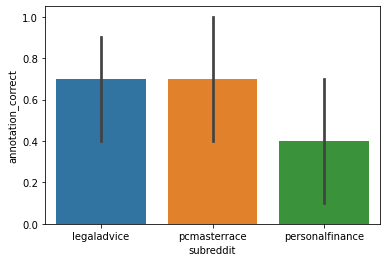

In [187]:
# get aggregate % and distribution
print(combined_group_annotation_data.groupby('subreddit').apply(lambda x: x.loc[:, 'annotation_correct'].mean()))
sns.barplot(data=combined_group_annotation_data, x='subreddit', y='annotation_correct')
plt.show()

-  Annotators did best on `LegalAdvice` and `PCMasterRace`, maybe because the notion of "expert" is more well-defined than in `PersonalFinance` (e.g. complex ideas about law/technology are more easily detected and associated w/ "expert").

How long did each annotator take?

In [205]:
valid_annotator_ids = flat_annotation_data.loc[:, 'ResponseId'].unique()
annotation_subreddit_lookup = flat_annotation_data.loc[:, ['ResponseId', 'subreddit']].drop_duplicates()
annotator_response_times = annotation_data[annotation_data.loc[:, 'ResponseId'].isin(valid_annotator_ids)].loc[:, ['ResponseId', 'Duration (in seconds)']]
annotator_response_times = pd.merge(annotator_response_times, annotation_subreddit_lookup, on='ResponseId')
print(annotator_response_times.loc[:, ['subreddit', 'Duration (in seconds)']])

         subreddit  Duration (in seconds)
0     pcmasterrace                    713
1      legaladvice                   1109
2  personalfinance                   2639


The annotators took around 25 minutes to complete the task. `r/PersonalFinance` took the longest, maybe because of the long posts.

### Prolific test: official round 1
After our pilot test, we extended the task to all subreddits and all reader groups with 1 annotator each.

Let's see how the annotators did!

In [1]:
## load round 1 data
import pandas as pd
annotation_1_data = pd.read_csv('../../data/reddit_data/annotation_data/generated_text_evaluation/compare_model_output/reader_question_generation_prolific_domain_pilot.tsv', sep='\t', index_col=False)
# get rid of leading 1s
import re
Q_col_matcher = re.compile('^1\.')
Q_cols = list(filter(lambda x: Q_col_matcher.match(x) is not None, annotation_1_data.columns))
annotation_1_data.rename(columns={x : Q_col_matcher.sub('', x) for x in Q_cols}, inplace=True)
# get clean Q cols
clean_Q_col_matcher = re.compile('^(\d)')
clean_Q_cols = list(filter(lambda x: clean_Q_col_matcher.search(x) is not None, annotation_1_data.columns))
# print(clean_Q_cols)
# flatten data
flat_annotation_1_data = pd.melt(annotation_1_data, id_vars=['ResponseId'], value_vars=clean_Q_cols, value_name='annotation_val', var_name='Q_name')
flat_annotation_1_data.dropna(subset=['annotation_val'], inplace=True, axis=0)
# clean up column names
# remove final decimals
decimal_ending_matcher = re.compile('\.\d$')
flat_annotation_1_data = flat_annotation_1_data.assign(**{
    'Q_name' : flat_annotation_1_data.loc[:, 'Q_name'].apply(lambda x: decimal_ending_matcher.sub('', x))
})
# add -0 for bare columns
bare_number_matcher = re.compile('^(\d)((?=[\._]\d$)|(?=$))')
flat_annotation_1_data = flat_annotation_1_data.assign(**{
    'Q_name' : flat_annotation_1_data.loc[:, 'Q_name'].apply(lambda x: bare_number_matcher.sub('\\1-0', x))
})
# get rating type
rating_type_lookup = {
    '1' : 'Relevant',
    '2' : 'Understandable',
    '3' : 'Answerable',
}
flat_annotation_1_data = flat_annotation_1_data.assign(**{
    'Q_rating_type' : flat_annotation_1_data.loc[:, 'Q_name'].apply(lambda x: rating_type_lookup.get(x.split('_')[-1]))
})
flat_annotation_1_data = flat_annotation_1_data.assign(**{
    'Q_name' : flat_annotation_1_data.loc[:, 'Q_name'].apply(lambda x: x.split('_')[0])
})
# fix annotation vals for reader group questions
flat_annotation_1_data = flat_annotation_1_data.assign(**{
    'annotation_val' : flat_annotation_1_data.loc[:, 'annotation_val'].apply(lambda x: x.split(':')[0])
})
response_id_subreddit_lookup = {
    'R_3lMsb2DuXC0p5QG' : 'legaladvice',
    'R_1Ojh5qRT5OXmKDO' : 'pcmasterrace',
    'R_33jz6riXVbr3A4H' : 'personalfinance'
}
flat_annotation_1_data = flat_annotation_1_data.assign(**{
    'subreddit' : flat_annotation_1_data.loc[:, 'ResponseId'].apply(response_id_subreddit_lookup.get)
})
flat_annotation_1_data = flat_annotation_1_data.assign(**{'group_category' : 'expert'})
flat_annotation_1_data = flat_annotation_1_data.assign(**{'annotation_round' : 1})
display(flat_annotation_1_data.head(20))

,ResponseId,Q_name,annotation_val,Q_rating_type,subreddit,group_category,annotation_round
16,R_3lMsb2DuXC0p5QG,1-0,Very,Relevant,legaladvice,expert,1
34,R_3lMsb2DuXC0p5QG,1-0,Very,Understandable,legaladvice,expert,1
52,R_3lMsb2DuXC0p5QG,1-0,Somewhat,Answerable,legaladvice,expert,1
70,R_3lMsb2DuXC0p5QG,2-0,Not very,Relevant,legaladvice,expert,1
88,R_3lMsb2DuXC0p5QG,2-0,Very,Understandable,legaladvice,expert,1
106,R_3lMsb2DuXC0p5QG,2-0,Neutral,Answerable,legaladvice,expert,1
124,R_3lMsb2DuXC0p5QG,3-0,Neutral,Relevant,legaladvice,expert,1
142,R_3lMsb2DuXC0p5QG,3-0,Very,Understandable,legaladvice,expert,1
160,R_3lMsb2DuXC0p5QG,3-0,Somewhat,Answerable,legaladvice,expert,1
178,R_3lMsb2DuXC0p5QG,4-0,Q2,None,legaladvice,expert,1


In [2]:
## load round 2 data
import pandas as pd
annotation_2_data = pd.read_csv('../../data/reddit_data/annotation_data/generated_text_evaluation/compare_model_output/reader_question_prolific_v2.csv', sep=',', index_col=False)
annotation_2_data.rename(columns={'Q537' : 'PROLIFIC_PID'}, inplace=True)
## fix annotation_2 cols (add subreddit + group info to reader group questions)
Q_col_matcher = re.compile('^\d\.\d')
annotation_2_Q_cols = list(filter(lambda x: Q_col_matcher.match(x), annotation_2_data.columns))
clip_Q_col_matcher = re.compile('^\d\.\d[\.\d]*$')
subreddit_matcher = re.compile('(?<=subreddit=)([^_]+)')
group_category_matcher = re.compile('(?<=group_category=)([^_]+)')
# print(annotation_2_Q_cols)
# apply subreddit/group category from previous question to bare question
for i in range(len(annotation_2_Q_cols)):
    col_i = annotation_2_Q_cols[i]
    if(clip_Q_col_matcher.match(col_i)):
        subreddit_i = subreddit_matcher.search(annotation_2_Q_cols[i-1]).group(0)
        group_category_i = group_category_matcher.search(annotation_2_Q_cols[i-1]).group(0)
        clean_col_i = f'{col_i}_subreddit={subreddit_i}_group_category={group_category_i}'
        annotation_2_data.rename(columns={col_i : clean_col_i}, inplace=True)
# print(annotation_2_data.columns[:100])
annotation_2_Q_cols = list(filter(lambda x: Q_col_matcher.match(x), annotation_2_data.columns))
# remove invalid annotators
annotation_2_data = annotation_2_data.dropna(subset=['PROLIFIC_PID'])
PID_matcher = re.compile('\w{24}')
annotation_2_data = annotation_2_data[annotation_2_data.loc[:, 'PROLIFIC_PID'].apply(lambda x: PID_matcher.match(x) is not None)]
# print(annotation_2_data.loc[:, 'PROLIFIC_PID'])
## flatten data => 1 rating per row
flat_annotation_2_data = pd.melt(annotation_2_data, id_vars=['ResponseId'], value_vars=annotation_2_Q_cols, value_name='annotation_val', var_name='Q_name')
flat_annotation_2_data.dropna(subset=['annotation_val'], inplace=True)
# fix question names etc.
quality_num_matcher = re.compile('(?<=_)(\d)$')
def fix_question_name(q_name_str, quality_num_matcher, subreddit_matcher, group_category_matcher):
    q_combined_num = q_name_str.split('_')[0]
#     print(f'combined num = {q_combined_num}')
    q_combined_num_split = q_combined_num.split('.')
    post_num, q_num = q_combined_num_split[:2] # some columns have 0.0.0 format??
    if(quality_num_matcher.search(q_name_str) is not None):
        quality_type = quality_num_matcher.search(q_name_str).group(0)
    else:
        quality_type = None
    subreddit = subreddit_matcher.search(q_name_str).group(0)
    group_category = group_category_matcher.search(q_name_str).group(0)
    # update number
    clean_num = f'{q_num}-{int(post_num)}'
    return clean_num, quality_type, subreddit, group_category
flat_annotation_2_data = flat_annotation_2_data.assign(**{
    'q_info_combined' : flat_annotation_2_data.loc[:, 'Q_name'].apply(lambda x: fix_question_name(x, quality_num_matcher, subreddit_matcher, group_category_matcher))
})
# fix q info
flat_annotation_2_data = flat_annotation_2_data.assign(**{
    'Q_num' : flat_annotation_2_data.loc[:, 'q_info_combined'].apply(lambda x: x[0]),
    'Q_rating_type' : flat_annotation_2_data.loc[:, 'q_info_combined'].apply(lambda x: x[1]),
    'subreddit' : flat_annotation_2_data.loc[:, 'q_info_combined'].apply(lambda x: x[2]),
    'group_category' : flat_annotation_2_data.loc[:, 'q_info_combined'].apply(lambda x: x[3]),
})
rating_type_lookup = {
    '1' : 'Relevant',
    '2' : 'Understandable',
    '3' : 'Answerable',
}
flat_annotation_2_data = flat_annotation_2_data.assign(**{'Q_rating_type' : flat_annotation_2_data.loc[:, 'Q_rating_type'].apply(rating_type_lookup.get)})
flat_annotation_2_data.drop(['q_info_combined', 'Q_name'], axis=1, inplace=True)
flat_annotation_2_data.rename(columns={'Q_num' : 'Q_name'}, inplace=True)
flat_annotation_2_data = flat_annotation_2_data.assign(**{'annotation_round' : 2})
# fix annotation val for reader group prediction
flat_annotation_2_data = flat_annotation_2_data.assign(**{'annotation_val' : flat_annotation_2_data.loc[:, 'annotation_val'].apply(lambda x: x.split(':')[0])})
display(flat_annotation_2_data.head(10))

,ResponseId,annotation_val,Q_name,Q_rating_type,subreddit,group_category,annotation_round
0,R_2CCw5glblpuGRCw,Neutral,1-0,Relevant,Advice,expert,2
12,R_2CCw5glblpuGRCw,Very,1-0,Understandable,Advice,expert,2
24,R_2CCw5glblpuGRCw,Somewhat,1-0,Answerable,Advice,expert,2
36,R_2CCw5glblpuGRCw,Neutral,2-0,Relevant,Advice,expert,2
48,R_2CCw5glblpuGRCw,Very,2-0,Understandable,Advice,expert,2
60,R_2CCw5glblpuGRCw,Very,2-0,Answerable,Advice,expert,2
72,R_2CCw5glblpuGRCw,Neutral,3-0,Relevant,Advice,expert,2
84,R_2CCw5glblpuGRCw,Neutral,3-0,Understandable,Advice,expert,2
96,R_2CCw5glblpuGRCw,Not very,3-0,Answerable,Advice,expert,2
108,R_2CCw5glblpuGRCw,Q2,4-0,None,Advice,expert,2


In [3]:
## combine annotation data
combined_flat_annotation_data = pd.concat([
    flat_annotation_1_data,
    flat_annotation_2_data,
], axis=0)
print(combined_flat_annotation_data.loc[:, ['subreddit', 'group_category']].value_counts())
print(combined_flat_annotation_data.loc[:, 'Q_name'].value_counts())

subreddit        group_category
Advice           expert            100
                 location          100
                 time              100
AmItheAsshole    expert            100
                 location          100
                 time              100
legaladvice      expert            100
                 location          100
                 time              100
pcmasterrace     expert            100
                 location          100
                 time              100
personalfinance  expert            100
                 location          100
                 time              100
dtype: int64
1-0    45
2-7    45
2-5    45
3-5    45
1-6    45
2-6    45
3-6    45
1-7    45
3-7    45
3-4    45
1-8    45
2-8    45
3-8    45
1-9    45
2-9    45
3-9    45
2-0    45
1-5    45
2-4    45
3-2    45
3-0    45
1-1    45
2-1    45
3-1    45
1-2    45
2-2    45
1-3    45
2-3    45
3-3    45
1-4    45
4-2    15
4-6    15
4-4    15
4-7    15
4-1    15
4-5    15
4-8    15


Let's make sure that no one completed the task too quickly.

In [4]:
## check for annotator times!
time_var = 'Duration (in seconds)'
id_var = 'ResponseId'
annotator_time_stats = pd.concat([
    annotation_1_data.loc[:, [id_var, time_var]],
    annotation_2_data.loc[:, [id_var, time_var]],
])
annotator_time_stats = annotator_time_stats[annotator_time_stats.loc[:, id_var].isin(combined_flat_annotation_data.loc[:, id_var].unique())]
annotator_time_stats = annotator_time_stats.assign(**{time_var : annotator_time_stats.loc[:, time_var].astype(float)})
# add subreddit data
annotator_time_stats = pd.merge(annotator_time_stats, combined_flat_annotation_data.loc[:, [id_var, 'subreddit']], on=id_var, how='left').drop_duplicates([id_var])
print(annotator_time_stats.loc[:, [time_var, 'subreddit']].sort_values(time_var))
print(annotator_time_stats.loc[:, time_var].astype(int).median())

      Duration (in seconds)        subreddit
0                     713.0     pcmasterrace
400                   722.0           Advice
1200                  826.0     pcmasterrace
700                  1009.0    AmItheAsshole
100                  1109.0      legaladvice
1400                 1134.0  personalfinance
900                  1174.0      legaladvice
1100                 1472.0  personalfinance
600                  1560.0    AmItheAsshole
1300                 1593.0      legaladvice
300                  1782.0           Advice
1000                 1940.0     pcmasterrace
200                  2639.0  personalfinance
800                  2665.0    AmItheAsshole
500                  3230.0           Advice
1472.0


12 minutes is the minimum time, which seems like a long time to read 10 posts and 5 questions per post.

In [5]:
## join with original data
import os
from itertools import product
annotation_subreddits = combined_flat_annotation_data.loc[:, 'subreddit'].unique()
annotation_reader_groups = combined_flat_annotation_data.loc[:, 'group_category'].unique()
annotation_data_dir = '../../data/reddit_data/annotation_data/generated_text_evaluation/compare_model_output/'
annotation_data_files_combined = list(map(lambda x: [os.path.join(annotation_data_dir, f'subreddit={x[0]}_group={x[1]}_annotation_data.tsv'), x[0], x[1]], product(annotation_subreddits, annotation_reader_groups)))
annotation_true_data = list(map(lambda x: pd.read_csv(x[0], sep='\t', index_col=False).assign(**{'subreddit' : x[1], 'group_category' : x[2]}), annotation_data_files_combined))
annotation_true_data = list(map(lambda x: x.assign(**{'index' : list(range(x.shape[0]))}), annotation_true_data))
annotation_true_data = pd.concat(annotation_true_data, axis=0)
display(annotation_true_data.head())
## flatten data
# question text
flat_annotation_true_data = pd.melt(annotation_true_data, id_vars=['subreddit', 'post_text', 'parent_id', 'index', 'reader_group', 'group_category'], value_vars=['Q1.1', 'Q1.2', 'Q1.3', 'Q2.1', 'Q2.2'], value_name='question_text', var_name='Q_name')
# question text type
question_text_type_true_data = pd.melt(annotation_true_data, id_vars=['subreddit', 'post_text', 'parent_id', 'index', 'reader_group', 'group_category'], value_vars=['Q1.1.type', 'Q1.2.type', 'Q1.3.type', 'Q2.1.type', 'Q2.2.type'], value_name='question_text_type', var_name='Q_name')
question_text_type_true_data = question_text_type_true_data.assign(**{
    'Q_name' : question_text_type_true_data.loc[:, 'Q_name'].apply(lambda x: x.replace('.type', ''))
})
flat_annotation_true_data = pd.merge(flat_annotation_true_data, question_text_type_true_data,
                                     on=['subreddit', 'post_text', 'parent_id', 'index', 'Q_name', 'reader_group', 'group_category'],
                                     how='left')
# add labels for reader group questions
flat_annotation_true_data = flat_annotation_true_data.assign(**{
    'Q_reader_group' : flat_annotation_true_data.loc[:, 'Q_name'].apply(lambda x: f'Q{x.split(".")[-1]}' if x.startswith('Q2') else None)
})
# fix Q name
# Q_num-idx
Q_name_lookup = {
    '1.1' : '1',
    '1.2' : '2',
    '1.3' : '3',
    '2.1' : '4',
    '2.2' : '4',
}
flat_annotation_true_data = flat_annotation_true_data.assign(**{
    'Q_name' : flat_annotation_true_data.apply(lambda x: f'{Q_name_lookup[x.loc["Q_name"].replace("Q", "")]}-{x.loc["index"]}', axis=1)
})
# for reader-group question: remove questions that aren't associated w/ default values (i.e. incorrect answers)
default_reader_group_vals = ['<EXPERT_PCT_1_AUTHOR>', '<US_AUTHOR>', '<RESPONSE_TIME_0_AUTHOR>']
question_text_types = ['target_text', 'reader_model', 'text_model']
valid_question_text_types = question_text_types + default_reader_group_vals
flat_annotation_true_data = flat_annotation_true_data[flat_annotation_true_data.loc[:, 'question_text_type'].isin(valid_question_text_types)]
flat_annotation_true_data.sort_values(['subreddit', 'group_category', 'index'], inplace=True, ascending=True)
display(flat_annotation_true_data.head())

,parent_id,post_text,subreddit,group_category,reader_group,Q1.1,Q1.2,Q1.3,Q1.1.type,Q1.2.type,Q1.3.type,Q2.1,Q2.2,Q2.1.type,Q2.2.type,question_num,index
0,atd567,"December —my mom was in an accident, and the o...",legaladvice,expert,<EXPERT_PCT_0_AUTHOR>,Was the repair shop one that insurance chose f...,What is your location?,How do you know the shop is closed and it is n...,target_text,reader_model,text_model,What is your location?,Do you have collision coverage on your car?,<EXPERT_PCT_0_AUTHOR>,<EXPERT_PCT_1_AUTHOR>,0,0
1,9aj6ql,I'm freaking out because School starts for my ...,legaladvice,expert,<EXPERT_PCT_1_AUTHOR>,The kids will be in the same school for the ne...,Did you take the proper steps to enroll them?,Is the child eligible for a public defender?,text_model,target_text,reader_model,Is the child eligible for adoption at this point?,Is the child eligible for a public defender?,<EXPERT_PCT_0_AUTHOR>,<EXPERT_PCT_1_AUTHOR>,1,1
2,99448p,"Hi all,A few days ago, I was driving to work i...",legaladvice,expert,<EXPERT_PCT_1_AUTHOR>,Did you ever get a police report?,Did you get the ticket in person?,What statute or ordinance were you charged wit...,text_model,reader_model,target_text,Did you get the ticket in person?,Did you pay a fine or not?,<EXPERT_PCT_1_AUTHOR>,<EXPERT_PCT_0_AUTHOR>,2,2
3,d7bksp,"(Long-winded. Sorry)About two months ago, I re...",legaladvice,expert,<EXPERT_PCT_0_AUTHOR>,Did you ever pay the bill?,Has the debt been sent to collections?,What are the damages you incurred besides bein...,reader_model,text_model,target_text,Did you pay with a credit card?,Did you ever pay the bill?,<EXPERT_PCT_1_AUTHOR>,<EXPERT_PCT_0_AUTHOR>,3,3
4,b5bady,I work in the hotel industry. Our breakfast ho...,legaladvice,expert,<EXPERT_PCT_0_AUTHOR>,Did you go into your manager’s room and get th...,Do you have any medical bills related to this?,Might be something that changes between counties?,text_model,reader_model,target_text,Do you have any damages?,Do you have any medical bills related to this?,<EXPERT_PCT_1_AUTHOR>,<EXPERT_PCT_0_AUTHOR>,4,4


,subreddit,post_text,parent_id,index,reader_group,group_category,Q_name,question_text,question_text_type,Q_reader_group
90,Advice,I usually hang in call with my best mate for m...,d0sxjl,0,<EXPERT_PCT_1_AUTHOR>,expert,1-0,Do you have any other friend you can talk to?,reader_model,None
240,Advice,I usually hang in call with my best mate for m...,d0sxjl,0,<EXPERT_PCT_1_AUTHOR>,expert,2-0,Could he be doing something to help you?,text_model,None
390,Advice,I usually hang in call with my best mate for m...,d0sxjl,0,<EXPERT_PCT_1_AUTHOR>,expert,3-0,Does that mean you can never complain?,target_text,None
540,Advice,I usually hang in call with my best mate for m...,d0sxjl,0,<EXPERT_PCT_1_AUTHOR>,expert,4-0,Do you have any other friend you can talk to?,<EXPERT_PCT_1_AUTHOR>,Q1
91,Advice,"The other day, my girlfriend and I went to a r...",cxptow,1,<EXPERT_PCT_0_AUTHOR>,expert,1-1,Do you have any evidence of the condition of t...,reader_model,None


In [6]:
## combine true/annotated data
combined_annotation_data = pd.merge(combined_flat_annotation_data, flat_annotation_true_data,
                                    on=['subreddit', 'group_category', 'Q_name'], how='left')
# get annotation type
combined_annotation_data = combined_annotation_data.assign(**{
    'annotation_type' : combined_annotation_data.apply(lambda x: 'reader_group' if x.loc['Q_reader_group'] is not None else 'quality', axis=1)
})
display(combined_annotation_data.head())
# split data by type, get numbers!!
combined_quality_annotation_data = combined_annotation_data[combined_annotation_data.loc[:, 'annotation_type']=='quality']
combined_group_annotation_data = combined_annotation_data[combined_annotation_data.loc[:, 'annotation_type']=='reader_group']
quality_num_lookup = {
    'Very' : 5,
    'Somewhat' : 4,
    'Neutral' : 3,
    'Not very' : 2,
    'Not at all' : 1,
}
combined_quality_annotation_data = combined_quality_annotation_data.assign(**{
    'annotation_num' : combined_quality_annotation_data.loc[:, 'annotation_val'].apply(quality_num_lookup.get)
})
## let's also add a simplified quality score: was the annotation at least Somewhat "good"
combined_quality_annotation_data = combined_quality_annotation_data.assign(**{
    'annotation_num_bin' : (combined_quality_annotation_data.loc[:, 'annotation_num'] >= 4).astype(int)
})
# group data
combined_group_annotation_data = combined_group_annotation_data.assign(**{
    'annotation_correct' : (combined_group_annotation_data.loc[:, 'annotation_val']==combined_group_annotation_data.loc[:, 'Q_reader_group']).astype(int)
})

,ResponseId,Q_name,annotation_val,Q_rating_type,subreddit,group_category,annotation_round,post_text,parent_id,index,reader_group,question_text,question_text_type,Q_reader_group,annotation_type
0,R_3lMsb2DuXC0p5QG,1-0,Very,Relevant,legaladvice,expert,1,"December —my mom was in an accident, and the o...",atd567,0,<EXPERT_PCT_0_AUTHOR>,Was the repair shop one that insurance chose f...,target_text,None,quality
1,R_3lMsb2DuXC0p5QG,1-0,Very,Understandable,legaladvice,expert,1,"December —my mom was in an accident, and the o...",atd567,0,<EXPERT_PCT_0_AUTHOR>,Was the repair shop one that insurance chose f...,target_text,None,quality
2,R_3lMsb2DuXC0p5QG,1-0,Somewhat,Answerable,legaladvice,expert,1,"December —my mom was in an accident, and the o...",atd567,0,<EXPERT_PCT_0_AUTHOR>,Was the repair shop one that insurance chose f...,target_text,None,quality
3,R_3lMsb2DuXC0p5QG,2-0,Not very,Relevant,legaladvice,expert,1,"December —my mom was in an accident, and the o...",atd567,0,<EXPERT_PCT_0_AUTHOR>,What is your location?,reader_model,None,quality
4,R_3lMsb2DuXC0p5QG,2-0,Very,Understandable,legaladvice,expert,1,"December —my mom was in an accident, and the o...",atd567,0,<EXPERT_PCT_0_AUTHOR>,What is your location?,reader_model,None,quality


What are the overall ratings?

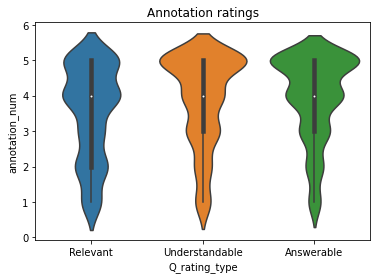

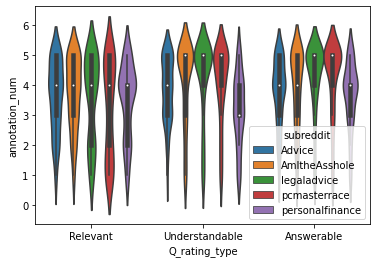

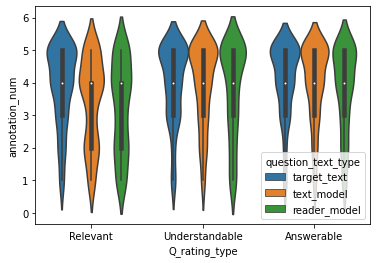

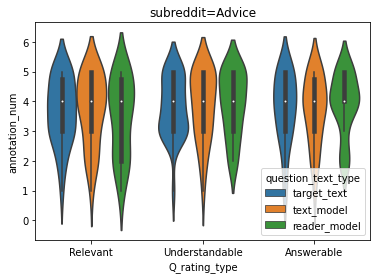

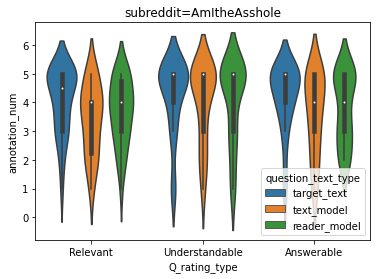

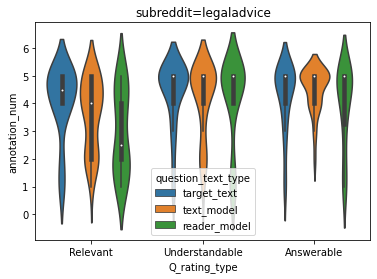

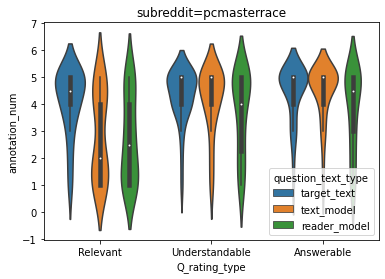

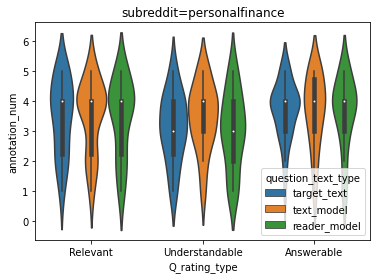

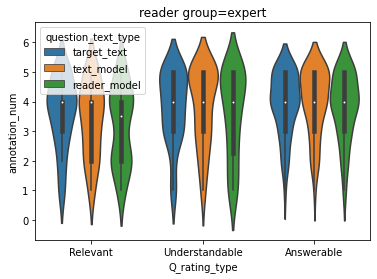

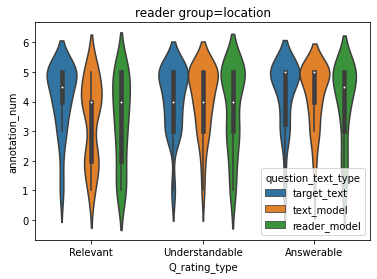

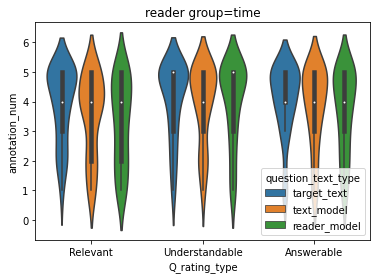

In [7]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
## overall
sns.violinplot(data=combined_quality_annotation_data, x='Q_rating_type', y='annotation_num')
plt.title('Annotation ratings')
plt.show()
## per subreddit
annotation_subreddits = list(sorted(combined_group_annotation_data.loc[:, 'subreddit'].unique()))
sns.violinplot(data=combined_quality_annotation_data, x='Q_rating_type', y='annotation_num', hue='subreddit', hue_order=annotation_subreddits)
plt.show()
## per text type
text_type_order = ['target_text', 'text_model', 'reader_model']
sns.violinplot(data=combined_quality_annotation_data, x='Q_rating_type', y='annotation_num', hue='question_text_type', hue_order=text_type_order)
plt.show()
## per subreddit, per model
for subreddit_i, data_i in combined_quality_annotation_data.groupby('subreddit'):
    sns.violinplot(data=data_i, x='Q_rating_type', y='annotation_num', hue='question_text_type', hue_order=text_type_order)
    plt.title(f'subreddit={subreddit_i}')
    plt.show()
## per reader group
for reader_group_i, data_i in combined_quality_annotation_data.groupby('group_category'):
    sns.violinplot(data=data_i, x='Q_rating_type', y='annotation_num', hue='question_text_type', hue_order=text_type_order)
    plt.title(f'reader group={reader_group_i}')
    plt.show()

Let's get the overall stats for clarity.

In [113]:
display(combined_quality_annotation_data.groupby(['Q_rating_type', 'question_text_type']).apply(lambda x: x.loc[:, 'annotation_num'].mean()).reset_index().pivot(columns=['Q_rating_type'], index=['question_text_type'], values=[0]))
# display(combined_quality_annotation_data.groupby(['subreddit', 'Q_rating_type', 'question_text_type']).apply(lambda x: x.loc[:, 'annotation_num'].mean()).reset_index().pivot(columns=['Q_rating_type'], index=['question_text_type', 'subreddit'], values=[0]))

0                         
Q_rating_type      Answerable  Relevant Understandable
question_text_type                                    
reader_model         3.800000  3.260000       3.760000
target_text          4.053333  3.866667       3.953333
text_model           3.986667  3.413333       3.920000

In [8]:
pd.set_option('display.max_rows', 200)
# overall
print(f'*** raw annotation num ***')
display(combined_quality_annotation_data.groupby('Q_rating_type').apply(lambda x: x.loc[:, 'annotation_num'].mean()).reset_index())
# per model
display(combined_quality_annotation_data.groupby(['Q_rating_type', 'question_text_type']).apply(lambda x: x.loc[:, 'annotation_num'].mean()).reset_index().pivot(columns=['Q_rating_type'], index=['question_text_type'], values=[0]))
# per model, per subreddit
display(combined_quality_annotation_data.groupby(['subreddit', 'Q_rating_type', 'question_text_type']).apply(lambda x: x.loc[:, 'annotation_num'].mean()).reset_index().pivot(columns=['Q_rating_type'], index=['subreddit', 'question_text_type'], values=[0]))
# per model, per reader group
display(combined_quality_annotation_data.groupby(['Q_rating_type', 'group_category', 'question_text_type']).apply(lambda x: x.loc[:, 'annotation_num'].mean()).reset_index())
# per model, per reader group, per subreddit
display(combined_quality_annotation_data.groupby(['group_category', 'subreddit', 'question_text_type', 'Q_rating_type']).apply(lambda x: x.loc[:, 'annotation_num'].mean()).reset_index().sort_values(['group_category', 'subreddit', 'Q_rating_type', 'question_text_type']))
print(f'*** binarized annotation ***')
# overall: binarized
display(combined_quality_annotation_data.groupby('Q_rating_type').apply(lambda x: x.loc[:, 'annotation_num_bin'].mean()).reset_index())
# per model, per subreddit: binarized
display(combined_quality_annotation_data.groupby(['subreddit', 'question_text_type', 'Q_rating_type']).apply(lambda x: x.loc[:, 'annotation_num_bin'].mean()).reset_index())

*** raw annotation num ***


,Q_rating_type,0
0,Answerable,3.946667
1,Relevant,3.513333
2,Understandable,3.877778


0                         
Q_rating_type      Answerable  Relevant Understandable
question_text_type                                    
reader_model         3.800000  3.260000       3.760000
target_text          4.053333  3.866667       3.953333
text_model           3.986667  3.413333       3.920000

0                         
Q_rating_type                      Answerable  Relevant Understandable
subreddit       question_text_type                                    
Advice          reader_model         3.900000  3.466667       3.900000
                target_text          3.733333  3.666667       3.800000
                text_model           3.700000  3.700000       3.833333
AmItheAsshole   reader_model         3.800000  3.666667       4.033333
                target_text          4.166667  4.066667       4.200000
                text_model           3.633333  3.400000       4.000000
legaladvice     reader_model         3.933333  2.966667       4.133333
                target_text          4.266667  4.066667       4.333333
                text_model           4.500000  3.600000       4.166667
pcmasterrace    reader_model         3.766667  2.733333       3.700000
                target_text          4.400000  4.066667       4.300000
                text_model           4.433333  2.866667       4.133333
personalfinance reader_model         3.600000  3.466667       3.033333
                target_text          3.700000  3.466667       3.133333
                text_model           3.666667  3.500000       3.466667

,Q_rating_type,group_category,question_text_type,0
0,Answerable,expert,reader_model,3.80
1,Answerable,expert,target_text,3.92
2,Answerable,expert,text_model,3.96
3,Answerable,location,reader_model,3.94
4,Answerable,location,target_text,4.20
5,Answerable,location,text_model,4.20
6,Answerable,time,reader_model,3.66
7,Answerable,time,target_text,4.04
8,Answerable,time,text_model,3.80
9,Relevant,expert,reader_model,3.16


,group_category,subreddit,question_text_type,Q_rating_type,0
0,expert,Advice,reader_model,Answerable,4.1
3,expert,Advice,target_text,Answerable,3.6
6,expert,Advice,text_model,Answerable,4.0
1,expert,Advice,reader_model,Relevant,3.8
4,expert,Advice,target_text,Relevant,3.2
7,expert,Advice,text_model,Relevant,4.0
2,expert,Advice,reader_model,Understandable,3.9
5,expert,Advice,target_text,Understandable,3.5
8,expert,Advice,text_model,Understandable,4.0
9,expert,AmItheAsshole,reader_model,Answerable,3.0


*** binarized annotation ***


,Q_rating_type,0
0,Answerable,0.711111
1,Relevant,0.595556
2,Understandable,0.664444


,subreddit,question_text_type,Q_rating_type,0
0,Advice,reader_model,Answerable,0.766667
1,Advice,reader_model,Relevant,0.566667
2,Advice,reader_model,Understandable,0.666667
3,Advice,target_text,Answerable,0.633333
4,Advice,target_text,Relevant,0.566667
5,Advice,target_text,Understandable,0.566667
6,Advice,text_model,Answerable,0.633333
7,Advice,text_model,Relevant,0.633333
8,Advice,text_model,Understandable,0.633333
9,AmItheAsshole,reader_model,Answerable,0.566667


- In aggregate: 
    - `target_text` > `text_model` > `reader_model`
- Per quality type: 
    - `target_text` > `text_model` > `reader_model`
- Per subreddit:
    - `Advice`: `target_text` > `reader_model` > `text_model`
    - most others: `target_text` > `text_model` > `reader_model`
- Per quality type, per subreddit
    - Lots of variance! Could be annotator error, could also indicate that some reader groups "fit" well into some domain contexts.

What about reader group guessing accuracy?

0.5


,subreddit,0
0,Advice,0.466667
1,AmItheAsshole,0.533333
2,legaladvice,0.633333
3,pcmasterrace,0.533333
4,personalfinance,0.333333


,group_category,0
0,expert,0.52
1,location,0.50
2,time,0.48


group_category,expert,location,time
subreddit,,,
Advice,0.4,0.6,0.4
AmItheAsshole,0.4,0.4,0.8
legaladvice,0.7,0.6,0.6
pcmasterrace,0.7,0.4,0.5
personalfinance,0.4,0.5,0.1


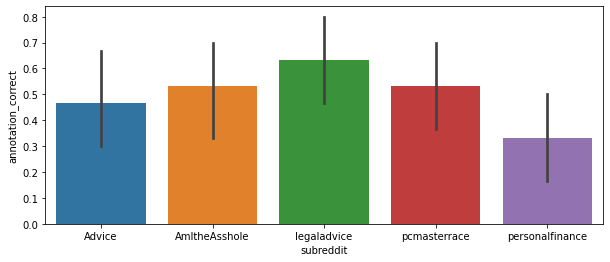

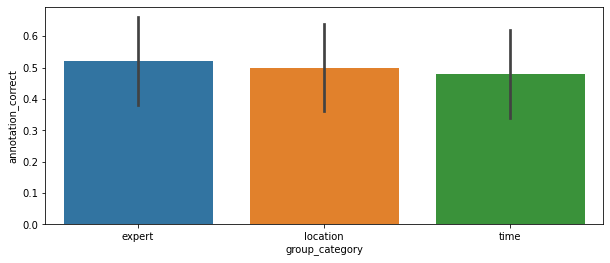

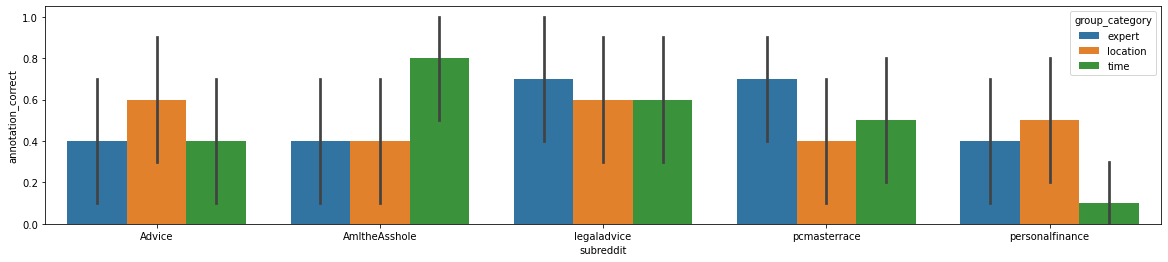

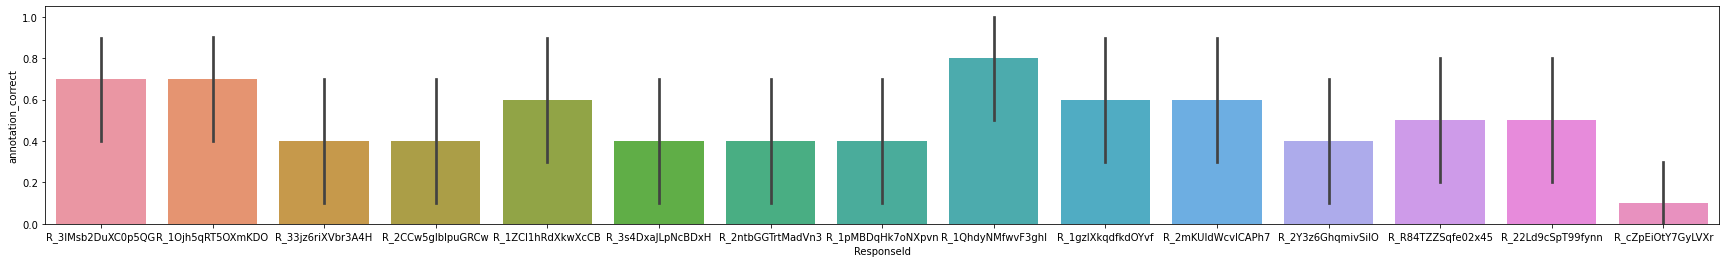

In [9]:
# get aggregate % and distribution
# total
print(combined_group_annotation_data.loc[:, 'annotation_correct'].mean())
# per subreddit
display(combined_group_annotation_data.groupby('subreddit').apply(lambda x: x.groupby('ResponseId').apply(lambda y: y.loc[:, 'annotation_correct'].mean()).mean()).reset_index())
# per reader category
display(combined_group_annotation_data.groupby(['group_category']).apply(lambda x: x.groupby('ResponseId').apply(lambda y: y.loc[:, 'annotation_correct'].mean()).mean()).reset_index())
# per subreddit, per reader category
display(combined_group_annotation_data.groupby(['group_category', 'subreddit']).apply(lambda x: x.groupby('ResponseId').apply(lambda y: y.loc[:, 'annotation_correct'].mean()).mean()).reset_index().pivot(index=['subreddit'], columns=['group_category'], values=0))
## per subreddit
plt.figure(figsize=(10,4))
sns.barplot(data=combined_group_annotation_data, x='subreddit', y='annotation_correct', order=annotation_subreddits)
plt.show()
## per reader group
plt.figure(figsize=(10,4))
sns.barplot(data=combined_group_annotation_data, x='group_category', y='annotation_correct')
plt.show()
## per subreddit, per reader group
plt.figure(figsize=(20,4))
sns.barplot(data=combined_group_annotation_data, x='subreddit', y='annotation_correct', hue='group_category', order=annotation_subreddits)
plt.show()
## per annotator lol
plt.figure(figsize=(30,4))
sns.barplot(data=combined_group_annotation_data, x='ResponseId', y='annotation_correct')
plt.show()

### Prolific test: slow annotators

Let's re-run the numbers after removing the fast annotators, just to be safe.

In [10]:
min_annotator_time = 20 * 60
slow_annotators = annotator_time_stats[annotator_time_stats.loc[:, 'Duration (in seconds)']>=min_annotator_time].loc[:, 'ResponseId'].unique()
print(f'{len(slow_annotators)}/{annotator_time_stats.loc[:, "ResponseId"].nunique()} slow annotators')
slow_annotator_quality_annotation_data = combined_quality_annotation_data[combined_quality_annotation_data.loc[:, 'ResponseId'].isin(slow_annotators)]
slow_annotator_group_annotation_data = combined_group_annotation_data[combined_group_annotation_data.loc[:, 'ResponseId'].isin(slow_annotators)]

8/15 slow annotators


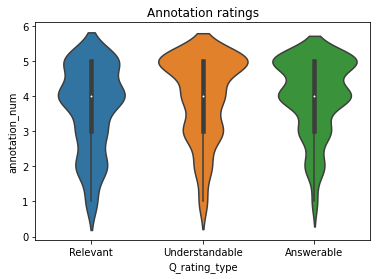

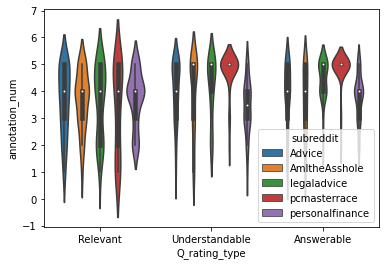

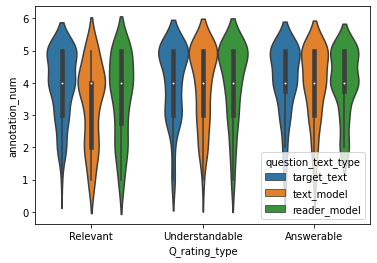

,Q_rating_type,0
0,Answerable,3.987500
1,Relevant,3.629167
2,Understandable,3.962500


0                        
Q_rating_type      Answerable Relevant Understandable
question_text_type                                   
reader_model           4.0000   3.5625         3.9875
target_text            4.0375   3.9375         3.9875
text_model             3.9250   3.3875         3.9125

0                        
Q_rating_type                      Answerable Relevant Understandable
subreddit       question_text_type                                   
Advice          reader_model             4.15     3.55           4.15
                target_text              3.70     3.50           4.00
                text_model               3.80     3.80           3.90
AmItheAsshole   reader_model             3.45     3.70           3.80
                target_text              4.00     4.00           4.05
                text_model               3.45     3.30           3.95
legaladvice     reader_model             4.30     3.10           4.70
                target_text              4.60     4.30           4.20
                text_model               4.40     3.40           3.60
pcmasterrace    reader_model             4.70     3.30           4.70
                target_text              4.80     4.60           4.70
                text_model               5.00     2.30           4.80
personalfinance reader_model             3.90     3.80           3.30
                target_text              3.75     3.80           3.45
                text_model               3.75     3.60           3.60

0                         
Q_rating_type                     Answerable  Relevant Understandable
group_category question_text_type                                    
expert         reader_model         3.633333  3.533333       3.300000
               target_text          3.600000  3.366667       3.266667
               text_model           3.500000  3.533333       3.500000
location       reader_model         4.350000  3.650000       4.100000
               target_text          4.350000  4.350000       4.250000
               text_model           4.500000  3.050000       4.250000
time           reader_model         4.133333  3.533333       4.600000
               target_text          4.266667  4.233333       4.533333
               text_model           3.966667  3.466667       4.100000

In [11]:
## question quality
sns.violinplot(data=slow_annotator_quality_annotation_data, x='Q_rating_type', y='annotation_num')
plt.title('Annotation ratings')
plt.show()
## per subreddit
annotation_subreddits = list(sorted(slow_annotator_group_annotation_data.loc[:, 'subreddit'].unique()))
sns.violinplot(data=slow_annotator_quality_annotation_data, x='Q_rating_type', y='annotation_num', hue='subreddit', hue_order=annotation_subreddits)
plt.show()
## per text type
text_type_order = ['target_text', 'text_model', 'reader_model']
sns.violinplot(data=slow_annotator_quality_annotation_data, x='Q_rating_type', y='annotation_num', hue='question_text_type', hue_order=text_type_order)
plt.show()
display(slow_annotator_quality_annotation_data.groupby('Q_rating_type').apply(lambda x: x.loc[:, 'annotation_num'].mean()).reset_index())
## show mean values
# per model
display(slow_annotator_quality_annotation_data.groupby(['Q_rating_type', 'question_text_type']).apply(lambda x: x.loc[:, 'annotation_num'].mean()).reset_index().pivot(columns=['Q_rating_type'], index=['question_text_type'], values=[0]))
# per model, per subreddit
display(slow_annotator_quality_annotation_data.groupby(['subreddit', 'Q_rating_type', 'question_text_type']).apply(lambda x: x.loc[:, 'annotation_num'].mean()).reset_index().pivot(columns=['Q_rating_type'], index=['subreddit', 'question_text_type'], values=[0]))
# per model, per reader group
display(slow_annotator_quality_annotation_data.groupby(['group_category', 'Q_rating_type', 'question_text_type']).apply(lambda x: x.loc[:, 'annotation_num'].mean()).reset_index().pivot(columns=['Q_rating_type'], index=['group_category', 'question_text_type'], values=[0]))

0.4875


,subreddit,0
0,Advice,0.40
1,AmItheAsshole,0.60
2,legaladvice,0.60
3,pcmasterrace,0.40
4,personalfinance,0.45


,group_category,0
0,expert,0.40
1,location,0.45
2,time,0.60


group_category,expert,location,time
subreddit,,,
Advice,0.4,NaN,0.4
AmItheAsshole,0.4,NaN,0.8
legaladvice,NaN,NaN,0.6
pcmasterrace,NaN,0.4,NaN
personalfinance,0.4,0.5,NaN


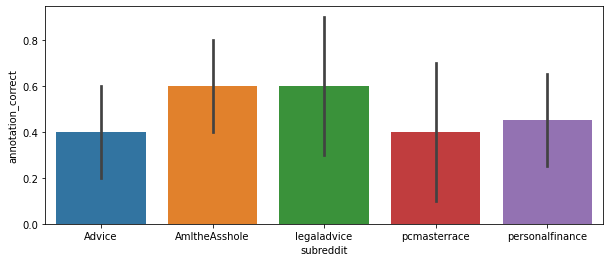

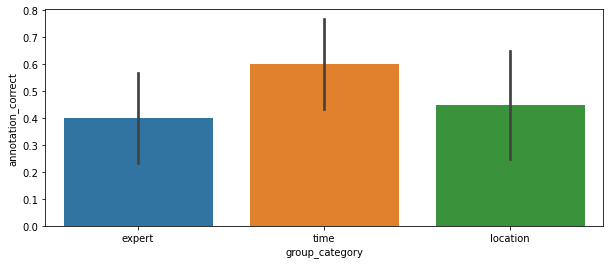

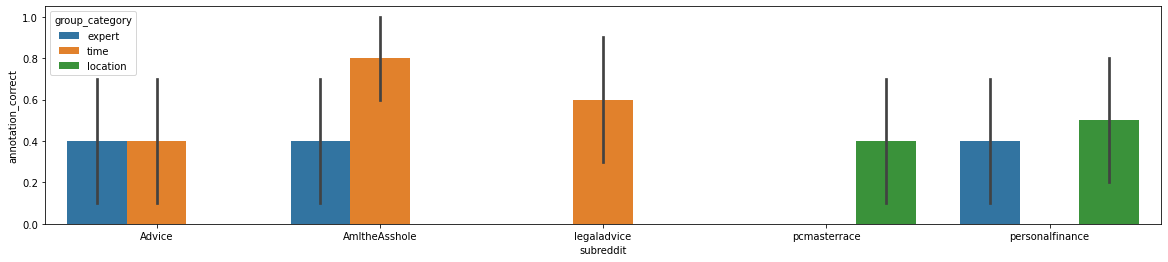

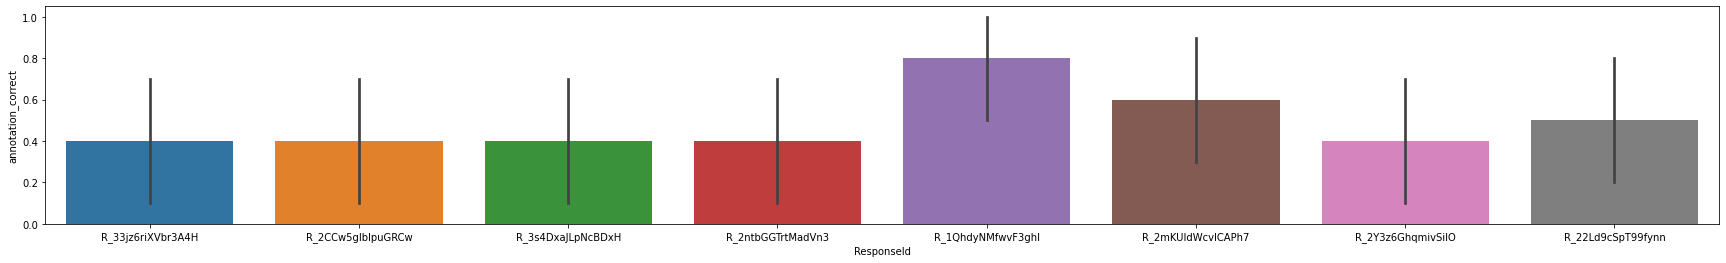

In [12]:
## group prediction accuracy
# get aggregate % and distribution
# total
print(slow_annotator_group_annotation_data.loc[:, 'annotation_correct'].mean())
# per subreddit
display(slow_annotator_group_annotation_data.groupby('subreddit').apply(lambda x: x.groupby('ResponseId').apply(lambda y: y.loc[:, 'annotation_correct'].mean()).mean()).reset_index())
# per reader category
display(slow_annotator_group_annotation_data.groupby(['group_category']).apply(lambda x: x.groupby('ResponseId').apply(lambda y: y.loc[:, 'annotation_correct'].mean()).mean()).reset_index())
# per subreddit, per reader category
display(slow_annotator_group_annotation_data.groupby(['group_category', 'subreddit']).apply(lambda x: x.groupby('ResponseId').apply(lambda y: y.loc[:, 'annotation_correct'].mean()).mean()).reset_index().pivot(index=['subreddit'], columns=['group_category'], values=0))
## per subreddit
plt.figure(figsize=(10,4))
sns.barplot(data=slow_annotator_group_annotation_data, x='subreddit', y='annotation_correct', order=annotation_subreddits)
plt.show()
## per reader group
plt.figure(figsize=(10,4))
sns.barplot(data=slow_annotator_group_annotation_data, x='group_category', y='annotation_correct')
plt.show()
## per subreddit, per reader group
plt.figure(figsize=(20,4))
sns.barplot(data=slow_annotator_group_annotation_data, x='subreddit', y='annotation_correct', hue='group_category', order=annotation_subreddits)
plt.show()
## per annotator lol
plt.figure(figsize=(30,4))
sns.barplot(data=slow_annotator_group_annotation_data, x='ResponseId', y='annotation_correct')
plt.show()

Are any of these differences significant?

We'll use nonparametric/count tests because of small sample sizes.

In [31]:
from scipy.stats import mannwhitneyu, ttest_ind
from itertools import combinations
import numpy as np
## for each stat: get distribution per-model, compare to other distributions
question_text_types = slow_annotator_quality_annotation_data.loc[:, 'question_text_type'].unique()
question_text_type_combos = list(combinations(question_text_types, 2))
quality_rating_significance_stats = []
for rating_type_i, data_i in slow_annotator_quality_annotation_data.groupby('Q_rating_type'):
    for question_text_type_1, question_text_type_2 in question_text_type_combos:
        ratings_1 = data_i[data_i.loc[:, 'question_text_type']==question_text_type_1].loc[:, 'annotation_num'].values
        ratings_2 = data_i[data_i.loc[:, 'question_text_type']==question_text_type_2].loc[:, 'annotation_num'].values
        median_diff = np.median(ratings_1) - np.median(ratings_2)
        test_stat, p_val = mannwhitneyu(ratings_1, ratings_2)
#         test_stat, p_val = ttest_ind(ratings_1, ratings_2)
        quality_rating_significance_stats.append([rating_type_i, question_text_type_1, question_text_type_2, median_diff, test_stat, p_val])
quality_rating_significance_stats = pd.DataFrame(quality_rating_significance_stats, 
                                                 columns=['Q_rating_type', 'text_1', 'text_2', 'median_diff', 'test_stat', 'p_val'])
display(quality_rating_significance_stats)

,Q_rating_type,text_1,text_2,median_diff,test_stat,p_val
0,Answerable,target_text,reader_model,0.0,3075.0,0.326200
1,Answerable,target_text,text_model,0.0,3017.0,0.255264
2,Answerable,reader_model,text_model,0.0,3135.0,0.408232
3,Relevant,target_text,reader_model,0.0,2704.0,0.039275
4,Relevant,target_text,text_model,0.0,2400.5,0.002289
5,Relevant,reader_model,text_model,0.0,2922.0,0.163527
6,Understandable,target_text,reader_model,0.0,3165.5,0.450734
7,Understandable,target_text,text_model,0.0,3093.5,0.350365
8,Understandable,reader_model,text_model,0.0,3073.0,0.323127


OK! The only significant results:
- `Relevant`: `target_text` > `reader_model`, `target_text` > `text_model`

How about reader group estimation? Instead of comparing performance between groups, we will compare against the 50% baseline.

In [40]:
from scipy.stats import chisquare
baseline_acc = 0.50
expected_guess_prob = np.array([1-baseline_acc, baseline_acc]) # [0, 1]
guess_acc_stats = []
## subreddits
for subreddit_i, data_i in slow_annotator_group_annotation_data.groupby('subreddit'):
    guess_counts_i = data_i.loc[:, 'annotation_correct'].value_counts().sort_index()
    expected_guess_freq_i = expected_guess_prob * guess_counts_i.sum()
    test_stat, p_val = chisquare(guess_counts_i, f_exp=expected_guess_freq_i)
    mean_acc_i = data_i.loc[:, 'annotation_correct'].mean()
    guess_acc_stats.append([subreddit_i, mean_acc_i, test_stat, p_val])
## reader groups
for group_i, data_i in slow_annotator_group_annotation_data.groupby('group_category'):
    guess_counts_i = data_i.loc[:, 'annotation_correct'].value_counts().sort_index()
    expected_guess_freq_i = expected_guess_prob * guess_counts_i.sum()
    test_stat, p_val = chisquare(guess_counts_i, f_exp=expected_guess_freq_i)
    mean_acc_i = data_i.loc[:, 'annotation_correct'].mean()
    guess_acc_stats.append([group_i, mean_acc_i, test_stat, p_val])
guess_acc_stats = pd.DataFrame(guess_acc_stats, columns=['category', 'acc', 'test_stat', 'p_val'])
display(guess_acc_stats)

,category,acc,test_stat,p_val
0,Advice,0.40,0.8,0.371093
1,AmItheAsshole,0.60,0.8,0.371093
2,legaladvice,0.60,0.4,0.527089
3,pcmasterrace,0.40,0.4,0.527089
4,personalfinance,0.45,0.2,0.654721
5,expert,0.40,1.2,0.273322
6,location,0.45,0.2,0.654721
7,time,0.60,1.2,0.273322


OK! None of the differences are significant after all, according to chi-squared test.

Let's also test the differences between groups, just to be consistent.

In [47]:
from scipy.stats import chi2_contingency
between_group_guess_acc_stats = []
## subreddits
subreddit_combos = list(combinations(slow_annotator_group_annotation_data.loc[:, 'subreddit'].unique(), 2))
for subreddit_1, subreddit_2 in subreddit_combos:
    guess_counts_1 = slow_annotator_group_annotation_data[slow_annotator_group_annotation_data.loc[:, 'subreddit']==subreddit_1].loc[:, 'annotation_correct'].value_counts()
    guess_counts_2 = slow_annotator_group_annotation_data[slow_annotator_group_annotation_data.loc[:, 'subreddit']==subreddit_2].loc[:, 'annotation_correct'].value_counts()
    count_table_1_2 = pd.concat([guess_counts_1, guess_counts_2], axis=1).transpose()
    test_stat, p_val, _, _ = chi2_contingency(count_table_1_2)
    mean_diff = guess_counts_1.loc[1] / guess_counts_1.sum() - guess_counts_2.loc[1] / guess_counts_2.sum()
    between_group_guess_acc_stats.append([subreddit_1, subreddit_2, mean_diff, test_stat, p_val])
## reader groups
reader_group_combos = list(combinations(slow_annotator_group_annotation_data.loc[:, 'group_category'].unique(), 2))
for group_1, group_2 in reader_group_combos:
    guess_counts_1 = slow_annotator_group_annotation_data[slow_annotator_group_annotation_data.loc[:, 'group_category']==group_1].loc[:, 'annotation_correct'].value_counts()
    guess_counts_2 = slow_annotator_group_annotation_data[slow_annotator_group_annotation_data.loc[:, 'group_category']==group_2].loc[:, 'annotation_correct'].value_counts()
    count_table_1_2 = pd.concat([guess_counts_1, guess_counts_2], axis=1).transpose()
    test_stat, p_val, _, _ = chi2_contingency(count_table_1_2)
    mean_diff = guess_counts_1.loc[1] / guess_counts_1.sum() - guess_counts_2.loc[1] / guess_counts_2.sum()
    between_group_guess_acc_stats.append([group_1, group_2, mean_diff, test_stat, p_val])
between_group_guess_acc_stats = pd.DataFrame(between_group_guess_acc_stats, columns=['group_1', 'group_2', 'mean_diff', 'test_stat', 'p_val'])
display(between_group_guess_acc_stats)

,group_1,group_2,mean_diff,test_stat,p_val
0,personalfinance,Advice,0.05,0.000000,1.000000
1,personalfinance,AmItheAsshole,-0.15,0.401003,0.526572
2,personalfinance,legaladvice,-0.15,0.150000,0.698535
3,personalfinance,pcmasterrace,0.05,0.016968,0.896359
4,Advice,AmItheAsshole,-0.20,0.900000,0.342782
5,Advice,legaladvice,-0.20,0.418527,0.517673
6,Advice,pcmasterrace,0.00,0.000000,1.000000
7,AmItheAsshole,legaladvice,0.00,0.000000,1.000000
8,AmItheAsshole,pcmasterrace,0.20,0.418527,0.517673
9,legaladvice,pcmasterrace,0.20,0.200000,0.654721


No significant differences here either, although some groups get close (`expert` < `time`).

### Prolific test: official round 2
We fixed the reader models and then re-ran the evaluation on the reader-token model instead of the faulty reader-attention model.

Let's see how the annotators did!

In [8]:
# first test: finance questions
import pandas as pd
from datetime import datetime
survey_data = pd.read_csv('../../data/reddit_data/annotation_data/generated_text_evaluation/compare_model_output_round_2/reader_question_generation_prolific_November 6, 2021_11.25.tsv', 
                          sep='\t', index_col=False, encoding='utf-16', skiprows=[1,2],
                          converters={'RecordedDate' : lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')})
survey_data.rename(columns={'Q537' : 'PROLIFIC_PID'}, inplace=True)
# limit to recent survey
start_date = datetime(year=2021, month=11, day=5)
end_date = datetime(year=2021, month=11, day=6)
survey_data = survey_data[(survey_data.loc[:, 'RecordedDate'] >= start_date) & 
                          (survey_data.loc[:, 'RecordedDate'] <= end_date)]
display(survey_data.head())
print(survey_data.loc[:, 'PROLIFIC_PID'])

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,9.1_subreddit=personalfinance_group_category=time_1,9.1_subreddit=personalfinance_group_category=time_2,9.1_subreddit=personalfinance_group_category=time_3,9.2_subreddit=personalfinance_group_category=time_1,9.2_subreddit=personalfinance_group_category=time_2,9.2_subreddit=personalfinance_group_category=time_3,9.3_subreddit=personalfinance_group_category=time_1,9.3_subreddit=personalfinance_group_category=time_2,9.3_subreddit=personalfinance_group_category=time_3,9.4.11
57,2021-11-05 16:21:13,2021-11-05 16:52:14,IP Address,187.168.101.84,100,1861,True,2021-11-05 16:52:15,R_1d4ykg1EdvUdPdA,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,2021-11-05 21:36:52,2021-11-05 21:54:42,IP Address,41.114.101.151,100,1070,True,2021-11-05 21:54:43,R_1Lzok2QEw6PoIF6,NaN,...,Somewhat,Neutral,Neutral,Very,Neutral,Neutral,Very,Neutral,Neutral,Q2: What are the rates on your student loans?
59,2021-11-05 23:19:43,2021-11-05 23:33:54,IP Address,184.151.230.1,100,851,True,2021-11-05 23:33:55,R_2EoP37GYfaGgEXk,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


57    613fa2ceeee8ecfb10578bbb
58    6167d785cefd447b3dd60856
59    60fe35f720d4bb738f4306df
Name: PROLIFIC_PID, dtype: object


In [9]:
## clean data etc.
import re
def fix_question_name(q_name_str, quality_num_matcher, subreddit_matcher, group_category_matcher):
    q_combined_num = q_name_str.split('_')[0]
#     print(f'combined num = {q_combined_num}')
    q_combined_num_split = q_combined_num.split('.')
    post_num, q_num = q_combined_num_split[:2] # some columns have 0.0.0 format??
    if(quality_num_matcher.search(q_name_str) is not None):
        quality_type = quality_num_matcher.search(q_name_str).group(0)
    else:
        quality_type = None
    subreddit = subreddit_matcher.search(q_name_str).group(0)
    group_category = group_category_matcher.search(q_name_str).group(0)
    # update number
    clean_num = f'{q_num}-{int(post_num)}'
    return clean_num, quality_type, subreddit, group_category
def clean_survey_data(data):
    
    ## fix annotation_2 cols (add subreddit + group info to reader group questions)
    Q_col_matcher = re.compile('^\d\.\d')
    data_cols = list(filter(lambda x: Q_col_matcher.match(x), data.columns))
    clip_Q_col_matcher = re.compile('^\d\.\d[\.\d]*$')
    subreddit_matcher = re.compile('(?<=subreddit=)([^_]+)')
    group_category_matcher = re.compile('(?<=group_category=)([^_]+)')
    # print(data_cols)
    # apply subreddit/group category from previous question to bare question
    for i in range(len(data_cols)):
        col_i = data_cols[i]
        if(clip_Q_col_matcher.match(col_i)):
            subreddit_i = subreddit_matcher.search(data_cols[i-1]).group(0)
            group_category_i = group_category_matcher.search(data_cols[i-1]).group(0)
            clean_col_i = f'{col_i}_subreddit={subreddit_i}_group_category={group_category_i}'
            data.rename(columns={col_i : clean_col_i}, inplace=True)
    # print(data.columns[:100])
    data_cols = list(filter(lambda x: Q_col_matcher.match(x), data.columns))
    # remove invalid annotators
    data = data.dropna(subset=['PROLIFIC_PID'])
    PID_matcher = re.compile('\w{24}')
    data = data[data.loc[:, 'PROLIFIC_PID'].apply(lambda x: PID_matcher.match(x) is not None)]
    # print(data.loc[:, 'PROLIFIC_PID'])
    ## flatten data => 1 rating per row
    flat_data = pd.melt(data, id_vars=['ResponseId'], value_vars=data_cols, value_name='annotation_val', var_name='Q_name')
    flat_data.dropna(subset=['annotation_val'], inplace=True)
    # fix question names etc.
    quality_num_matcher = re.compile('(?<=_)(\d)$')
    flat_data = flat_data.assign(**{
        'q_info_combined' : flat_data.loc[:, 'Q_name'].apply(lambda x: fix_question_name(x, quality_num_matcher, subreddit_matcher, group_category_matcher))
    })
    # fix q info
    flat_data = flat_data.assign(**{
        'Q_num' : flat_data.loc[:, 'q_info_combined'].apply(lambda x: x[0]),
        'Q_rating_type' : flat_data.loc[:, 'q_info_combined'].apply(lambda x: x[1]),
        'subreddit' : flat_data.loc[:, 'q_info_combined'].apply(lambda x: x[2]),
        'group_category' : flat_data.loc[:, 'q_info_combined'].apply(lambda x: x[3]),
    })
    rating_type_lookup = {
        '1' : 'Relevant',
        '2' : 'Understandable',
        '3' : 'Answerable',
    }
    flat_data = flat_data.assign(**{'Q_rating_type' : flat_data.loc[:, 'Q_rating_type'].apply(rating_type_lookup.get)})
    flat_data.drop(['q_info_combined', 'Q_name'], axis=1, inplace=True)
    flat_data.rename(columns={'Q_num' : 'Q_name'}, inplace=True)
    flat_data = flat_data.assign(**{'annotation_round' : 2})
    # fix annotation val for reader group prediction
    flat_data = flat_data.assign(**{'annotation_val' : flat_data.loc[:, 'annotation_val'].apply(lambda x: x.split(':')[0])})
    return flat_data

In [10]:
flat_survey_data = clean_survey_data(survey_data)

In [11]:
flat_survey_data.head()

,ResponseId,annotation_val,Q_name,Q_rating_type,subreddit,group_category,annotation_round
3090,R_1d4ykg1EdvUdPdA,Somewhat,1-0,Relevant,personalfinance,expert,2
3093,R_1d4ykg1EdvUdPdA,Somewhat,1-0,Understandable,personalfinance,expert,2
3096,R_1d4ykg1EdvUdPdA,Very,1-0,Answerable,personalfinance,expert,2
3099,R_1d4ykg1EdvUdPdA,Not very,2-0,Relevant,personalfinance,expert,2
3102,R_1d4ykg1EdvUdPdA,Not very,2-0,Understandable,personalfinance,expert,2


In [16]:
## join with ground-truth data
import os
from itertools import product
def join_with_ground_truth_data(survey_data, ground_truth_dir):    
    annotation_subreddits = survey_data.loc[:, 'subreddit'].unique()
    annotation_reader_groups = survey_data.loc[:, 'group_category'].unique()
    annotation_data_files_combined = list(map(lambda x: [os.path.join(ground_truth_dir, f'subreddit={x[0]}_group={x[1]}_annotation_data.tsv'), x[0], x[1]], product(annotation_subreddits, annotation_reader_groups)))
    annotation_true_data = list(map(lambda x: pd.read_csv(x[0], sep='\t', index_col=False).assign(**{'subreddit' : x[1], 'group_category' : x[2]}), annotation_data_files_combined))
    annotation_true_data = list(map(lambda x: x.assign(**{'index' : list(range(x.shape[0]))}), annotation_true_data))
    annotation_true_data = pd.concat(annotation_true_data, axis=0)
    ## flatten data
    # question text
    flat_annotation_true_data = pd.melt(annotation_true_data, id_vars=['subreddit', 'post_text', 'parent_id', 'index', 'reader_group', 'group_category'], value_vars=['Q1.1', 'Q1.2', 'Q1.3', 'Q2.1', 'Q2.2'], value_name='question_text', var_name='Q_name')
    # question text type
    question_text_type_true_data = pd.melt(annotation_true_data, id_vars=['subreddit', 'post_text', 'parent_id', 'index', 'reader_group', 'group_category'], value_vars=['Q1.1.type', 'Q1.2.type', 'Q1.3.type', 'Q2.1.type', 'Q2.2.type'], value_name='question_text_type', var_name='Q_name')
    question_text_type_true_data = question_text_type_true_data.assign(**{
        'Q_name' : question_text_type_true_data.loc[:, 'Q_name'].apply(lambda x: x.replace('.type', ''))
    })
    flat_annotation_true_data = pd.merge(flat_annotation_true_data, question_text_type_true_data,
                                         on=['subreddit', 'post_text', 'parent_id', 'index', 'Q_name', 'reader_group', 'group_category'],
                                         how='left')
    # add labels for reader group questions
    flat_annotation_true_data = flat_annotation_true_data.assign(**{
        'Q_reader_group' : flat_annotation_true_data.loc[:, 'Q_name'].apply(lambda x: f'Q{x.split(".")[-1]}' if x.startswith('Q2') else None)
    })
    # fix Q name
    # Q_num-idx
    Q_name_lookup = {
        '1.1' : '1',
        '1.2' : '2',
        '1.3' : '3',
        '2.1' : '4',
        '2.2' : '4',
    }
    flat_annotation_true_data = flat_annotation_true_data.assign(**{
        'Q_name' : flat_annotation_true_data.apply(lambda x: f'{Q_name_lookup[x.loc["Q_name"].replace("Q", "")]}-{x.loc["index"]}', axis=1)
    })
    # for reader-group question: remove questions that aren't associated w/ default values (i.e. incorrect answers)
    default_reader_group_vals = ['<EXPERT_PCT_1_AUTHOR>', '<US_AUTHOR>', '<RESPONSE_TIME_0_AUTHOR>']
    question_text_types = ['target_text', 'reader_model', 'text_model']
    valid_question_text_types = question_text_types + default_reader_group_vals
    flat_annotation_true_data = flat_annotation_true_data[flat_annotation_true_data.loc[:, 'question_text_type'].isin(valid_question_text_types)]
    flat_annotation_true_data.sort_values(['subreddit', 'group_category', 'index'], inplace=True, ascending=True)
    ## combine true/annotated data
    combined_annotation_data = pd.merge(survey_data, flat_annotation_true_data,
                                        on=['subreddit', 'group_category', 'Q_name'], how='left')
    # get annotation type
    combined_annotation_data = combined_annotation_data.assign(**{
        'annotation_type' : combined_annotation_data.apply(lambda x: 'reader_group' if x.loc['Q_reader_group'] is not None else 'quality', axis=1)
    })
    # split data by type, get numbers!!
    combined_quality_annotation_data = combined_annotation_data[combined_annotation_data.loc[:, 'annotation_type']=='quality']
    combined_group_annotation_data = combined_annotation_data[combined_annotation_data.loc[:, 'annotation_type']=='reader_group']
    quality_num_lookup = {
        'Very' : 5,
        'Somewhat' : 4,
        'Neutral' : 3,
        'Not very' : 2,
        'Not at all' : 1,
    }
    combined_quality_annotation_data = combined_quality_annotation_data.assign(**{
        'annotation_num' : combined_quality_annotation_data.loc[:, 'annotation_val'].apply(quality_num_lookup.get)
    })
    ## let's also add a simplified quality score: was the annotation at least Somewhat "good"
    combined_quality_annotation_data = combined_quality_annotation_data.assign(**{
        'annotation_num_bin' : (combined_quality_annotation_data.loc[:, 'annotation_num'] >= 4).astype(int)
    })
    # group data
    combined_group_annotation_data = combined_group_annotation_data.assign(**{
        'annotation_correct' : (combined_group_annotation_data.loc[:, 'annotation_val']==combined_group_annotation_data.loc[:, 'Q_reader_group']).astype(int)
    })
    return combined_quality_annotation_data, combined_group_annotation_data

In [17]:
ground_truth_dir = '../../data/reddit_data/annotation_data/generated_text_evaluation/compare_model_output_round_2/'
quality_annotation_data, group_annotation_data = join_with_ground_truth_data(flat_survey_data, ground_truth_dir)

In [20]:
# show overall ratings
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
def plot_quality_data(data):
    ## overall
    sns.violinplot(data=data, x='Q_rating_type', y='annotation_num')
    plt.title('Annotation ratings')
    plt.show()
    ## per subreddit
    annotation_subreddits = list(sorted(data.loc[:, 'subreddit'].unique()))
    sns.violinplot(data=data, x='Q_rating_type', y='annotation_num', hue='subreddit', hue_order=annotation_subreddits)
    plt.show()
    ## per text type
    text_type_order = ['target_text', 'text_model', 'reader_model']
    sns.violinplot(data=data, x='Q_rating_type', y='annotation_num', hue='question_text_type', hue_order=text_type_order)
    plt.show()
    ## per subreddit, per model
    for subreddit_i, data_i in data.groupby('subreddit'):
        sns.violinplot(data=data_i, x='Q_rating_type', y='annotation_num', hue='question_text_type', hue_order=text_type_order)
        plt.title(f'subreddit={subreddit_i}')
        plt.show()
    ## per reader group
    for reader_group_i, data_i in data.groupby('group_category'):
        sns.violinplot(data=data_i, x='Q_rating_type', y='annotation_num', hue='question_text_type', hue_order=text_type_order)
        plt.title(f'reader group={reader_group_i}')
        plt.show()

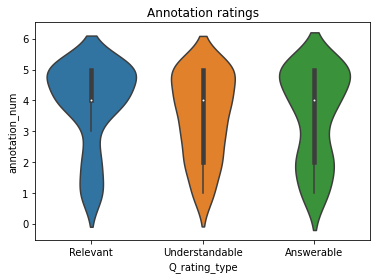

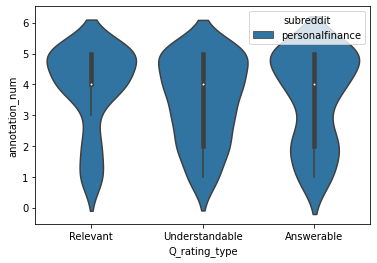

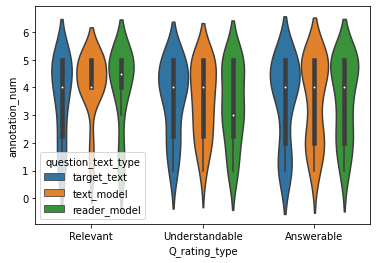

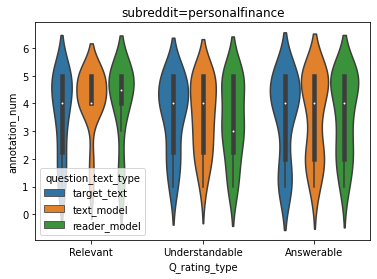

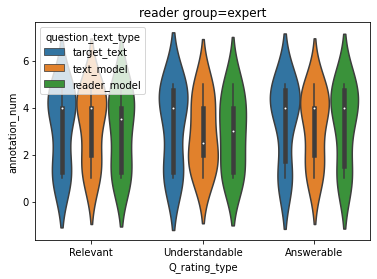

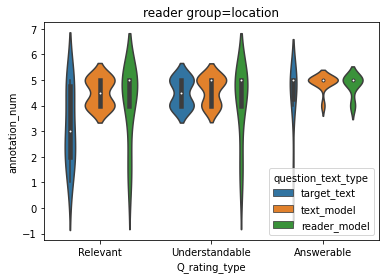

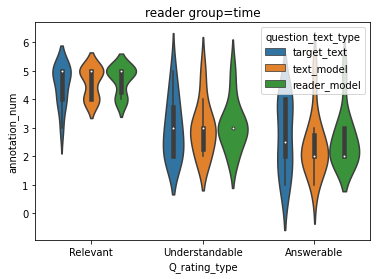

In [21]:
plot_quality_data(quality_annotation_data)

OK! The reader model had questions that were slightly more relevant but less understandable.

The gains seemed to be biggest in the "location" category.

In [22]:
def plot_group_data(data):
    annotation_subreddits = list(sorted(data.loc[:, 'subreddit'].unique()))
    # get aggregate % and distribution
    print(data.loc[:, 'annotation_correct'].mean())
    # per subreddit
    display(data.groupby('subreddit').apply(lambda x: x.groupby('ResponseId').apply(lambda y: y.loc[:, 'annotation_correct'].mean()).mean()).reset_index())
    # per reader category
    display(data.groupby(['group_category']).apply(lambda x: x.groupby('ResponseId').apply(lambda y: y.loc[:, 'annotation_correct'].mean()).mean()).reset_index())
    # per subreddit, per reader category
    display(data.groupby(['group_category', 'subreddit']).apply(lambda x: x.groupby('ResponseId').apply(lambda y: y.loc[:, 'annotation_correct'].mean()).mean()).reset_index().pivot(index=['subreddit'], columns=['group_category'], values=0))
    ## per subreddit
    plt.figure(figsize=(10,4))
    sns.barplot(data=data, x='subreddit', y='annotation_correct', order=annotation_subreddits)
    plt.show()
    ## per reader group
    plt.figure(figsize=(10,4))
    sns.barplot(data=data, x='group_category', y='annotation_correct')
    plt.show()
    ## per subreddit, per reader group
    plt.figure(figsize=(20,4))
    sns.barplot(data=data, x='subreddit', y='annotation_correct', hue='group_category', order=annotation_subreddits)
    plt.show()
    ## per annotator lol
    plt.figure(figsize=(30,4))
    sns.barplot(data=data, x='ResponseId', y='annotation_correct')
    plt.show()

0.5333333333333333


,subreddit,0
0,personalfinance,0.533333


,group_category,0
0,expert,0.3
1,location,0.6
2,time,0.7


group_category,expert,location,time
subreddit,,,
personalfinance,0.3,0.6,0.7


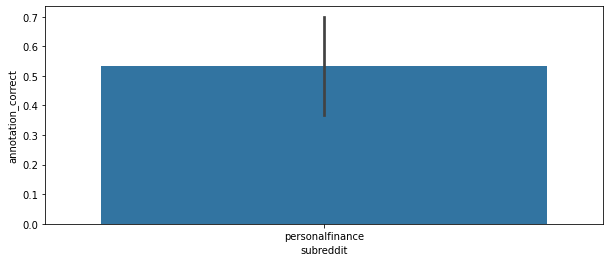

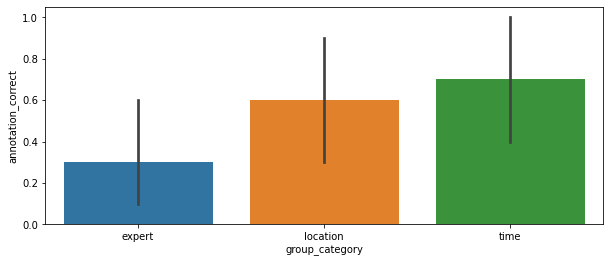

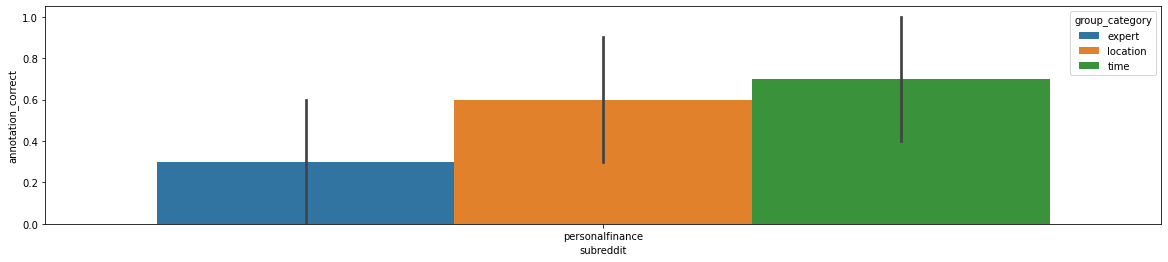

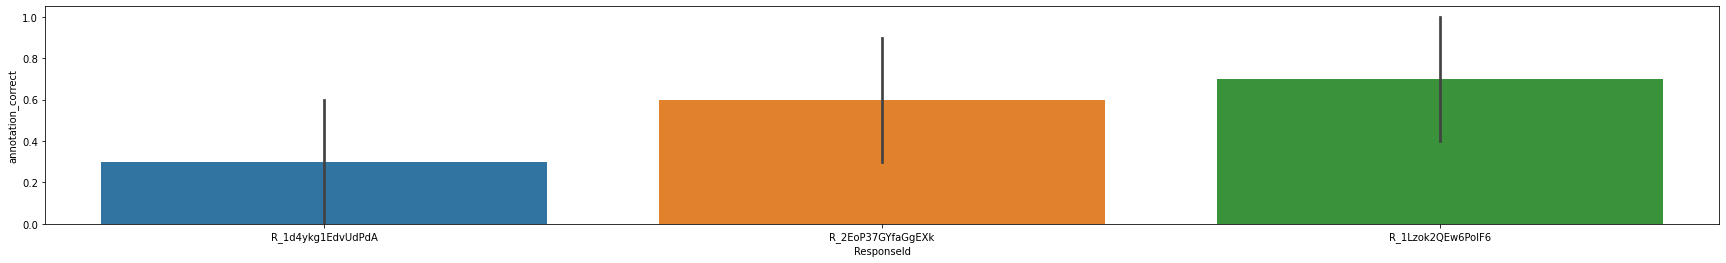

In [23]:
plot_group_data(group_annotation_data)

OK! The time/location guesses were OK, otherwise not so good.